# Statistical Analysis of CEUA Survey

## Readme
Work in progress

## Sumary 

## 1. Installing external libraries needed

In [66]:
# !pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client statsmodels gspread oauth2client
# !pip install --upgrade --force-reinstall numpy matplotlib
# !pip install "numpy<2.0" matplotlib --force-reinstall
# !pip install nltk
# !pip install geopandas
# !pip install seaborn
# !pip install scikit-learn
# !pip install scipy

## 1.1 Importing common libraries for analysis

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import gspread
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import triu
import sqlite3
import re
import warnings
from oauth2client.service_account import ServiceAccountCredentials
import gspread

# Suppress the specific FutureWarning from seaborn/pandas to create a polished output
warnings.simplefilter(action='ignore', category=FutureWarning)


#import os
#import io
#from google.oauth2 import service_account
#from googleapiclient.discovery import build
#from googleapiclient.http import MediaIoBaseDownload


In [21]:
# import pandas as pd
# import gspread

# # --- Configuration ---
# # The name of your original, messy spreadsheet
# SOURCE_SPREADSHEET_NAME = 'Análise estatística Q1_corrigido'
# # The name for the new, clean local CSV file
# CLEANED_LOCAL_FILENAME = 'Análise estatística Q1_corrigido (Cleaned).csv'
# # The path to your JSON key file
# KEY_FILE_PATH = 'data-analysis-ceuas-887bb6706d4f.json'


# def clean_and_save_locally(source_name, new_filename, key_path):
#     """
#     Reads a Google Sheet, cleans whitespace from all cells,
#     and saves the result to a local CSV file.
#     """
#     try:
#         # --- 1. Connect and Load the Messy Data ---
#         print(f"Connecting to Google Sheets and loading '{source_name}'...")
#         gc = gspread.service_account(filename=key_path)
#         spreadsheet = gc.open(source_name)
#         worksheet = spreadsheet.get_worksheet(0)
#         data = worksheet.get_all_values()
        
#         # Load into a DataFrame to make cleaning easy
#         df = pd.DataFrame(data[1:], columns=data[0])
#         print("Successfully loaded the source data.")

#         # --- 2. Clean the Data ---
#         print("Cleaning whitespace from all headers and cells...")
#         # Clean column headers
#         df.columns = df.columns.str.strip()
        
#         # Clean every cell in the DataFrame
#         # We apply a function that strips whitespace if the cell is a string
#         df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)
#         print("Data cleaning complete!")

#         # --- 3. Save the Cleaned Data Locally ---
#         print(f"Saving cleaned data to local file: '{new_filename}'...")
#         # Save the cleaned DataFrame to a CSV file.
#         # index=False prevents pandas from writing row numbers into the file.
#         # encoding='utf-8-sig' helps ensure special characters are read correctly in Excel.
#         df.to_csv(new_filename, index=False, encoding='utf-8-sig')
        
#         print(f"\nSuccess! A new, cleaned CSV file has been saved locally.")
#         print(f"File name: '{new_filename}'")

#     except gspread.exceptions.SpreadsheetNotFound:
#         print(f"ERROR: Spreadsheet '{source_name}' not found.")
#     except Exception as e:
#         print(f"An unexpected error occurred: {e}")

# if __name__ == '__main__':
#     clean_and_save_locally(SOURCE_SPREADSHEET_NAME, CLEANED_LOCAL_FILENAME, KEY_FILE_PATH)


## 2. Loading data from GDrive


    --- Methodological Summary & Plot Explanation ---
    To identify similar rows, this script employs a standard NLP vector space model.
    First, each row's text is converted into a numerical vector using a Bag-of-Ngrams approach
    (counting both single words and two-word phrases).

    The similarity between these vectors is then calculated using Cosine Similarity.
    This metric evaluates the cosine of the angle between two vectors, effectively measuring
    how similar their content is, irrespective of the total length of the text. A score
    of 1.0 means the content is proportionally identical.

    The plot shows the number of pairs found at different similarity cutoffs.
    The "elbow" on this plot indicates a point of diminishing returns—the optimal cutoff
    that captures the most significant duplicates without including too many dissimilar pairs.

    We will proceed with an empirically chosen default threshold of 0.85. This value is
    a common baseline as it typic

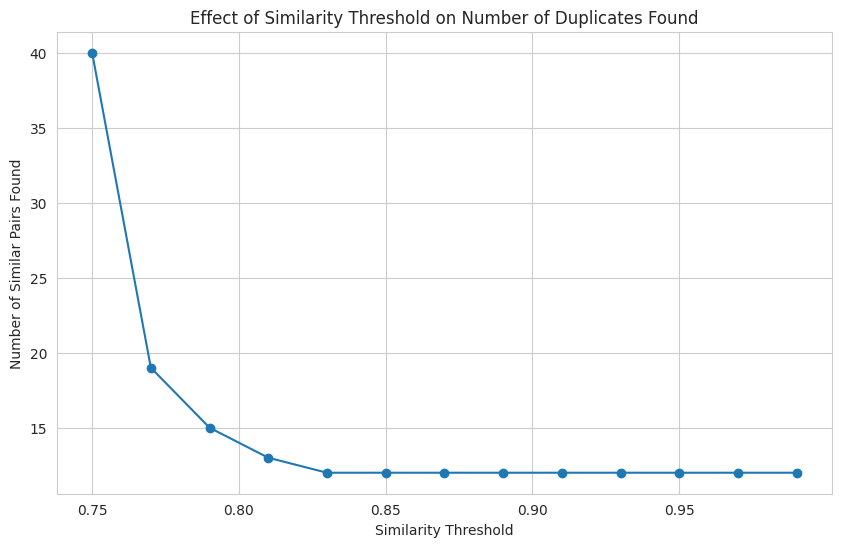

Plot generated to help choose a similarity cutoff.

--- Finding pairs with similarity >= 0.85 ---

Found 12 similar pairs.
Suggested rows to remove (duplicates): 115, 118, 159, 17, 302, 343, 354, 365, 80, 85, 87

Full report saved to 'similar_rows_report.csv'


In [22]:
# --- NLTK Stopwords Setup ---
# Download stopwords list if not already present
try:
    stopwords.words('portuguese')
except LookupError:
    print("Downloading nltk stopwords for Portuguese...")
    nltk.download('stopwords')

# --- Configuration ---
SPREADSHEET_NAME = 'Principal'
KEY_FILE_PATH = 'data-analysis-ceuas-887bb6706d4f.json'

def load_data(sheet_name, key_path):
    """Connects to Google Sheets and loads the specified sheet into a DataFrame."""
    try:
        gc = gspread.service_account(filename=key_path)
        spreadsheet = gc.open(sheet_name)
        worksheet = spreadsheet.get_worksheet(0)
        data = worksheet.get_all_values()
        headers = data.pop(0)
        df = pd.DataFrame(data, columns=headers)
        print(f"Success! Spreadsheet '{sheet_name}' loaded into a DataFrame.")
        return df
    except FileNotFoundError:
        print(f"ERROR: The key file was not found at '{key_path}'.")
    except gspread.exceptions.SpreadsheetNotFound:
        print(f"ERROR: Spreadsheet '{sheet_name}' not found.")
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
    return None

def preprocess_data(df):
    """Prepares the DataFrame for analysis by handling IDs and combining text."""
    if 'Cód.' in df.columns:
        df['Original_ID'] = df['Cód.'].copy()
        df = df.drop(columns=['Cód.'])
        # print("Preserved 'Cód.' column as Original_ID and dropped the original.")
    else:
        print("'Cód.' column not found - using 1-based row numbers as Original_ID.")
        df['Original_ID'] = np.arange(len(df)) + 1
    
    columns_to_compare = [col for col in df.columns if col != 'Original_ID']
    df['Combined'] = df[columns_to_compare].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    df_filtered = df[df['Combined'].str.len() > 10].reset_index(drop=True)
    
    return df_filtered, columns_to_compare

def plot_threshold_analysis(df, text_column, stop_words_list):
    """Calculates similarity and plots the number of similar pairs vs. threshold."""
    print("\n--- Analyzing Similarity Thresholds ---")
    vectorizer = CountVectorizer(
        lowercase=True,
        stop_words=stop_words_list,
        ngram_range=(1, 2),
        min_df=2
    )
    text_matrix = vectorizer.fit_transform(df[text_column])
    cosine_similarities = cosine_similarity(text_matrix)
    
    threshold_values = np.arange(0.75, 1.0, 0.02)
    similar_rows_counts = []
    
    upper_triangle = triu(cosine_similarities, k=1)

    for threshold in threshold_values:
        similar_indices = np.argwhere(upper_triangle >= threshold)
        similar_rows_counts.append(len(similar_indices))
        
    plt.figure(figsize=(10, 6))
    plt.plot(threshold_values, similar_rows_counts, marker='o', linestyle='-')
    plt.xlabel('Similarity Threshold')
    plt.ylabel('Number of Similar Pairs Found')
    plt.title('Effect of Similarity Threshold on Number of Duplicates Found')
    plt.grid(True)
    plt.xticks(np.arange(0.75, 1.0, 0.05))
    plt.show()
    print("Plot generated to help choose a similarity cutoff.")


def find_similar_rows(df, text_column, stop_words_list, threshold=0.85):
    """Vectorizes text and finds pairs of rows with cosine similarity above a threshold."""
    vectorizer = CountVectorizer(
        lowercase=True,
        stop_words=stop_words_list, # Use the provided list
        ngram_range=(1, 2),
        min_df=2
    )
    text_matrix = vectorizer.fit_transform(df[text_column])
    cosine_similarities = cosine_similarity(text_matrix)
    
    upper_triangle = triu(cosine_similarities, k=1)
    similar_indices = np.argwhere(upper_triangle >= threshold)
    
    return [(i, j, cosine_similarities[i, j]) for i, j in similar_indices]

def generate_report(df, similar_pairs, columns_to_compare):
    """Generates a DataFrame report of the similar pairs found."""
    report_data = []
    for i, j, similarity in similar_pairs:
        id1 = df.loc[i, 'Original_ID']
        id2 = df.loc[j, 'Original_ID']
        
        row1_data = df.loc[i, columns_to_compare]
        row2_data = df.loc[j, columns_to_compare]
        diff_mask = row1_data != row2_data
        differing_columns = diff_mask.index[diff_mask].tolist()
        
        report_data.append({
            'ID_A': id1,
            'ID_B': id2,
            'Similarity': round(similarity, 4),
            'Differing_Columns': ', '.join(differing_columns) if differing_columns else 'None',
            'Content_A': df.loc[i, 'Combined'][:100] + '...',
            'Content_B': df.loc[j, 'Combined'][:100] + '...'
        })
    return pd.DataFrame(report_data)

def main():
    """Main function to run the similarity analysis workflow."""
    df_raw = load_data(SPREADSHEET_NAME, KEY_FILE_PATH)
    
    if df_raw is not None:
        df_processed, columns_to_compare = preprocess_data(df_raw.copy())
        
        # Get the Portuguese stop words list
        portuguese_stopwords = stopwords.words('portuguese')
        
        # --- NEW: Generate and show the plot first ---
        plot_threshold_analysis(df_processed, 'Combined', portuguese_stopwords)
        
        # --- Then, proceed with the chosen threshold ---
        print(f"\n--- Finding pairs with similarity >= 0.85 ---")
        similar_pairs = find_similar_rows(df_processed, 'Combined', portuguese_stopwords, threshold=0.85)
        
        if similar_pairs:
            report_df = generate_report(df_processed, similar_pairs, columns_to_compare)
            
            duplicate_ids_to_remove = sorted(list(set(report_df['ID_B'])))
            print(f"\nFound {len(report_df)} similar pairs.")
            print(f"Suggested rows to remove (duplicates): {', '.join(map(str, duplicate_ids_to_remove))}")
            
            report_df.to_csv('similar_rows_report.csv', index=False)
            print("\nFull report saved to 'similar_rows_report.csv'")
        else:
            print("\nNo similar rows found above the threshold.")
print("""
    --- Methodological Summary & Plot Explanation ---
    To identify similar rows, this script employs a standard NLP vector space model.
    First, each row's text is converted into a numerical vector using a Bag-of-Ngrams approach
    (counting both single words and two-word phrases).

    The similarity between these vectors is then calculated using Cosine Similarity.
    This metric evaluates the cosine of the angle between two vectors, effectively measuring
    how similar their content is, irrespective of the total length of the text. A score
    of 1.0 means the content is proportionally identical.

    The plot shows the number of pairs found at different similarity cutoffs.
    The "elbow" on this plot indicates a point of diminishing returns—the optimal cutoff
    that captures the most significant duplicates without including too many dissimilar pairs.

    We will proceed with an empirically chosen default threshold of 0.85. This value is
    a common baseline as it typically represents a strong textual overlap, allowing for
    minor variations (like typos or rephrasing) while still ensuring the core content is
    the same. 
    """)


if __name__ == '__main__':
    main()


## 2.1 Loading data from cleaned up spreadsheet after the Qualitative Analysis
Open-ended survey responses were systematically analyzed to transform unstructured text into categorical variables for statistical analysis. Through an inductive coding process, categories and themes were derived directly from the response content to build a comprehensive codebook. This involved multi-dimensional coding for complex answers and synthesizing individual codes into broader thematic blocks. The final output was a new set of numerically coded variables, which formed the dataset for the quantitative analysis.

In [23]:
# --- Configuration ---
# The name of the Google Sheet file as it appears in your Drive
SPREADSHEET_NAME = 'Análise estatística Q1_corrigido'
# The path to your downloaded JSON key file
KEY_FILE_PATH = 'data-analysis-ceuas-887bb6706d4f.json'

# --- Authenticate and Connect ---
try:
    # Use gspread's built-in service account function for modern authentication
    gc = gspread.service_account(filename=KEY_FILE_PATH)

    # --- Load the Data ---
    # Open the spreadsheet by its name
    spreadsheet = gc.open(SPREADSHEET_NAME)

    # Select the first worksheet
    worksheet = spreadsheet.get_worksheet(0)

    # Get all records from the worksheet and load into a pandas DataFrame
    records = worksheet.get_all_records()
    df = pd.DataFrame(records)
    print("Success! Your spreadsheet has been loaded into a DataFrame.")

except FileNotFoundError:
    print(f"ERROR: The key file was not found at '{KEY_FILE_PATH}'.")
    print("Please make sure the file name is correct and it's in the right directory.")
except gspread.exceptions.SpreadsheetNotFound:
    print(f"ERROR: Spreadsheet '{SPREADSHEET_NAME}' not found.")
    print("Please check the spreadsheet name and make sure you've shared it with the service account email.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Success! Your spreadsheet has been loaded into a DataFrame.


## 2.2 Showing some lines of the dataset

In [24]:
df

,Cod.,Ativo,3. Idade,4. Genero,5. Regiao,6. Estado,7. Cidade,8. Religiao,Religiao_codificado(8),9. Vinculo,...,55. Suas_colocacoes_sao_respeitadas,56. Ha_resistencia_as_suas_propostas,57. Demais_membros_atribuem_o_mesmo_nivel_de_preocupacao,58. Sente-se_estressado_nas_reunioes,59. Receio_de_aceitar_ou_rejeitar_protocolo,60. Membros_tem_receio_de_rejeitar_protocolos,61. Ao_avaliar_projeto_de_membro_ele_deve_se_ausentar,62. Membros_que_pesquisam_com_modelos_animais_minimizam_o_sofrimento_deles,63. O_quanto_a_CEUA_se_baseia_no_principio_dos_3Rs_escala,64. Comentario_sobre_CEUAs
0,1,TRUE,Entre 31 e 40 anos,Masculino,Sul,RS,Santa Maria,Catolicismo,2,Não,...,Constantemente,Raramente,Constantemente,Nunca,Nunca,Nunca,Sim,Nunca,5,
1,2,TRUE,Entre 31 e 40 anos,Feminino,Sul,SC,Curitibanos,Não tenho religião,5,Não,...,Constantemente,Nunca,Constantemente,Raramente,Nunca,Raramente,Sim,Raramente,4,
2,3,TRUE,Entre 51 e 60 anos,Feminino,Sul,RS,Cerro Largo,Evangélica,3,Não,...,Frequentemente,Nunca,Frequentemente,Nunca,Nunca,Raramente,Sim,Raramente,4,
3,4,TRUE,Entre 41 e 50 anos,Feminino,Nordeste,SE,Aracaju,Não tenho religião,5,Não,...,Constantemente,Raramente,Frequentemente,Frequentemente,Raramente,Nunca,Sim,Frequentemente,3,Percepo que as CEUAs ainda formalizam o uso d...
4,5,TRUE,Entre 61 e 70 anos,Feminino,Centro-oeste,DF,Brasília,Espiritismo,4,Não,...,Constantemente,Raramente,Frequentemente,Nunca,Nunca,Nunca,Sim,Raramente,4,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,377,TRUE,Entre 31 e 40 anos,Feminino,Sul,PR,Realeza,Catolicismo,2,Sim,...,Constantemente,Nunca,Frequentemente,Raramente,Nunca,Raramente,Sim,Raramente,4,
377,378,TRUE,Entre 51 e 60 anos,Feminino,Sudeste,MG,Uberaba,Espiritismo,4,Sim,...,Frequentemente,Raramente,Frequentemente,Raramente,Nunca,Raramente,Sim,Frequentemente,3,Sinto-me gratificada por participar de uma CEU...
378,379,TRUE,Entre 41 e 50 anos,Feminino,Norte,PA,Belém,Cristã protestante,3,Não,...,Constantemente,Nunca,Constantemente,Nunca,Nunca,Nunca,Sim,Constantemente,5,
379,380,TRUE,Entre 31 e 40 anos,Prefiro não responder,Sudeste,SP,São Paulo,Catolicismo,2,Não,...,Frequentemente,Não sei dizer,Frequentemente,Raramente,Frequentemente,Raramente,Sim,Raramente,4,"Acho a existência delas algo importante, mas a..."


## 2.3 Converting the set of spreadsheets into a relational database for table creation

In [25]:
import pandas as pd
import gspread
import sqlite3
from sqlite3 import Error
import re

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
SPREADSHEET_NAME = 'Análise estatística Q1_corrigido'
KEY_FILE_PATH = 'data-analysis-ceuas-887bb6706d4f.json'

def connect_and_load_gsheet(key_path, sheet_name):
    """Loads the Google Sheet into a pandas DataFrame."""
    try:
        gc = gspread.service_account(filename=key_path)
        spreadsheet = gc.open(sheet_name)
        worksheet = spreadsheet.get_worksheet(0)
        data = worksheet.get_all_values()
        headers = [h.strip() for h in data.pop(0)]
        df = pd.DataFrame(data, columns=headers)
        print("Success: Google Sheet loaded.")
        return df
    except Exception as e:
        print(f"Error loading Google Sheet: {e}")
        return None

def create_connection(db_file):
    """Creates a SQLite database connection."""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return conn

def main():
    """Performs the complete, correct database migration."""
    df = connect_and_load_gsheet(KEY_FILE_PATH, SPREADSHEET_NAME)
    if df is None:
        return

    conn = create_connection(DATABASE_NAME)
    if conn is None:
        return
        
    cursor = conn.cursor()
    
    # 1. Clear any old structure for a fresh start.
    print("\n--- Clearing database for a fresh start ---")
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'sqlite_sequence';")
    tables = cursor.fetchall()
    for table_name in tables:
        cursor.execute(f"DROP TABLE IF EXISTS {table_name[0]}")
    print(f"Cleared {len(tables)} old tables.")

    # 2. Define and Create the DEFINITIVE Schema.
    print("\n--- Creating new, complete relational schema ---")
    
    # Lookup Tables
    codified_columns = {
        "Religiao_codificado(8)": "Religions",
        "Justifique_dever_assumir_relatoria_codificado(25)": "JustificativaRelatoriaLookup",
        "Justifique_SPA_deve_ter_formacao_aberta_codificado(27)": "JustificativaFormacaoLookup",
        "Papel_na_CEUA_codificado(28)": "PapelCEUALookup",
        "Funcao_administrativa_na_CEUA_codificado(32)": "FuncaoAdminLookup",
        "Justifique_experimentacao_animal_ser_mal_necessario_codificado(45)": "JustificativaMalNecessarioLookup",
        "Na_avaliacao_de_danos_e_beneficios_o_que_e_importante_codificada(47)": "AvaliacaoDanosBeneficiosLookup"
    }
    for table_name in codified_columns.values():
        cursor.execute(f"CREATE TABLE IF NOT EXISTS {table_name} (id INTEGER PRIMARY KEY, name TEXT NOT NULL);")
        print(f"Table '{table_name}' created.")

    # Main Respondents table with core info
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Respondents (
        "Cod." INTEGER PRIMARY KEY,
        "Ativo" BOOLEAN NOT NULL,
        "3. Idade" TEXT,
        "4. Genero" TEXT
    );""")
    print("Table 'Respondents' created.")

    # SurveyAnswers table for all other columns to ensure no data is lost
    core_cols = {'Cod.', 'Ativo', '3. Idade', '4. Genero'}
    survey_answer_cols = [f'"{col}" TEXT' for col in df.columns if col not in core_cols and col.strip() != '']
    survey_answers_table_sql = f"""
    CREATE TABLE IF NOT EXISTS SurveyAnswers (
        AnswerID INTEGER PRIMARY KEY AUTOINCREMENT,
        RespondentID INTEGER NOT NULL UNIQUE,
        {', '.join(survey_answer_cols)},
        FOREIGN KEY (RespondentID) REFERENCES Respondents ("Cod.")
    );"""
    cursor.execute(survey_answers_table_sql)
    print("Table 'SurveyAnswers' created to hold all original columns.")
    
    # 3. Populate Lookup Tables
    print("\n--- Populating Lookup Tables ---")
    religion_data = [(1, 'Ateismo/Agnosticismo'),(2, 'Catolicismo'),(3, 'Cristãos outros/protestantes/evangélicos'),(4, 'Espiritismo'),(5, 'Não segue religião específica'),(6, 'Outras/Não respondeu'),(7, 'Religiões Afrobrasileiras')]
    justificativa_relatoria_data = [(0, "Não opinou; declarou não ter opinião; declarou algo não definível"),(1, "Falta de Competências, Conhecimentos Técnicos/Científicos (incluindo em BEA), treinamento, formação superior ou capacidades (incluindo argumentativa). Falta de imparcialidade/Antiético;SPA é passional/pode haver extremismo e conflito; Pessoas de dificil convivência"),(2, "Falta de engajamento, participação, comunicação/contato, presença, constância, abertura, diálogo/não há interesse por participar. Falta de engajamento da SPA; dificuldade em encontrar representantes"),(3, "Desde que: tenha formação superior ou conhecimento técnico/científico, ou receba ajuda/orientação/contribuição de outro membro/conheça as normativas do CONCEA/seja qualificado/tenha disponibilidade."),(4, "SPA tem competência/ Por ser membro de uma sociedade protetora deve ter conhecimento de ética e legislações pertinentes ao bem-estar animal."),(5, "Contribuição positiva: Gera Aprendizado para a CEUA ou para o membro SPA ou aumenta engajamento do SPA, visão externa e Diversidade de opiniões ajudam, melhor distribuição de tarefas. Função educativa (para SPA ou a CEUA ). Positivo para a defesa ou proteção dos animais, positivo para o BEA.Representam os interesses dos animais; protegem decisão ética/correta."),(6, "Respeito à Isonomia, Imparcialidade, acesso igualitário, igualdade, inclusão, diversidade de opiniões/pois a CEUA é multidisciplinar. Não deve haver diferenciação. A regra é a mesma para todos/A decisão final é coletiva/colegiada. Direito; Representatividade"),(7, "Não é função do SPA. Regra do CONCEA, Papel exclusivo, para membros institucionais, internos ou com certos papeis (médico veterinário, zootecnista ou biólogo). Papel exclusivo de certos membros; Riscos (confidencialidade). Desnecessário; não há benefício; não acrescenta; os outros membros são suficientes; indiferente"),(8, "Falta de imparcialidade/Antiético;SPA é passional/pode haver extremismo e conflito; Pessoas de dificil convivência")]
    justificativa_formacao_data = [(0, "Não opinou; declarou não ter opinião; declarou algo não definível"),(1, "É necessário: para entender, avaliar e contribuir. Para estar no nível apropriado/conseguir entender e dialogar os proponentes de pesquisa e seus pares. Para fazer Avaliação técnica. O entendimento dos projetos requer noções de estatistica, delineamento experimental; manipulação de animais, ciências agrárias. Para poder assumir relatoria de protocolos; para dar parecer, avaliar protocolos. Conhecimento acadêmico básico/nível superior. Para ter conhecimento teórico em vários assuntos, o que é muito importante. Graduação em geral contribui, sem especificar área."),(2, "Evitar Imparcialidade, achismo; \"fundamentalismo\"; fanatismo, atitude anti cientifica, paixoes, realmente contribuir, ter visão mais racional da proteção aos animais, evitar viés emocional."),(3, "Não é necessário; As habilidades e conhecimentos importantes para a função não dependem de formação academica. Não é necessário mas é desejável. Um curso ou algum tipo de capacitação poderia resolver"),(4, "É preciso ter Conhecimentos relevantes à proteção animal, para cumporirem o papel de defesa e cuidado com os animais. Conhecimento em ética, direito dos animais. Conhecimentos especificos: anatomia sobre a espécie que se defende; particularidades de cada espécie; legislação, bem-estar animal."),(5, "Pode ser uma Exigência negativa: Necessidade de formação pode ser negativo: não ser representativo da siociedade, restringir participação, reduzir visão diferente"),(6, "Para entender a importancia do uso de animais")]
    papel_ceua_data = [(1, "Biólogo (a)"),(2, "Consultor Ad-hoc"),(3, "Docente"),(4, "Incerto"),(5, "Médico(a) Veterinário (a)"),(6, "Representantes de outras áreas"),(7, "Pesquisador(a)"),(8, "Representante da Sociedade Protetora de Animais")]
    funcao_admin_data = [(1, "Coordenador"),(2, "Não ocupo nenhuma função administrativa"),(3, "Secretário"),(4, "Vice-coordenador")]
    justificativa_mal_necessario_data = [(0, "Não clasificável"),(1, "Discorda que seja um mal: Respostas que discordam da ideia de que a experimentação animal seja um mal, especialmente quando seguem preceitos éticos. Não é mal, é só necessário -aparente incomodo com a afirmação. Críticas à pergunta, considera ofensiva. Foco em apontar que não é um mal. Parece não entender a complexidade ética da pergunta."),(2, "Confiança em Métodos Alternativos: Respostas que confiam em métodos alternativos, incluindo modelos in vitro e métodos já existentes ou em desenvolvimento. Menciona expectativa de quem em breve não seja mais necessário."),(3, "Crítica à Experimentação: Respostas que criticam ou questionam a necessidade de animais ou manifestam incômodo com práticas de uso de animais atual. Crítica à quantidade usada. Muitos estudos poderiam ser substituidos. Aponta resistência dos pesquisadores, na busca por alternativas."),(4, "confiança na ética e Responsabilidade: Respostas que destacam a importância de seguir protocolos éticos, os 3Rs, e a responsabilidade dos pesquisadores. Basta seguir os 3Rs"),(5, "Condicional: Respostas que mencionam que depende, que a experimentação é necessária em alguns casos, ou enquanto as técnicas de substituição não forem aprimoradas ou disponíveis: Ainda é necessário. Ou Dependendo do objetivo. Se for para o próprio animal. Foco na justificativa."),(6, "Limitações das alternativas: Respostas que apontam limitações dos métodos alternativos ou falta de recursos."),(7, "Avanços Científicos e Benefícios para a Humanidade: Respostas que justificam a experimentação animal destacando os avanços científicos e os benefícios resultantes para a saúde e o bem-estar humano. Foco nos fins. Alegação de que é necessário ou ainda é necessário."),(8, "Confiança no modelo Animal: Engloba respostas que afirmam a adequabilidade ou superioridade do modelo animal enquanro método, reconhecendo a confiança nos métodos atuais, incluindo refinamento e redução, e a dificuldade de substituição em certos contextos. Menciona ter sido útil no passado. Sugere que este é o jeito de fazer ciência, sem entrar em questões éticas. Foca na vantagem do método"),(9, "destaca o dano para o animal")]
    
    # *** ALTERAÇÃO INICIA AQUI ***
    # Dados para a nova tabela de consulta que estava faltando.
    avaliacao_danos_beneficios_data = [
        (0, 'Não classificável'),
        (1, 'Conhecimento'),
        (2, 'Qualidade da pesquisa'),
        (3, 'Relevância e benefícios'),
        (4, 'Substituição'),
        (5, 'Redução'),
        (6, 'Refinamento'),
        (7, 'Processo de avaliação'),
        (8, 'Princípios éticos'),
        (9, '3Rs')
    ]
    # *** ALTERAÇÃO TERMINA AQUI ***

    cursor.executemany("INSERT OR IGNORE INTO Religions (id, name) VALUES (?, ?)", religion_data)
    cursor.executemany("INSERT OR IGNORE INTO JustificativaRelatoriaLookup (id, name) VALUES (?, ?)", justificativa_relatoria_data)
    cursor.executemany("INSERT OR IGNORE INTO JustificativaFormacaoLookup (id, name) VALUES (?, ?)", justificativa_formacao_data)
    cursor.executemany("INSERT OR IGNORE INTO PapelCEUALookup (id, name) VALUES (?, ?)", papel_ceua_data)
    cursor.executemany("INSERT OR IGNORE INTO FuncaoAdminLookup (id, name) VALUES (?, ?)", funcao_admin_data)
    cursor.executemany("INSERT OR IGNORE INTO JustificativaMalNecessarioLookup (id, name) VALUES (?, ?)", justificativa_mal_necessario_data)
    
    # *** ALTERAÇÃO INICIA AQUI ***
    # Executa a inserção dos dados para a tabela de consulta de danos e benefícios.
    cursor.executemany("INSERT OR IGNORE INTO AvaliacaoDanosBeneficiosLookup (id, name) VALUES (?, ?)", avaliacao_danos_beneficios_data)
    # *** ALTERAÇÃO TERMINA AQUI ***

    print("Populated all available lookup tables with provided meanings.")

    # Populate other lookup tables with placeholders
    # *** ALTERAÇÃO INICIA AQUI ***
    # Adicionado 'AvaliacaoDanosBeneficiosLookup' à lista para que não seja sobrescrito com valores de placeholder.
    populated_tables = ["Religions", "JustificativaRelatoriaLookup", "JustificativaFormacaoLookup", "PapelCEUALookup", "FuncaoAdminLookup", "JustificativaMalNecessarioLookup", "AvaliacaoDanosBeneficiosLookup"]
    # *** ALTERAÇÃO TERMINA AQUI ***
    for original_col, table_name in codified_columns.items():
        if table_name not in populated_tables:
            unique_codes = df[original_col].dropna().unique()
            for code in unique_codes:
                if str(code).strip():
                    try:
                        cursor.execute(f"INSERT OR IGNORE INTO {table_name} (id, name) VALUES (?, ?)", (int(code), f"Meaning for code {code}"))
                    except (ValueError, TypeError): pass
            print(f"Populated '{table_name}' with placeholder values.")
    conn.commit()

    # 4. Populate Main Data Tables
    print("\n--- Populating main data tables ---")
    survey_cols_for_insert = [col for col in df.columns if col not in core_cols and col.strip() != '']
    quoted_survey_cols = ', '.join([f'"{col}"' for col in survey_cols_for_insert])
    placeholders = ', '.join(['?'] * (len(survey_cols_for_insert) + 1))
    sql_insert_survey = f"INSERT INTO SurveyAnswers (RespondentID, {quoted_survey_cols}) VALUES ({placeholders})"
    
    for index, row in df.iterrows():
        if pd.isna(row['Cod.']) or str(row['Cod.']).strip() == '': continue
        
        respondent_id = int(row['Cod.'])
        is_active = True if str(row.get('Ativo', '')).strip().upper() == 'TRUE' else False
        
        cursor.execute('INSERT INTO Respondents ("Cod.", "Ativo", "3. Idade", "4. Genero") VALUES (?, ?, ?, ?)',
                       (respondent_id, is_active, row.get('3. Idade'), row.get('4. Genero')))
        
        survey_values = [row.get(col, None) for col in survey_cols_for_insert]
        cursor.execute(sql_insert_survey, [respondent_id] + survey_values)

    conn.commit()
    conn.close()
    
    print(f"\nMigration complete! The database 'ceua_analysis_v3.db' is correct and ready for use.")

if __name__ == '__main__':
    main()


Success: Google Sheet loaded.

--- Clearing database for a fresh start ---
Cleared 9 old tables.

--- Creating new, complete relational schema ---
Table 'Religions' created.
Table 'JustificativaRelatoriaLookup' created.
Table 'JustificativaFormacaoLookup' created.
Table 'PapelCEUALookup' created.
Table 'FuncaoAdminLookup' created.
Table 'JustificativaMalNecessarioLookup' created.
Table 'AvaliacaoDanosBeneficiosLookup' created.
Table 'Respondents' created.
Table 'SurveyAnswers' created to hold all original columns.

--- Populating Lookup Tables ---
Populated all available lookup tables with provided meanings.

--- Populating main data tables ---

Migration complete! The database 'ceua_analysis_v3.db' is correct and ready for use.


## 3. Univariate Analysis
Here we are examining a single variable at a time to understand its core characteristics. The main goal is to describe and summarize the data's properties. 

Success: Loaded age data for active respondents.

--- Descriptive Statistics for Age Range (Translated) ---
count                         369
unique                          5
top       Between 41 and 50 years
freq                          134
Name: AgeRange, dtype: object

--- Descriptive Statistics for Age (Estimated Numeric) ---
Mean Age (estimated): 43.52
Median Age (estimated): 45.50
Standard Deviation (estimated): 9.62

--- Generating Age Distribution Plot (Translated) ---


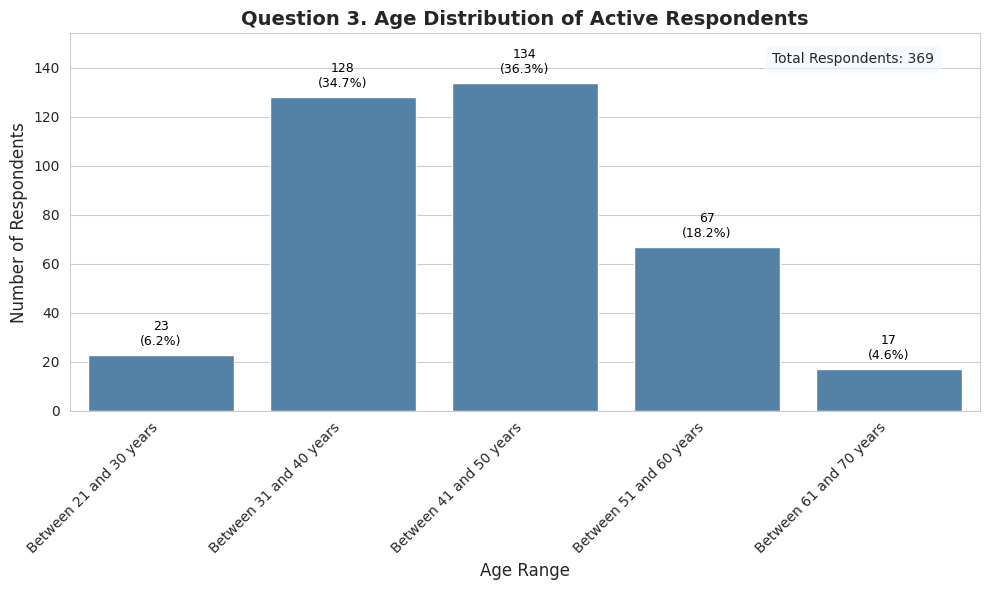

In [26]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_ages(db_name):
    """
    Queries the database to get the age data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          r."3. Idade"
        FROM
          Respondents AS r
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded age data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def convert_age_range_to_numeric(age_range):
    """Converts a translated age range string to its approximate midpoint."""
    if pd.isna(age_range):
        return np.nan
    age_range = str(age_range)
    if 'Up to 30' in age_range:
        return 30
    elif 'Over 70' in age_range:
        return 75 # An estimate for the upper range
    elif 'Between' in age_range:
        # This regex is robust for parsing 'Between XX and YY'
        parts = re.findall(r'\d+', age_range)
        if len(parts) == 2:
            low = int(parts[0])
            high = int(parts[1])
            return (low + high) / 2
    return np.nan


def main():
    """
    Main function to perform and display the univariate analysis of age.
    """
    age_df = get_active_respondent_ages(DATABASE_NAME)
    
    if age_df is not None and not age_df.empty:
        age_df.rename(columns={'3. Idade': 'AgeRange'}, inplace=True)

        # --- Data Translation Step ---
        translation_map = {
            'Até 30 anos': 'Up to 30 years',
            'Entre 31 e 40 anos': 'Between 31 and 40 years',
            'Entre 41 e 50 anos': 'Between 41 and 50 years',
            'Entre 51 e 60 anos': 'Between 51 and 60 years',
            'Entre 61 e 70 anos': 'Between 61 and 70 years',
            'Mais de 70 anos': 'Over 70 years'
        }
        # Note: The original script had a slightly different/incomplete list. This is more comprehensive.
        # Handling potential 'Entre 21 e 30 anos' which might be in the data.
        translation_map['Entre 21 e 30 anos'] = 'Between 21 and 30 years'
        
        age_df['AgeRange'] = age_df['AgeRange'].map(translation_map)


        # --- 1. Descriptive Statistics for Categorical Data ---
        print("\n--- Descriptive Statistics for Age Range (Translated) ---")
        print(age_df['AgeRange'].describe())

        # --- 2. Numerical Analysis ---
        print("\n--- Descriptive Statistics for Age (Estimated Numeric) ---")
        # Create a new column with the estimated numeric age from the translated strings
        age_df['NumericAge'] = age_df['AgeRange'].apply(convert_age_range_to_numeric)
        
        # Now we can calculate mean, median, std, etc.
        print(f"Mean Age (estimated): {age_df['NumericAge'].mean():.2f}")
        print(f"Median Age (estimated): {age_df['NumericAge'].median():.2f}")
        print(f"Standard Deviation (estimated): {age_df['NumericAge'].std():.2f}")


        # --- 3. Plotting the Data ---
        print("\n--- Generating Age Distribution Plot (Translated) ---")
        
        # Updated age_order with English translations
        age_order = [
            'Between 21 and 30 years',
            'Between 31 and 40 years', 
            'Between 41 and 50 years',
            'Between 51 and 60 years', 
            'Between 61 and 70 years', 
            'Over 70 years'
        ]
        # A more robust way to handle the order, in case some categories don't exist
        final_order = [cat for cat in age_order if cat in age_df['AgeRange'].unique()]
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=age_df,
            x='AgeRange',
            order=final_order,
            color='steelblue', # Using a single, professional color
        )
        
        plt.xlabel('Age Range', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 3. Age Distribution of Active Respondents', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        
        total_respondents = len(age_df.dropna(subset=['AgeRange']))
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            height = p.get_height()
            if height > 0: # Only add labels to bars with data
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Add more space at the top of the plot
        # to prevent labels from overlapping the title.
        if not age_df.empty:
            max_height = age_df['AgeRange'].value_counts().max()
            ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded gender data for active respondents.

--- Descriptive Statistics for Gender (Translated) ---
count        369
unique         3
top       Female
freq         233
Name: Gender, dtype: object

Frequency Count (Translated):
Gender
Female                  233
Male                    135
Prefer not to answer      1
Name: count, dtype: int64

--- Generating Gender Distribution Plot (Translated) ---


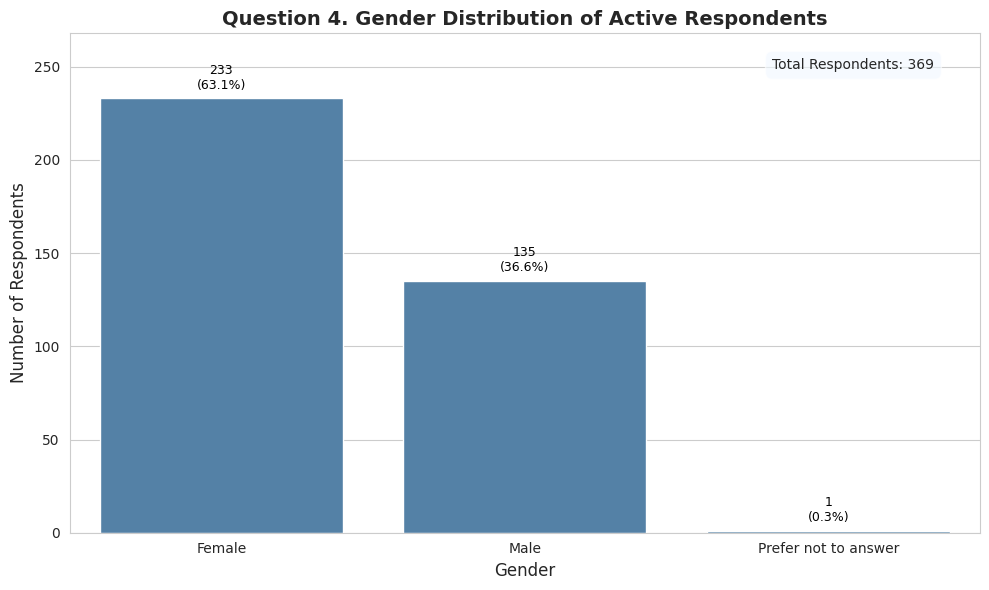

In [27]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_gender(db_name):
    """
    Queries the database to get the gender data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to select the '4. Genero' column from the Respondents table
        # for all rows where 'Ativo' is True (1).
        query = """
        SELECT
          r."4. Genero"
        FROM
          Respondents AS r
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded gender data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of gender.
    """
    gender_df = get_active_respondent_gender(DATABASE_NAME)
    
    if gender_df is not None and not gender_df.empty:
        # Rename the column for easier use and clearer outputs.
        gender_df.rename(columns={'4. Genero': 'Gender'}, inplace=True)

        # --- Data Translation Step ---
        translation_map = {
            'Feminino': 'Female',
            'Masculino': 'Male',
            'Prefiro não responder': 'Prefer not to answer'
        }
        gender_df['Gender'] = gender_df['Gender'].map(translation_map)

        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Gender (Translated) ---")
        print(gender_df['Gender'].describe())
        
        # We can also get a more detailed frequency count
        print("\nFrequency Count (Translated):")
        print(gender_df['Gender'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Gender Distribution Plot (Translated) ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=gender_df,
            x='Gender',
            color='steelblue', # A nice, single color consistent with previous plot
            order = gender_df['Gender'].value_counts().index # Order by frequency
        )
        
        plt.xlabel('Gender', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 4. Gender Distribution of Active Respondents', fontsize=14, fontweight='bold')
        
        total_respondents = len(gender_df)
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Add more space at the top of the plot
        max_height = gender_df['Gender'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded region data for active respondents.

--- Descriptive Statistics for Region (Translated) ---
count           369
unique            5
top       Southeast
freq            179
Name: Region, dtype: object

Frequency Count (Translated):
Region
Southeast       179
South            73
Northeast        58
North            30
Central-West     29
Name: count, dtype: int64

--- Generating Region Distribution Plot (Translated) ---


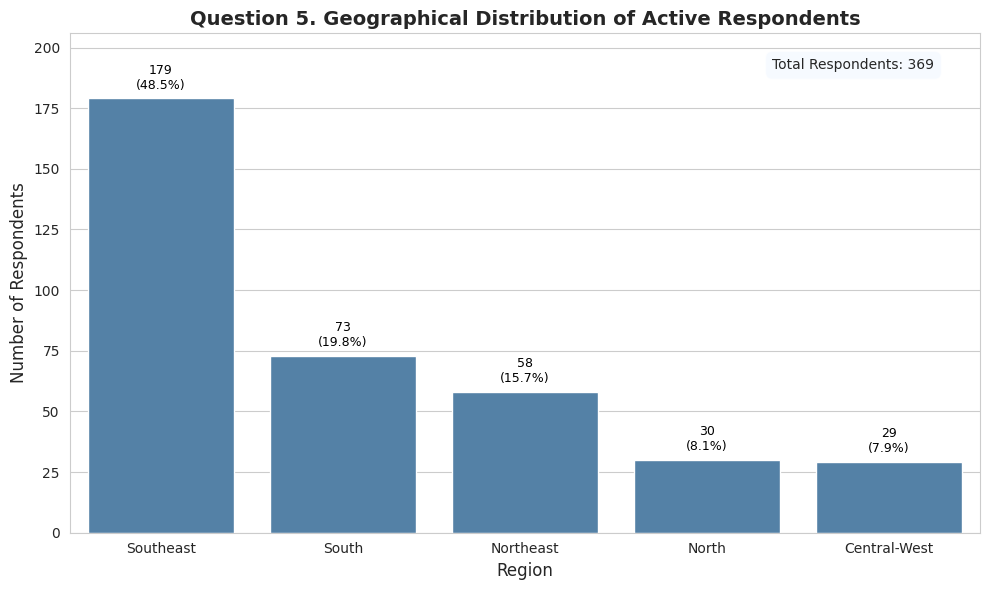

In [28]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_region(db_name):
    """
    Queries the database to get the region data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to join Respondents and SurveyAnswers to get the region
        # for all rows where 'Ativo' is True (1).
        query = """
        SELECT
          s."5. Regiao"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded region data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of region.
    """
    region_df = get_active_respondent_region(DATABASE_NAME)
    
    if region_df is not None and not region_df.empty:
        # Rename the column for easier use and clearer outputs.
        region_df.rename(columns={'5. Regiao': 'Region'}, inplace=True)

        # --- Data Translation Step ---
        translation_map = {
            'Norte': 'North',
            'Nordeste': 'Northeast',
            'Centro-oeste': 'Central-West',
            'Sudeste': 'Southeast',
            'Sul': 'South'
        }
        region_df['Region'] = region_df['Region'].map(translation_map)


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Region (Translated) ---")
        print(region_df['Region'].describe())
        
        print("\nFrequency Count (Translated):")
        print(region_df['Region'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Region Distribution Plot (Translated) ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=region_df,
            x='Region',
            color='steelblue', # Consistent color
            order = region_df['Region'].value_counts().index # Order by frequency
        )
        
        plt.xlabel('Region', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 5. Geographical Distribution of Active Respondents', fontsize=14, fontweight='bold')
        
        total_respondents = len(region_df)
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Add more space at the top of the plot
        max_height = region_df['Region'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded state data for active respondents.

--- Descriptive Statistics for State (Cleaned) ---
count     369
unique     24
top        SP
freq       99
Name: State, dtype: object

Frequency Count (Cleaned):
State
SP    99
MG    42
RJ    34
RS    28
PR    26
SC    18
DF    14
PA    14
BA    12
PE     9
PB     8
CE     8
SE     7
PI     7
AM     6
ES     6
MS     5
TO     5
GO     5
MA     4
MT     4
RN     3
RO     3
AC     2
Name: count, dtype: int64

--- Generating State Distribution Plot ---


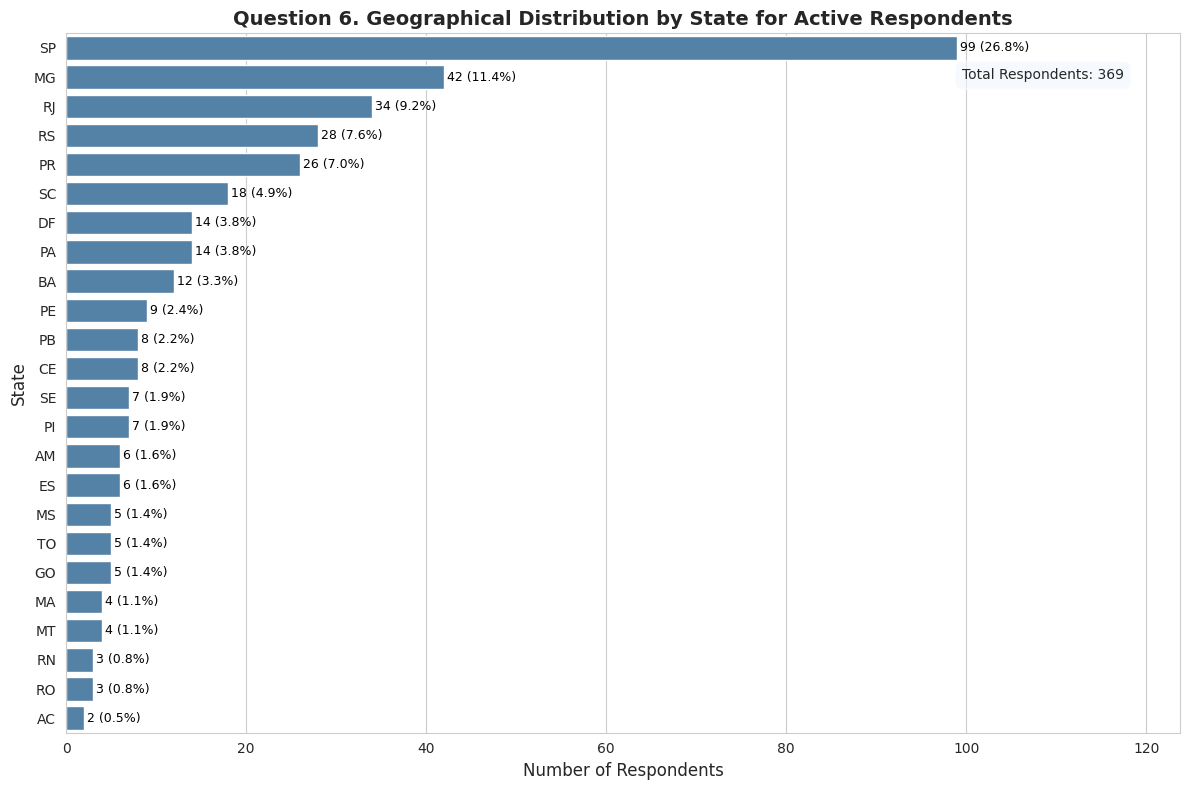

In [29]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_state(db_name):
    """
    Queries the database to get the state data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to join Respondents and SurveyAnswers to get the state
        # for all rows where 'Ativo' is True (1).
        query = """
        SELECT
          s."6. Estado"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded state data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of state.
    """
    state_df = get_active_respondent_state(DATABASE_NAME)
    
    if state_df is not None and not state_df.empty:
        # Rename the column for easier use and clearer outputs.
        state_df.rename(columns={'6. Estado': 'State'}, inplace=True)

        # --- NEW: Data Cleaning Step ---
        # Standardize state abbreviations to uppercase to handle inconsistencies like 'sp' vs 'SP'.
        # Also remove any leading/trailing whitespace.
        state_df['State'] = state_df['State'].str.strip().str.upper()
        
        # Drop any rows that might be empty after cleaning
        state_df.dropna(subset=['State'], inplace=True)
        state_df = state_df[state_df['State'] != '']


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for State (Cleaned) ---")
        print(state_df['State'].describe())
        
        print("\nFrequency Count (Cleaned):")
        print(state_df['State'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating State Distribution Plot ---")
        
        sns.set_style("whitegrid")
        # Adjusting figure size for potentially more categories
        plt.figure(figsize=(12, 8))
        
        ax = sns.countplot(
            data=state_df,
            y='State', # Use y-axis for better readability with many states
            color='steelblue', # Consistent color
            order = state_df['State'].value_counts().index # Order by frequency
        )
        
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.ylabel('State', fontsize=12)
        plt.title('Question 6. Geographical Distribution by State for Active Respondents', fontsize=14, fontweight='bold')
        
        total_respondents = len(state_df)
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        # Add more space at the right of the plot for labels
        max_width = state_df['State'].value_counts().max()
        ax.set_xlim(0, max_width * 1.25)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded religion data for active respondents.

--- Descriptive Statistics for Religion (Translated) ---
count             369
unique              7
top       Catholicism
freq              168
Name: Religion, dtype: object

Frequency Count (Translated):
Religion
Catholicism                     168
Spiritism                        61
No specific religion             56
Atheism/Agnosticism              33
Other Christians/Protestants     28
Afro-Brazilian Religions         13
Other/No answer                  10
Name: count, dtype: int64

--- Generating Religion Distribution Plot (Translated) ---


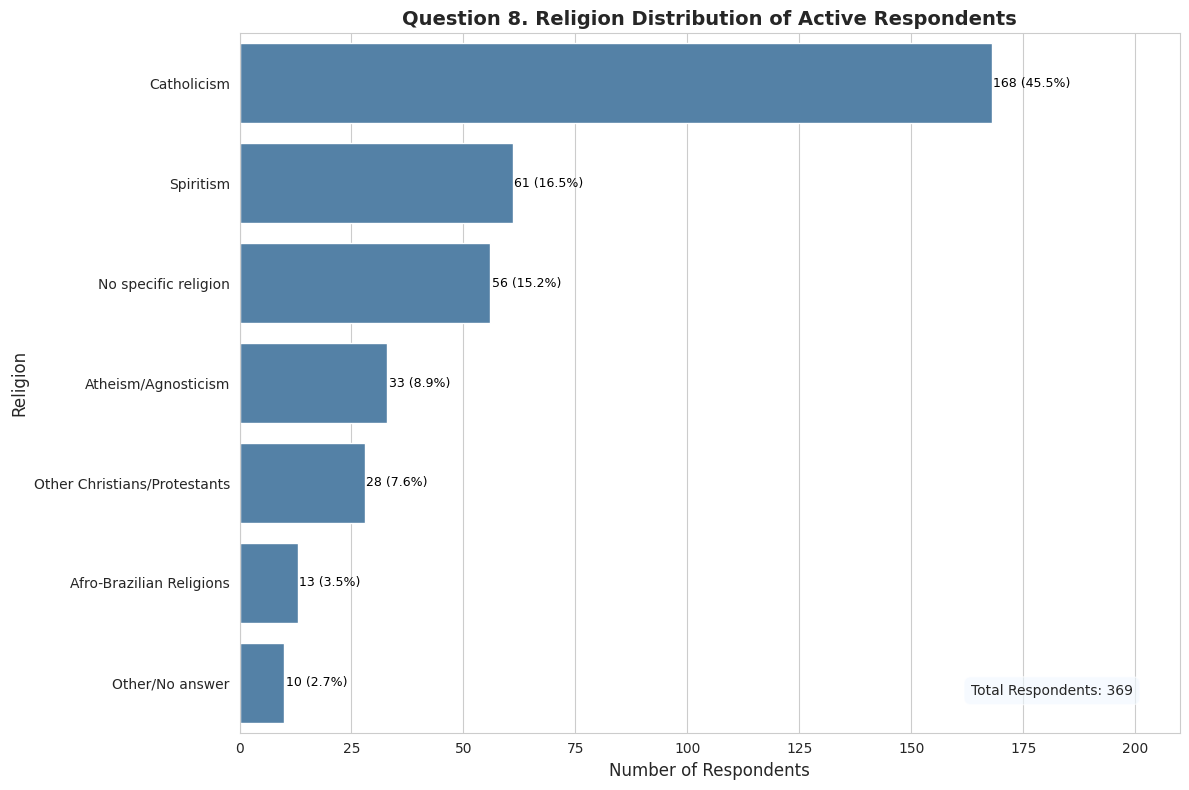

In [30]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_religion(db_name):
    """
    Queries the database to get the decoded religion for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to join Respondents, SurveyAnswers, and the Religions lookup table.
        # This gets the meaningful religion name for all active respondents.
        query = """
        SELECT
          rel.name AS Religion
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        JOIN
          Religions AS rel ON s."Religiao_codificado(8)" = rel.id
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded religion data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of religion.
    """
    religion_df = get_active_respondent_religion(DATABASE_NAME)
    
    if religion_df is not None and not religion_df.empty:
        
        # --- Data Translation Step ---
        translation_map = {
            'Ateismo/Agnosticismo': 'Atheism/Agnosticism',
            'Catolicismo': 'Catholicism',
            'Cristãos outros/protestantes/evangélicos': 'Other Christians/Protestants',
            'Espiritismo': 'Spiritism',
            'Não segue religião específica': 'No specific religion',
            'Outras/Não respondeu': 'Other/No answer',
            'Religiões Afrobrasileiras': 'Afro-Brazilian Religions'
        }
        religion_df['Religion'] = religion_df['Religion'].map(translation_map)

        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Religion (Translated) ---")
        print(religion_df['Religion'].describe())
        
        print("\nFrequency Count (Translated):")
        print(religion_df['Religion'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Religion Distribution Plot (Translated) ---")
        
        sns.set_style("whitegrid")
        # Using a taller figure for better readability with many categories
        plt.figure(figsize=(12, 8))
        
        ax = sns.countplot(
            data=religion_df,
            y='Religion', # Using y-axis for long labels
            color='steelblue', # Consistent color
            order = religion_df['Religion'].value_counts().index # Order by frequency
        )
        
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.ylabel('Religion', fontsize=12)
        plt.title('Question 8. Religion Distribution of Active Respondents', fontsize=14, fontweight='bold')
        
        total_respondents = len(religion_df)
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        # Add more space at the right of the plot for labels
        max_width = religion_df['Religion'].value_counts().max()
        ax.set_xlim(0, max_width * 1.25)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.05, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'Vinculo' data for active respondents.

--- Descriptive Statistics for Vinculo (Translated) ---
count     369
unique      2
top        No
freq      333
Name: Vinculo, dtype: object

Frequency Count (Translated):
Vinculo
No     333
Yes     36
Name: count, dtype: int64

--- Generating Vinculo Distribution Plot (Translated) ---


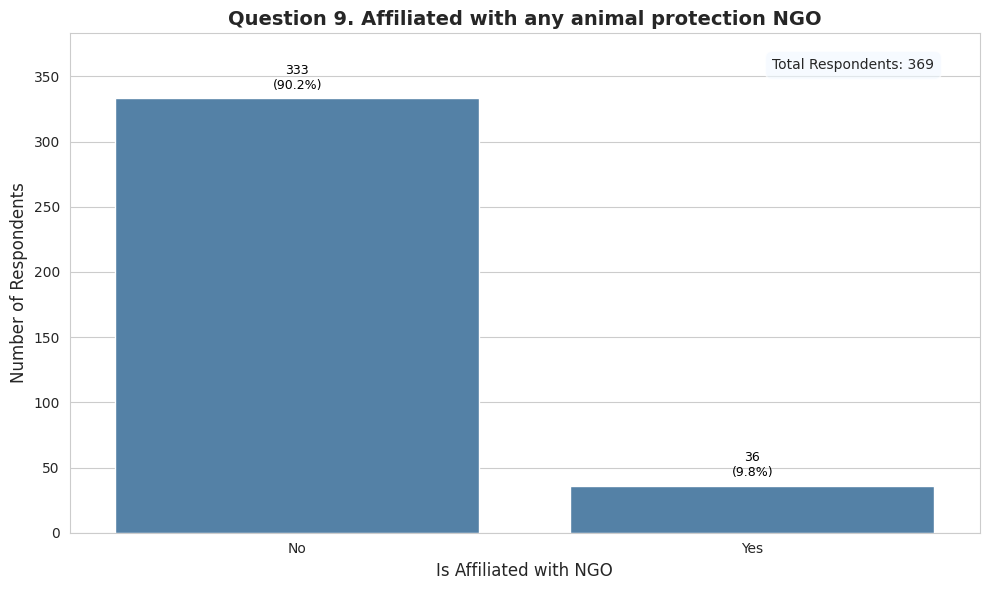

In [31]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_vinculo(db_name):
    """
    Queries the database to get the 'Vinculo' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to join Respondents and SurveyAnswers to get the 'Vinculo'
        # for all rows where 'Ativo' is True (1).
        query = """
        SELECT
          s."9. Vinculo"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Vinculo' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'Vinculo'.
    """
    vinculo_df = get_active_respondent_vinculo(DATABASE_NAME)
    
    if vinculo_df is not None and not vinculo_df.empty:
        # Rename the column for easier use and clearer outputs.
        vinculo_df.rename(columns={'9. Vinculo': 'Vinculo'}, inplace=True)

        # --- Data Translation Step ---
        # Create a dictionary to map Portuguese to English.
        translation_map = {
            'Sim': 'Yes',
            'Não': 'No'
        }
        # Apply the translation to the 'Vinculo' column.
        vinculo_df['Vinculo'] = vinculo_df['Vinculo'].map(translation_map)

        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Vinculo (Translated) ---")
        print(vinculo_df['Vinculo'].describe())
        
        print("\nFrequency Count (Translated):")
        print(vinculo_df['Vinculo'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Vinculo Distribution Plot (Translated) ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=vinculo_df,
            x='Vinculo',
            color='steelblue', # Consistent color
            order = vinculo_df['Vinculo'].value_counts().index # Order by frequency
        )
        
        plt.xlabel('Is Affiliated with NGO', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 9. Affiliated with any animal protection NGO', fontsize=14, fontweight='bold')
        
        total_respondents = len(vinculo_df)
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Add more space at the top of the plot
        max_height = vinculo_df['Vinculo'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


In [32]:
import pandas as pd
import sqlite3

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_raw_ngo_names(db_name):
    """
    Queries the database to get the raw NGO names for active respondents with a 'vinculo'.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get '10. Nome_da_ONG' for active respondents who answered 'Sim' to '9. Vinculo'.
        query = """
        SELECT
          s."10. Nome_da_ONG"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1 AND s."9. Vinculo" = 'Sim';
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded raw NGO name data.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to query and print the raw NGO names.
    """
    ngo_df = get_raw_ngo_names(DATABASE_NAME)
    
    if ngo_df is not None and not ngo_df.empty:
        # Rename the column for clarity.
        ngo_df.rename(columns={'10. Nome_da_ONG': 'RawNGOName'}, inplace=True)

        # --- Print the Raw Data ---
        print("\n--- Question 11. NGO Names as they appear in the database ---")
        # Use to_string() to ensure all names are printed without being cut off.
        # index=False and header=False makes for a clean, simple list.
        print(ngo_df['RawNGOName'].to_string(index=False, header=False))

if __name__ == '__main__':
    main()


Success: Loaded raw NGO name data.

--- Question 11. NGO Names as they appear in the database ---
                      ONG Sou Amigo - Coordenadora
                               AMAA - colaboradora
                                    Seres Viventes
                         SOS Animal - colaboradora
                                         Lar Oasis
                    Adote um Gatinho ( voluntaria)
                                          ALPA. RT
        Samb Sociedade Amor de Bicho 1a tesoureira
                                             Amada
       APAT - ASSOCIAÇÃO DE PROTEÃO ANIMAL DE TEFÉ
Associação Melhores Amigos dos Animais - Presid...
                                       Adota Patos
                                             KAOSA
                Viva Bichos, Defesa da Vida Animal
           Instituto Espaço Silvestre - Presidente
                                   ONG DEIXE VIVER
                                Refugio dos bichos
            ADA - Associação Defens

In [33]:
import pandas as pd
import sqlite3
from IPython.display import display, HTML

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def generate_html_table(name_list):
    """
    Generates an HTML string for a styled table from a list of names.
    """
    # Sort the list alphabetically
    name_list.sort()
    
    # Build the HTML for the table rows
    table_rows = ""
    for i, name in enumerate(name_list):
        # Alternate row colors for readability
        row_class = "bg-gray-50" if i % 2 != 0 else ""
        table_rows += f"""
        <tr class="{row_class}">
            <td class="px-6 py-4 whitespace-nowrap text-sm font-medium text-gray-900">{i + 1}</td>
            <td class="px-6 py-4 whitespace-nowrap text-sm text-gray-700">{name}</td>
        </tr>
        """

    # The full HTML structure
    full_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>NGO Names List</title>
        <script src="https://cdn.tailwindcss.com"></script>
        <style> body {{ font-family: 'Inter', sans-serif; }} </style>
    </head>
    <body class="bg-gray-100 text-gray-800">
        <div class="container mx-auto p-4 sm:p-6 lg:p-8">
            <div class="bg-white rounded-2xl shadow-lg overflow-hidden">
                <div class="p-6 border-b border-gray-200">
                    <h1 class="text-2xl font-bold text-gray-900">NGO Affiliations of Respondents</h1>
                    <p class="mt-1 text-sm text-gray-600">A cleaned, alphabetized list of unique NGO names provided in the survey.</p>
                </div>
                <div class="overflow-x-auto">
                    <table class="min-w-full divide-y divide-gray-200">
                        <thead class="bg-gray-50">
                            <tr>
                                <th scope="col" class="px-6 py-3 text-left text-xs font-medium text-gray-500 uppercase tracking-wider w-16">#</th>
                                <th scope="col" class="px-6 py-3 text-left text-xs font-medium text-gray-500 uppercase tracking-wider">NGO Name</th>
                            </tr>
                        </thead>
                        <tbody class="bg-white divide-y divide-gray-200">
                            {table_rows}
                        </tbody>
                    </table>
                </div>
            </div>
        </div>
    </body>
    </html>
    """
    return full_html

def main():
    """
    Main function to display the curated list of NGO names.
    """

    cleaned_ngo_names = [
        "Ada - Associação Defensora Dos Animais", "Adota Patos", "Adote Um Gatinho", "Alpa", "Amacap", "Amada",
        "Ampara", "Amaa", "Apat - Associação De Proteão Animal De Tefé", "Apata",
        "Associação Defensora Dos Animais São Francisco De Assis (Adasfa)", "Associação Melhores Amigos Dos Animais",
        "Associação Ouropretana De Proteção Animal", "Santuário Anjos De Assis", "Desabandone", "Forum Animal", "Gaar",
        "Instituto Espaço Silvestre", "Instituto Flora Vida", "Kaosa", "Lar Oasis", "Ong Animais Da Aldeia",
        "Ong Sou Amigo", "Pastoral De Protetores", "Refugio Dos Bichos", "Samb Sociedade Amor De Bicho",
        "Seres Viventes", "Sos Animais De Rua", "Sos Animal", "Sos Bichinho", "Sospet", "Upap", "Viva Bichos"
    ]
    
    # Generate the HTML table from our perfect list
    html_output = generate_html_table(cleaned_ngo_names)
    
    # Display the HTML in the Jupyter output
    display(HTML(html_output))

if __name__ == '__main__':
    main()


#,NGO Name
1,Ada - Associação Defensora Dos Animais
2,Adota Patos
3,Adote Um Gatinho
4,Alpa
5,Amaa
6,Amacap
7,Amada
8,Ampara
9,Apat - Associação De Proteão Animal De Tefé
10,Apata


Success: Loaded unified CEUA name data for active respondents.

Total number of unique CEUAs found: 232

--- Generating Top 20 Unified CEUA Name Distribution Plot ---


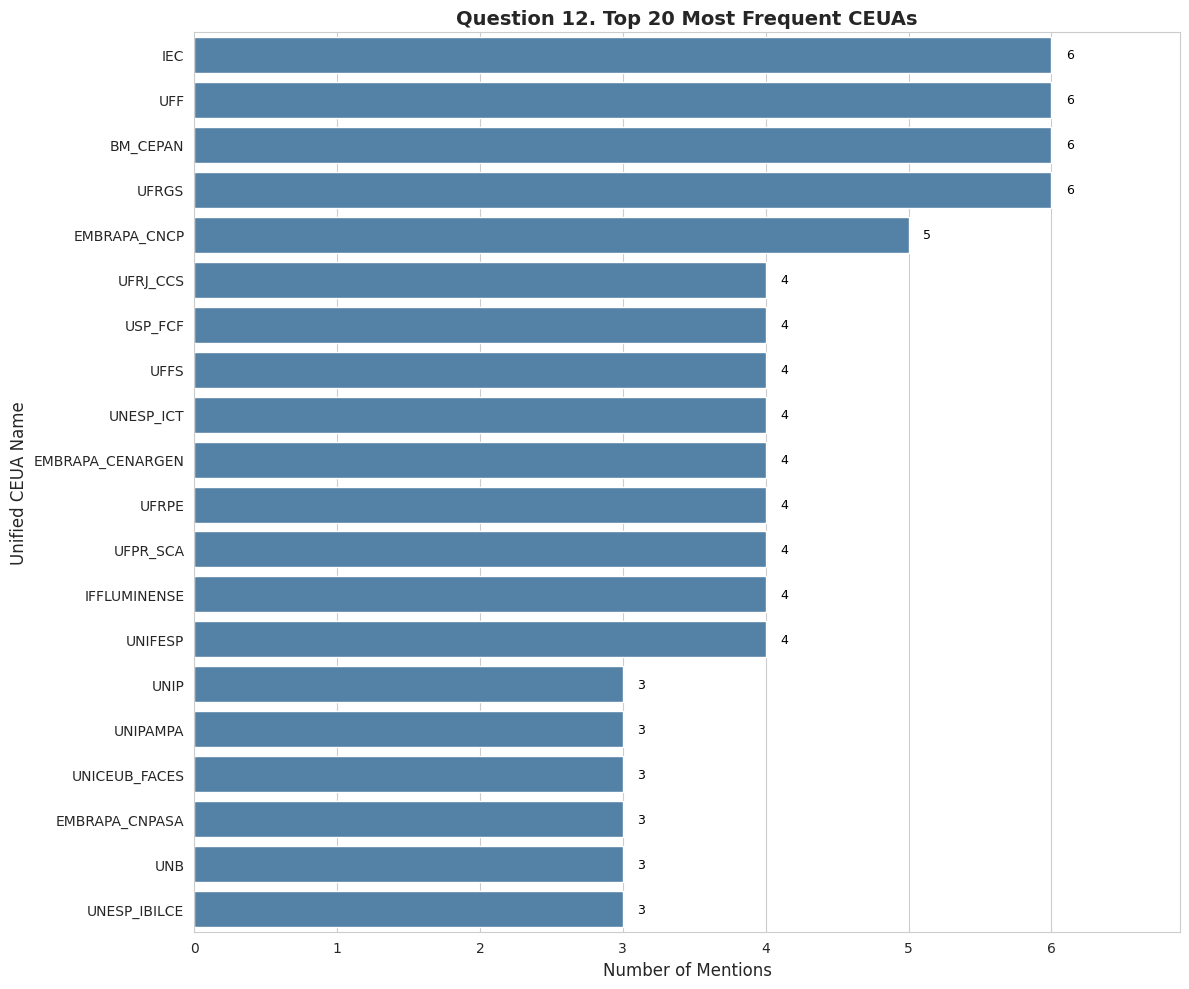

In [34]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_ceua_names(db_name):
    """
    Queries the database to get the unified CEUA names for active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # Querying the correct 'CEUA_unificada(11)' column now.
        query = """
        SELECT
          s."CEUA_unificada(11)"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded unified CEUA name data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of the Top 20 unified CEUA names.
    """
    ceua_df = get_active_respondent_ceua_names(DATABASE_NAME)
    
    if ceua_df is not None and not ceua_df.empty:
        # Renaming the correct column.
        ceua_df.rename(columns={'CEUA_unificada(11)': 'CEUAName'}, inplace=True)

        # --- Data Cleaning ---
        # MODIFIED: Changed to .upper() for acronyms.
        ceua_df['CEUAName'] = ceua_df['CEUAName'].str.strip().str.upper()
        # Filter out any empty or non-descriptive entries like 'N/A' or 'CEUA'
        ceua_df = ceua_df[~ceua_df['CEUAName'].isin(['', 'N/A', 'CEUA'])].dropna()

        # --- ADDED: Print full frequency count and total unique count before plotting ---
        all_ceua_counts = ceua_df['CEUAName'].value_counts()
        
        # Explicitly print the total number of unique CEUAs.
        print(f"\nTotal number of unique CEUAs found: {len(all_ceua_counts)}")

        #print("\n--- Full Frequency Count of All Unified CEUA Names ---")
        #with pd.option_context('display.max_rows', None):  # Ensures the full list is printed
        #    print(all_ceua_counts)
        # --- END of ADDED section ---

        # --- 1. Get Top 20 ---
        # Calculate frequencies and select the top 20
        top_20_ceuas = ceua_df['CEUAName'].value_counts().nlargest(20)
        top_20_df = top_20_ceuas.reset_index()
        top_20_df.columns = ['CEUAName', 'Count']

        # --- 2. Plotting the Data ---
        print("\n--- Generating Top 20 Unified CEUA Name Distribution Plot ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 10))
        
        ax = sns.barplot(
            data=top_20_df,
            y='CEUAName',
            x='Count',
            color='steelblue',
            orient='h'
        )
        
        plt.xlabel('Number of Mentions', fontsize=12)
        plt.ylabel('Unified CEUA Name', fontsize=12)
        plt.title('Question 12. Top 20 Most Frequent CEUAs', fontsize=14, fontweight='bold')
        
        # Add count labels to the bars.
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                label = f'{int(width)}'
                ax.text(width + 0.1, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        max_width = top_20_df['Count'].max()
        ax.set_xlim(0, max_width * 1.15)
        
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()



Success: Loaded raw institution name data.

--- Generating Top 20 Cleaned Institution Name Distribution Plot ---


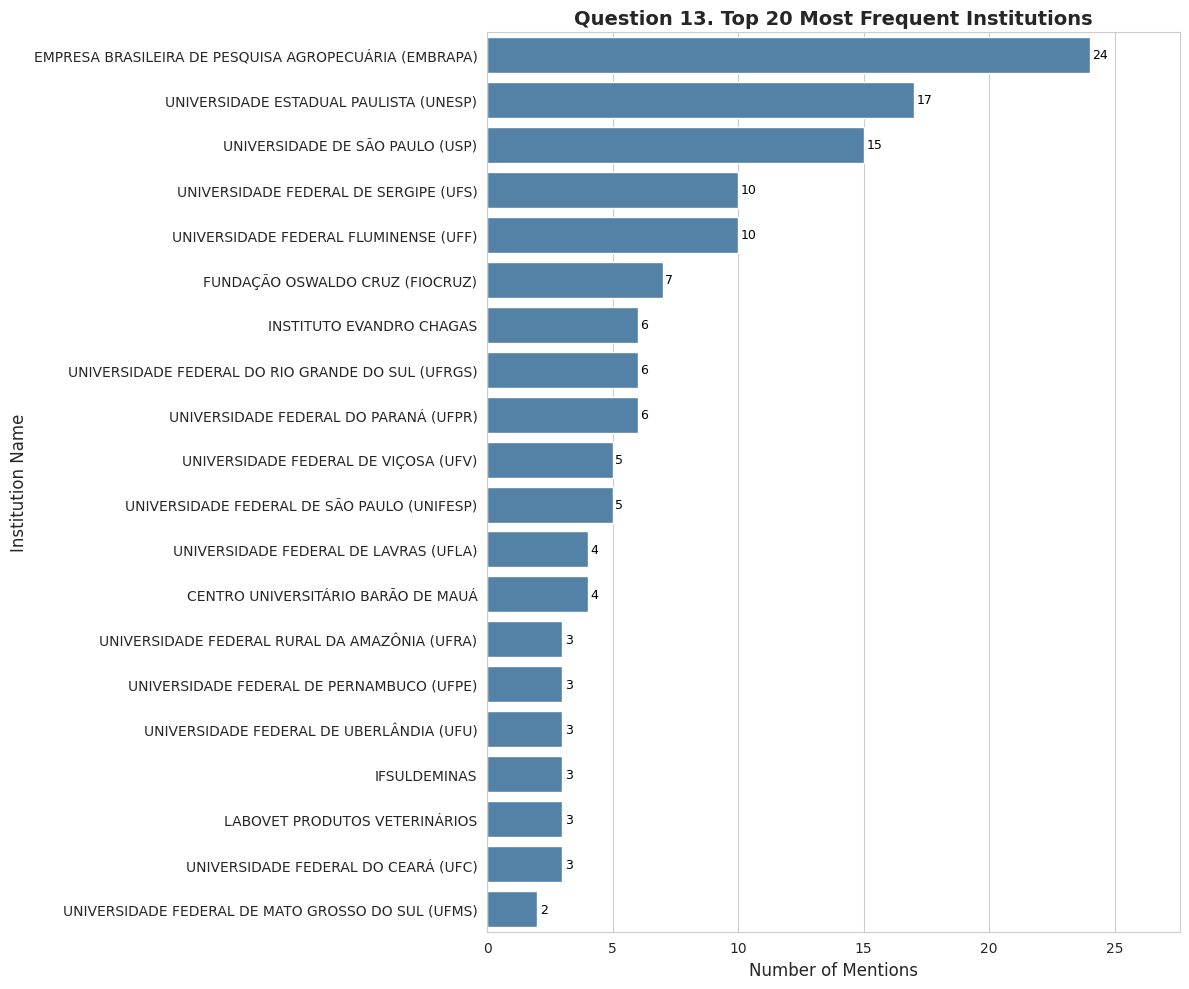

In [35]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_raw_institution_names(db_name):
    """
    Queries the database to get the raw institution names for active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."12. Instituicao"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded raw institution name data.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def clean_and_group_institution(name):
    """
    Applies a more robust and intelligent set of rules to clean and group institution names.
    """
    if pd.isna(name) or name.strip() == '':
        return None
    
    # Standardize to uppercase and remove extra spaces
    name_upper = name.strip().upper()
    
    # --- Comprehensive Grouping Rules (Order is important) ---
    # Major Research Institutions
    if 'EMBRAPA' in name_upper: return 'EMPRESA BRASILEIRA DE PESQUISA AGROPECUÁRIA (EMBRAPA)'
    if 'FIOCRUZ' in name_upper or 'OSWALDO CRUZ' in name_upper: return 'FUNDAÇÃO OSWALDO CRUZ (FIOCRUZ)'
    if 'BUTANTAN' in name_upper: return 'INSTITUTO BUTANTAN'
    if 'EVANDRO CHAGAS' in name_upper: return 'INSTITUTO EVANDRO CHAGAS'

    # University Acronym Expansion (Specific Rules First)
    if 'UFABC' in name_upper: return 'UNIVERSIDADE FEDERAL DO ABC (UFABC)'
    if 'UFAC' in name_upper: return 'UNIVERSIDADE FEDERAL DO ACRE (UFAC)'
    if 'UFAL' in name_upper: return 'UNIVERSIDADE FEDERAL DE ALAGOAS (UFAL)'
    if 'UFAM' in name_upper: return 'UNIVERSIDADE FEDERAL DO AMAZONAS (UFAM)'
    if 'UFBA' in name_upper: return 'UNIVERSIDADE FEDERAL DA BAHIA (UFBA)'
    if 'UFC' in name_upper: return 'UNIVERSIDADE FEDERAL DO CEARÁ (UFC)'
    if 'UFCG' in name_upper: return 'UNIVERSIDADE FEDERAL DE CAMPINA GRANDE (UFCG)'
    if 'UFERSA' in name_upper: return 'UNIVERSIDADE FEDERAL RURAL DO SEMI-ÁRIDO (UFERSA)'
    if 'UFES' in name_upper: return 'UNIVERSIDADE FEDERAL DO ESPÍRITO SANTO (UFES)'
    if 'UFF' in name_upper or 'FLUMINENSE' in name_upper: return 'UNIVERSIDADE FEDERAL FLUMINENSE (UFF)'
    if 'UFFS' in name_upper: return 'UNIVERSIDADE FEDERAL DA FRONTEIRA SUL (UFFS)'
    if 'UFG' in name_upper: return 'UNIVERSIDADE FEDERAL DE GOIÁS (UFG)'
    if 'UFGD' in name_upper: return 'UNIVERSIDADE FEDERAL DA GRANDE DOURADOS (UFGD)'
    if 'UFLA' in name_upper or 'LAVRAS' in name_upper: return 'UNIVERSIDADE FEDERAL DE LAVRAS (UFLA)'
    if 'UFMG' in name_upper: return 'UNIVERSIDADE FEDERAL DE MINAS GERAIS (UFMG)'
    if 'UFMS' in name_upper: return 'UNIVERSIDADE FEDERAL DE MATO GROSSO DO SUL (UFMS)'
    if 'UFMT' in name_upper: return 'UNIVERSIDADE FEDERAL DE MATO GROSSO (UFMT)'
    if 'UFPA' in name_upper: return 'UNIVERSIDADE FEDERAL DO PARÁ (UFPA)'
    if 'UFPB' in name_upper: return 'UNIVERSIDADE FEDERAL DA PARAÍBA (UFPB)'
    if 'UFPE' in name_upper or 'PERNAMBUCO' in name_upper and 'FEDERAL' in name_upper: return 'UNIVERSIDADE FEDERAL DE PERNAMBUCO (UFPE)'
    if 'UFPI' in name_upper: return 'UNIVERSIDADE FEDERAL DO PIAUÍ (UFPI)'
    if 'UFPR' in name_upper or 'PARANÁ' in name_upper and 'FEDERAL' in name_upper: return 'UNIVERSIDADE FEDERAL DO PARANÁ (UFPR)'
    if 'UFRA' in name_upper: return 'UNIVERSIDADE FEDERAL RURAL DA AMAZÔNIA (UFRA)'
    if 'UFRB' in name_upper: return 'UNIVERSIDADE FEDERAL DO RECÔNCAVO DA BAHIA (UFRB)'
    if 'UFRGS' in name_upper: return 'UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL (UFRGS)'
    if 'UFRJ' in name_upper: return 'UNIVERSIDADE FEDERAL DO RIO DE JANEIRO (UFRJ)'
    if 'UFRN' in name_upper: return 'UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE (UFRN)'
    if 'UFRPE' in name_upper: return 'UNIVERSIDADE FEDERAL RURAL DE PERNAMBUCO (UFRPE)'
    if 'UFRRJ' in name_upper: return 'UNIVERSIDADE FEDERAL RURAL DO RIO DE JANEIRO (UFRRJ)'
    if 'UFS' in name_upper or 'SERGIPE' in name_upper and 'FEDERAL' in name_upper: return 'UNIVERSIDADE FEDERAL DE SERGIPE (UFS)'
    if 'UFSC' in name_upper: return 'UNIVERSIDADE FEDERAL DE SANTA CATARINA (UFSC)'
    if 'UFSCAR' in name_upper: return 'UNIVERSIDADE FEDERAL DE SÃO CARLOS (UFSCAR)'
    if 'UFT' in name_upper: return 'UNIVERSIDADE FEDERAL DO TOCANTINS (UFT)'
    if 'UFTM' in name_upper: return 'UNIVERSIDADE FEDERAL DO TRIÂNGULO MINEIRO (UFTM)'
    if 'UFU' in name_upper or 'UBERLÂNDIA' in name_upper: return 'UNIVERSIDADE FEDERAL DE UBERLÂNDIA (UFU)'
    if 'UFV' in name_upper or 'VIÇOSA' in name_upper: return 'UNIVERSIDADE FEDERAL DE VIÇOSA (UFV)'
    if 'UFVJM' in name_upper: return 'UNIVERSIDADE FEDERAL DOS VALES DO JEQUITINHONHA E MUCURI (UFVJM)'
    if 'UNB' in name_upper or 'BRASILIA' in name_upper and 'UNIVERSIDADE' in name_upper: return 'UNIVERSIDADE DE BRASÍLIA (UNB)'
    if 'UNESP' in name_upper or 'ESTADUAL PAULISTA' in name_upper: return 'UNIVERSIDADE ESTADUAL PAULISTA (UNESP)'
    if 'UNIFESP' in name_upper or 'SÃO PAULO' in name_upper and 'FEDERAL' in name_upper: return 'UNIVERSIDADE FEDERAL DE SÃO PAULO (UNIFESP)'
    if 'USP' in name_upper or 'SÃO PAULO' in name_upper and 'UNIVERSIDADE DE' in name_upper: return 'UNIVERSIDADE DE SÃO PAULO (USP)'
    
    # Private Companies & Other Institutions
    if 'BIOAGRI' in name_upper: return 'BIOAGRI LABORATÓRIOS'
    if 'GRANDFOOD' in name_upper: return 'GRANDFOOD'
    if 'DECHRA' in name_upper: return 'DECHRA BRASIL'
    if 'LABOVET' in name_upper: return 'LABOVET PRODUTOS VETERINÁRIOS'
    if 'EINSTEIN' in name_upper: return 'HOSPITAL ISRAELITA ALBERT EINSTEIN'
    if 'SÍRIO-LIBANÊS' in name_upper: return 'HOSPITAL SÍRIO-LIBANÊS'
    if 'AC CAMARGO' in name_upper: return 'AC CAMARGO CANCER CENTER'
    if 'HOSPITAL DE CLÍNICAS DE PORTO ALEGRE' in name_upper: return 'HOSPITAL DE CLÍNICAS DE PORTO ALEGRE'

    # If no specific rule matches, return the cleaned name
    return name_upper

def main():
    """
    Main function to query, clean, and plot the top 20 institution names.
    """
    institution_df = get_raw_institution_names(DATABASE_NAME)
    
    if institution_df is not None and not institution_df.empty:
        institution_df.rename(columns={'12. Instituicao': 'RawInstitutionName'}, inplace=True)

        # Apply the enhanced cleaning and grouping function
        institution_df['CleanedName'] = institution_df['RawInstitutionName'].apply(clean_and_group_institution)
        
        # --- Sanity Check (Commented Out) ---
        # This section can be uncommented to print the full list of cleaned names
        # for verification purposes.
        # unique_cleaned_names = sorted(institution_df['CleanedName'].dropna().unique())
        # print("\n--- Full List of Cleaned, Grouped, and Alphabetized Institutions ---")
        # for name in unique_cleaned_names:
        #     print(name)
        
        # --- Get Top 20 ---
        top_20_institutions = institution_df['CleanedName'].dropna().value_counts().nlargest(20)
        top_20_df = top_20_institutions.reset_index()
        top_20_df.columns = ['InstitutionName', 'Count']

        # --- Plotting the Data ---
        print("\n--- Generating Top 20 Cleaned Institution Name Distribution Plot ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 10))
        
        ax = sns.barplot(
            data=top_20_df,
            y='InstitutionName',
            x='Count',
            color='steelblue',
            orient='h'
        )
        
        plt.xlabel('Number of Mentions', fontsize=12)
        plt.ylabel('Institution Name', fontsize=12)
        plt.title('Question 13. Top 20 Most Frequent Institutions', fontsize=14, fontweight='bold')
        
        # Add count labels to the bars.
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                label = f'{int(width)}'
                ax.text(width + 0.1, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        max_width = top_20_df['Count'].max()
        ax.set_xlim(0, max_width * 1.15)
        
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'Natureza_Inst' data for active respondents.

--- Descriptive Statistics for Institution Nature (Translated) ---
count        369
unique         4
top       Public
freq         249
Name: InstitutionNature, dtype: object

Frequency Count (Translated):
InstitutionNature
Public          249
Private         102
Commercial       17
Not Informed      1
Name: count, dtype: int64

--- Generating Institution Nature Distribution Plot (Translated) ---


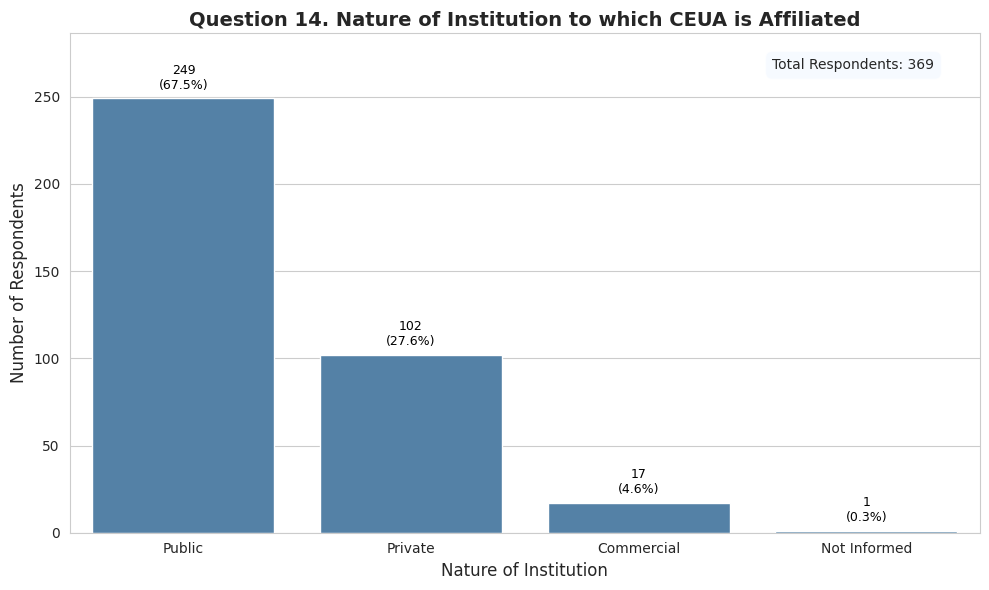

In [36]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_nature(db_name):
    """
    Queries the database to get the 'Natureza_Inst' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to join Respondents and SurveyAnswers to get the 'Natureza_Inst'
        # for all rows where 'Ativo' is True (1).
        query = """
        SELECT
          s."14. Natureza_Inst"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Natureza_Inst' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'Natureza_Inst'.
    """
    nature_df = get_active_respondent_nature(DATABASE_NAME)
    
    if nature_df is not None and not nature_df.empty:
        # Rename the column for easier use and clearer outputs.
        nature_df.rename(columns={'14. Natureza_Inst': 'InstitutionNature'}, inplace=True)

        # --- Data Cleaning ---
        nature_df['InstitutionNature'] = nature_df['InstitutionNature'].str.strip()
        nature_df.dropna(subset=['InstitutionNature'], inplace=True)
        nature_df = nature_df[nature_df['InstitutionNature'] != '']
        
        # --- Data Translation Step ---
        # CORRECTED: This map now matches the actual data values.
        translation_map = {
            'Pública': 'Public',
            'Privada': 'Private',
            'Comercial': 'Commercial',
            'Não Informou': 'Not Informed'
        }
        nature_df['InstitutionNature'] = nature_df['InstitutionNature'].map(translation_map)
        
        # --- 1. Descriptive Statistics (on Translated Data) ---
        print("\n--- Descriptive Statistics for Institution Nature (Translated) ---")
        print(nature_df['InstitutionNature'].describe())
        
        print("\nFrequency Count (Translated):")
        print(nature_df['InstitutionNature'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Institution Nature Distribution Plot (Translated) ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=nature_df,
            x='InstitutionNature',
            color='steelblue', # Consistent color
            order = nature_df['InstitutionNature'].value_counts().index # Order by frequency
        )
        
        plt.xlabel('Nature of Institution', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        # Corrected and numbered title
        plt.title('Question 14. Nature of Institution to which CEUA is Affiliated', fontsize=14, fontweight='bold')
        
        total_respondents = len(nature_df)
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Add more space at the top of the plot
        max_height = nature_df['InstitutionNature'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()



Success: Loaded 'Representante_SPA' data for active respondents.

--- Descriptive Statistics for SPA Representative (Translated) ---
count                          369
unique                           4
top       Yes, only titular member
freq                           137
Name: SPARepresentative, dtype: object

Frequency Count (Translated):
SPARepresentative
Yes, only titular member       137
Yes, titular and substitute    120
No SPA representative           76
Don't know                      36
Name: count, dtype: int64

--- Generating SPA Representative Distribution Plot (Translated) ---


/tmp/ipykernel_96998/4221084812.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels)


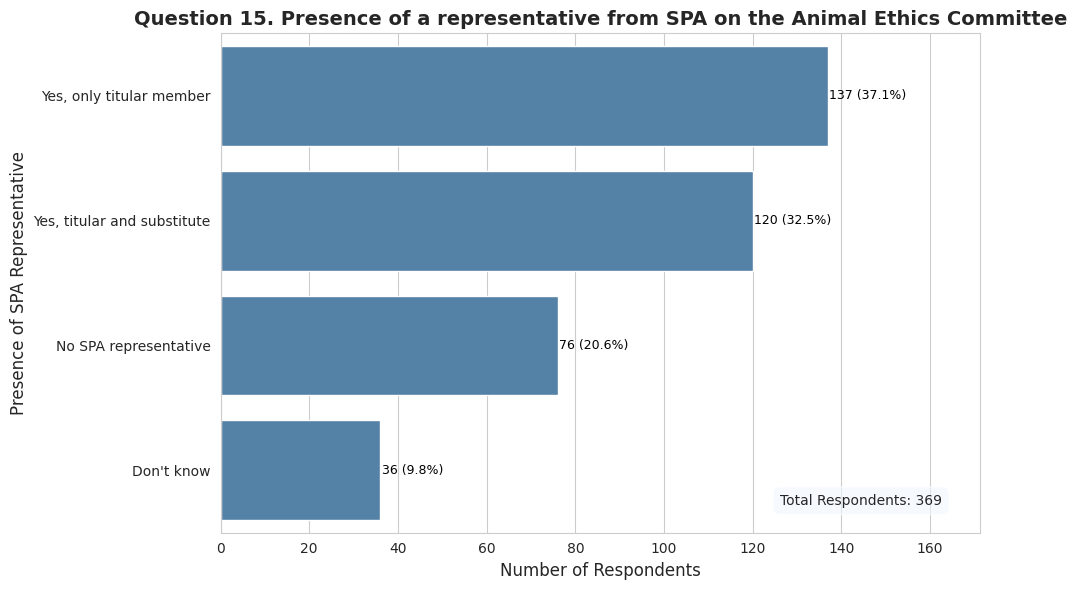

In [37]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_spa_rep(db_name):
    """
    Queries the database to get the 'Representante_SPA' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get '15. Representante_SPA' for active respondents.
        query = """
        SELECT
          s."15. Representante_SPA"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Representante_SPA' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'Representante_SPA'.
    """
    spa_rep_df = get_active_respondent_spa_rep(DATABASE_NAME)
    
    if spa_rep_df is not None and not spa_rep_df.empty:
        # Rename the column for easier use and clearer outputs.
        spa_rep_df.rename(columns={'15. Representante_SPA': 'SPARepresentative'}, inplace=True)

        # --- Data Cleaning ---
        spa_rep_df['SPARepresentative'] = spa_rep_df['SPARepresentative'].str.strip()
        spa_rep_df.dropna(subset=['SPARepresentative'], inplace=True)
        spa_rep_df = spa_rep_df[spa_rep_df['SPARepresentative'] != '']
        
        # --- Data Translation Step ---
        translation_map = {
            'Sim, apenas titular': 'Yes, only titular member',
            'Sim, titular e suplente': 'Yes, titular and substitute',
            'Não há representante da sociedade protetora de animais': 'No SPA representative',
            'Não sei dizer': "Don't know"
        }
        spa_rep_df['SPARepresentative'] = spa_rep_df['SPARepresentative'].map(translation_map)
        
        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for SPA Representative (Translated) ---")
        print(spa_rep_df['SPARepresentative'].describe())
        
        print("\nFrequency Count (Translated):")
        print(spa_rep_df['SPARepresentative'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating SPA Representative Distribution Plot (Translated) ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        # Get the order of categories by frequency
        order = spa_rep_df['SPARepresentative'].value_counts().index
        
        ax = sns.countplot(
            data=spa_rep_df,
            y='SPARepresentative', # Use y-axis for long labels
            color='steelblue', # Consistent color
            order=order
        )
        
        # Create a list of wrapped labels corresponding to the plot order
        wrapped_labels = ['\n'.join(textwrap.wrap(label, width=30)) for label in order]
        ax.set_yticklabels(wrapped_labels)
        
        plt.ylabel('Presence of SPA Representative', fontsize=12)
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.title('Question 15. Presence of a representative from SPA on the Animal Ethics Committee', fontsize=14, fontweight='bold')
        
        total_respondents = len(spa_rep_df)
        
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        max_width = spa_rep_df['SPARepresentative'].value_counts().max()
        ax.set_xlim(0, max_width * 1.25)
        
        # MODIFICATION: Moved the text box to the bottom-right corner to avoid overlap.
        ax.text(0.95, 0.05, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'Quant_membros_CEUA' data for active respondents.

--- Descriptive Statistics for CEUA Member Count ---
count                   369
unique                    5
top       Between 10 and 14
freq                    161
Name: MemberCount, dtype: object

Frequency Count:
MemberCount
Between 10 and 14    161
Between 5 and 9       88
Between 15 and 19     67
20 or more            36
Don't know            17
Name: count, dtype: int64

--- Generating CEUA Member Count Distribution Plot ---


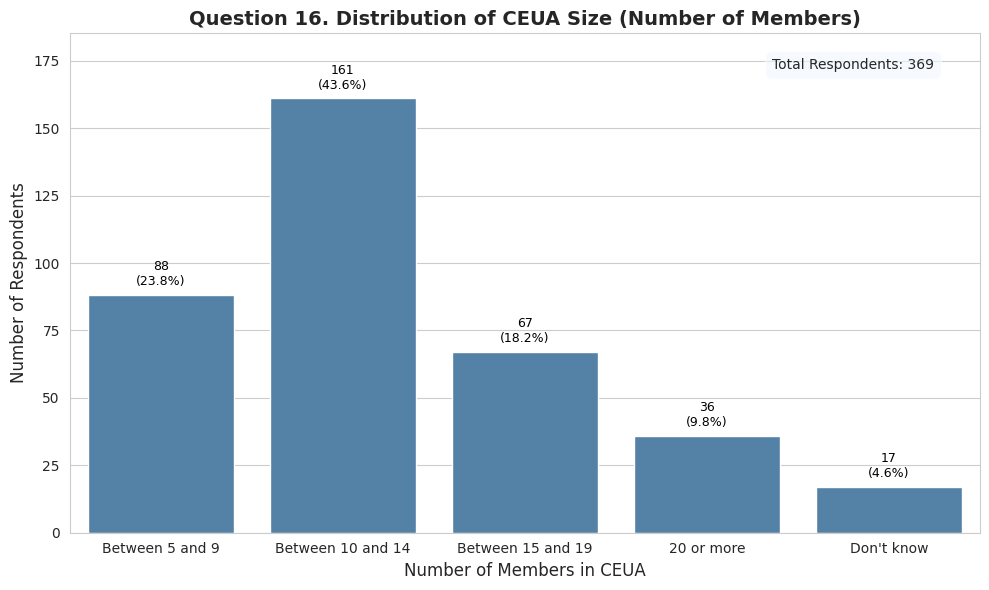

In [38]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_members(db_name):
    """
    Queries the database to get the 'Quant_membros_CEUA' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to join Respondents and SurveyAnswers to get the number of members
        # for all rows where 'Ativo' is True (1).
        query = """
        SELECT
          s."16. Quant_membros_CEUA"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Quant_membros_CEUA' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'Quant_membros_CEUA'.
    """
    members_df = get_active_respondent_members(DATABASE_NAME)
    
    if members_df is not None and not members_df.empty:
        # Rename the column for easier use and clearer outputs.
        members_df.rename(columns={'16. Quant_membros_CEUA': 'MemberCount'}, inplace=True)

        # --- Data Translation Step ---
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Entre 5 e 9': 'Between 5 and 9',
            'Entre 10 e 14': 'Between 10 and 14',
            'Entre 15 e 19': 'Between 15 and 19',
            '20 ou mais': '20 or more',
            'Não sei dizer': "Don't know"
        }
        members_df['MemberCount'] = members_df['MemberCount'].replace(translation_map)


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for CEUA Member Count ---")
        # Describe the original data before translation for accurate representation
        print(members_df['MemberCount'].describe())
        
        print("\nFrequency Count:")
        print(members_df['MemberCount'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating CEUA Member Count Distribution Plot ---")
        
        # Define the desired order for the English categories
        category_order = [
            'Between 5 and 9',
            'Between 10 and 14',
            'Between 15 and 19',
            '20 or more',
            "Don't know"
        ]
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=members_df,
            x='MemberCount',
            color='steelblue', # Consistent color
            order=category_order
        )
        
        plt.xlabel('Number of Members in CEUA', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 16. Distribution of CEUA Size (Number of Members)', fontsize=14, fontweight='bold')
        
        total_respondents = len(members_df['MemberCount'].dropna())
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Add more space at the top of the plot
        max_height = members_df['MemberCount'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'No_licencas_recusadas' data for active respondents.

--- Descriptive Statistics for Number of Licenses Refused ---
count            369
unique            13
top       Don't know
freq             135
Name: LicensesRefused, dtype: object

Frequency Count:
LicensesRefused
Don't know           135
0                     81
1                     23
Between 10 and 14     22
2                     21
3                     21
20 or more            20
4                     15
6                     14
5                     10
Between 15 and 19      4
7                      2
8                      1
Name: count, dtype: int64

--- Generating Licenses Refused Distribution Plot ---


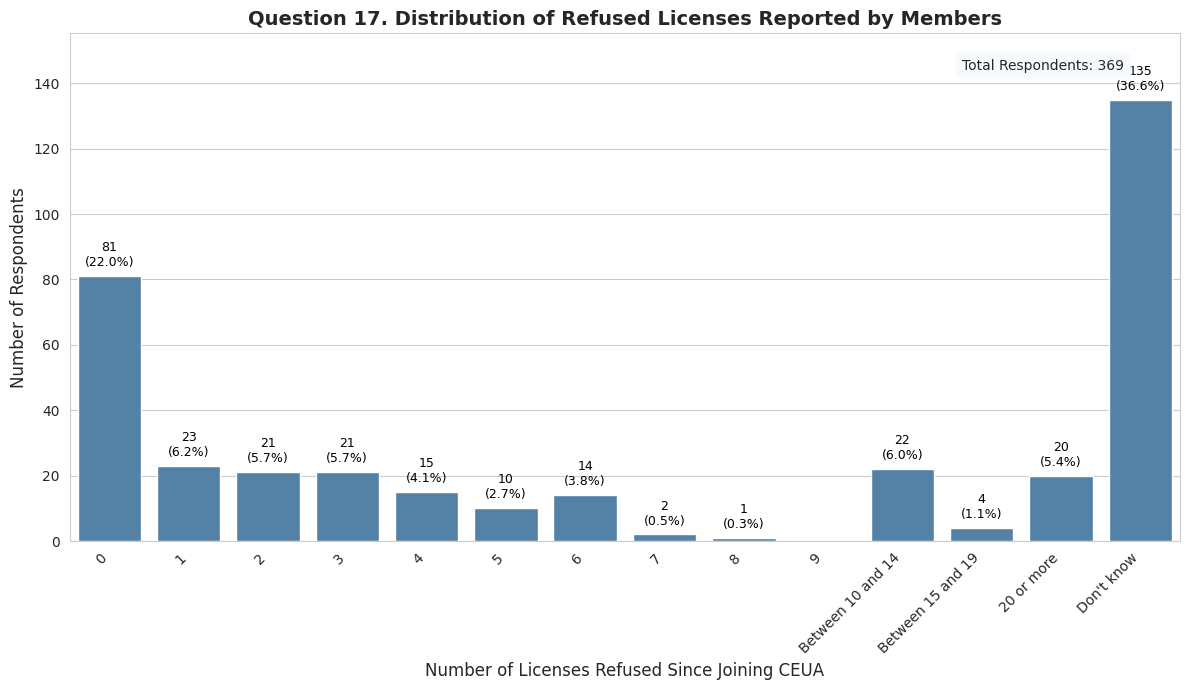

In [39]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_licenses_refused(db_name):
    """
    Queries the database to get the 'No_licencas_recusadas' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get the number of refused licenses for active respondents.
        query = """
        SELECT
          s."17. No_licencas_recusadas"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'No_licencas_recusadas' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'No_licencas_recusadas'.
    """
    licenses_df = get_active_respondent_licenses_refused(DATABASE_NAME)
    
    if licenses_df is not None and not licenses_df.empty:
        # Rename the column for easier use.
        licenses_df.rename(columns={'17. No_licencas_recusadas': 'LicensesRefused'}, inplace=True)

        # --- Data Translation Step ---
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Entre 10 e 14': 'Between 10 and 14',
            'Entre 15 e 19': 'Between 15 and 19',
            '20 ou mais': '20 or more',
            'Não sei dizer': "Don't know"
        }
        # Note: The numeric values ('0', '1', etc.) do not need translation.
        licenses_df['LicensesRefused'] = licenses_df['LicensesRefused'].replace(translation_map)


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Number of Licenses Refused ---")
        print(licenses_df['LicensesRefused'].describe())
        
        print("\nFrequency Count:")
        print(licenses_df['LicensesRefused'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Licenses Refused Distribution Plot ---")
        
        # Define the logical order for the categories on the plot's x-axis.
        category_order = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'Between 10 and 14', 'Between 15 and 19', '20 or more', "Don't know"
        ]
        
        sns.set_style("whitegrid")
        # Increase figure size for better readability of x-axis labels.
        plt.figure(figsize=(12, 7))
        
        ax = sns.countplot(
            data=licenses_df,
            x='LicensesRefused',
            color='steelblue',
            order=category_order
        )
        
        plt.xlabel('Number of Licenses Refused Since Joining CEUA', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 17. Distribution of Refused Licenses Reported by Members', fontsize=14, fontweight='bold')
        # Rotate labels to prevent overlap.
        plt.xticks(rotation=45, ha='right')
        
        total_respondents = len(licenses_df['LicensesRefused'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Adjust top margin to ensure labels fit.
        max_height = licenses_df['LicensesRefused'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'No_consultores_adhoc' data for active respondents.

--- Descriptive Statistics for Number of Ad-hoc Consultants Used ---
count     369
unique     14
top         0
freq      141
Name: AdHocConsultants, dtype: object

Frequency Count:
AdHocConsultants
0                    141
Don't know           116
2                     34
1                     23
20 or more            17
3                     15
5                      7
Between 10 and 14      4
8                      3
6                      2
4                      2
9                      2
Between 15 and 19      2
7                      1
Name: count, dtype: int64

--- Generating Ad-hoc Consultant Use Distribution Plot ---


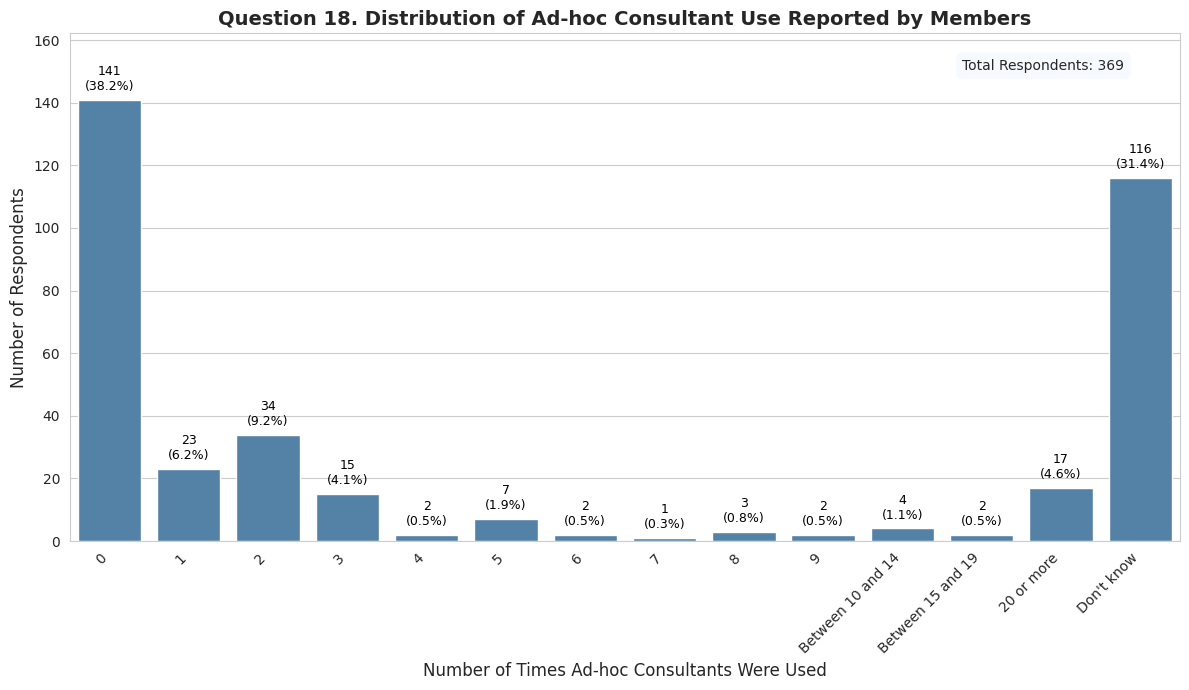

In [40]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_adhoc_consultants(db_name):
    """
    Queries the database to get the 'No_consultores_adhoc' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get the number of ad-hoc consultants used for active respondents.
        query = """
        SELECT
          s."18. No_consultores_adhoc"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'No_consultores_adhoc' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'No_consultores_adhoc'.
    """
    adhoc_df = get_active_respondent_adhoc_consultants(DATABASE_NAME)
    
    if adhoc_df is not None and not adhoc_df.empty:
        # Rename the column for easier use.
        adhoc_df.rename(columns={'18. No_consultores_adhoc': 'AdHocConsultants'}, inplace=True)

        # --- Data Translation Step ---
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Entre 10 e 14': 'Between 10 and 14',
            'Entre 15 e 19': 'Between 15 and 19',
            '20 ou mais': '20 or more',
            'Não sei dizer': "Don't know"
        }
        # The numeric values ('0', '1', etc.) do not require translation.
        adhoc_df['AdHocConsultants'] = adhoc_df['AdHocConsultants'].replace(translation_map)


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Number of Ad-hoc Consultants Used ---")
        print(adhoc_df['AdHocConsultants'].describe())
        
        print("\nFrequency Count:")
        print(adhoc_df['AdHocConsultants'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Ad-hoc Consultant Use Distribution Plot ---")
        
        # Define the logical order for the categories on the plot's x-axis.
        category_order = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'Between 10 and 14', 'Between 15 and 19', '20 or more', "Don't know"
        ]
        
        sns.set_style("whitegrid")
        # Adjust figure size for better readability of x-axis labels.
        plt.figure(figsize=(12, 7))
        
        ax = sns.countplot(
            data=adhoc_df,
            x='AdHocConsultants',
            color='steelblue',
            order=category_order
        )
        
        plt.xlabel('Number of Times Ad-hoc Consultants Were Used', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 18. Distribution of Ad-hoc Consultant Use Reported by Members', fontsize=14, fontweight='bold')
        # Rotate labels to prevent overlap.
        plt.xticks(rotation=45, ha='right')
        
        total_respondents = len(adhoc_df['AdHocConsultants'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Adjust top margin to ensure labels fit.
        max_height = adhoc_df['AdHocConsultants'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'Freq_cursos' data for active respondents.

--- Descriptive Statistics for Frequency of Educational Courses ---
count        369
unique         5
top       Rarely
freq         177
Name: CourseFrequency, dtype: object

Frequency Count:
CourseFrequency
Rarely        177
Frequently     94
Never          64
Constantly     18
Don't know     16
Name: count, dtype: int64

--- Generating Course Frequency Distribution Plot ---


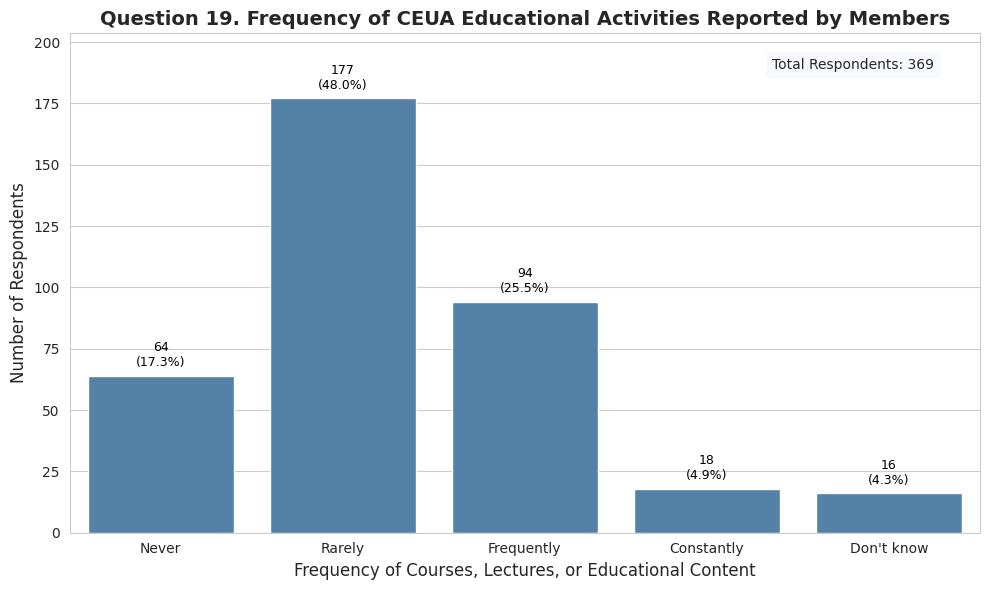

In [41]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_course_frequency(db_name):
    """
    Queries the database to get the 'Freq_cursos' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get the frequency of courses data for active respondents.
        query = """
        SELECT
          s."19. Freq_cursos"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Freq_cursos' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'Freq_cursos'.
    """
    courses_df = get_active_respondent_course_frequency(DATABASE_NAME)
    
    if courses_df is not None and not courses_df.empty:
        # Rename the column for easier use.
        courses_df.rename(columns={'19. Freq_cursos': 'CourseFrequency'}, inplace=True)

        # --- Data Translation Step ---
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Nunca': 'Never',
            'Raramente': 'Rarely',
            'Frequentemente': 'Frequently',
            'Constantemente': 'Constantly',
            'Não sei dizer': "Don't know"
        }
        courses_df['CourseFrequency'] = courses_df['CourseFrequency'].replace(translation_map)


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Frequency of Educational Courses ---")
        print(courses_df['CourseFrequency'].describe())
        
        print("\nFrequency Count:")
        print(courses_df['CourseFrequency'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Course Frequency Distribution Plot ---")
        
        # Define the logical order for the categories on the plot's x-axis.
        category_order = [
            'Never',
            'Rarely',
            'Frequently',
            'Constantly',
            "Don't know"
        ]
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=courses_df,
            x='CourseFrequency',
            color='steelblue',
            order=category_order
        )
        
        plt.xlabel('Frequency of Courses, Lectures, or Educational Content', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 19. Frequency of CEUA Educational Activities Reported by Members', fontsize=14, fontweight='bold')
        
        total_respondents = len(courses_df['CourseFrequency'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Adjust top margin to ensure labels fit.
        max_height = courses_df['CourseFrequency'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'Outros_encontros' data for active respondents.

--- Descriptive Statistics for Frequency of Other Meetings ---
count        369
unique         5
top       Rarely
freq         187
Name: OtherMeetingsFrequency, dtype: object

Frequency Count:
OtherMeetingsFrequency
Rarely        187
Never          98
Frequently     58
Constantly     16
Don't know     10
Name: count, dtype: int64

--- Generating Other Meetings Frequency Distribution Plot ---


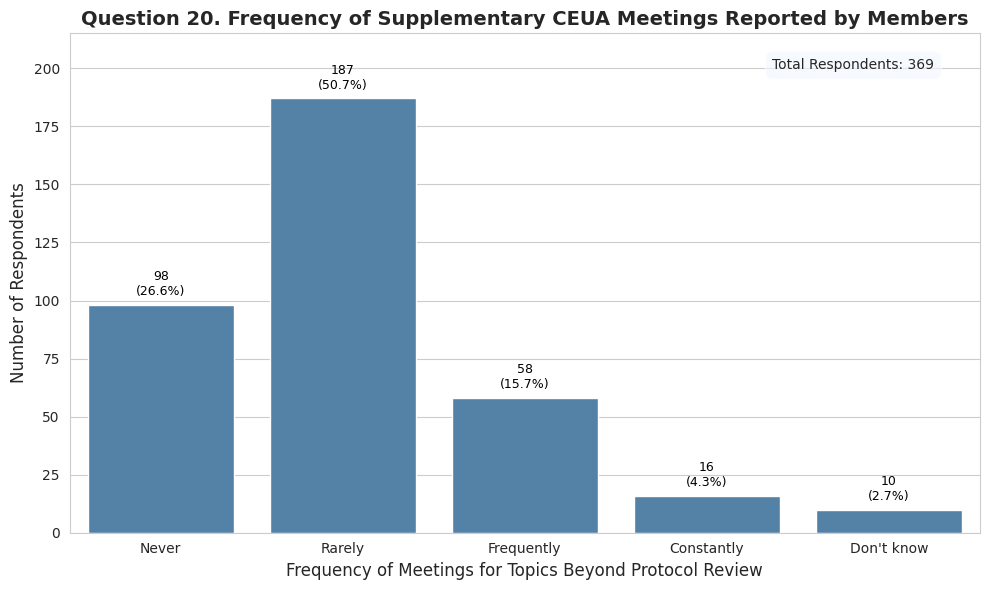

In [42]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_other_meetings(db_name):
    """
    Queries the database to get the 'Outros_encontros' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get the frequency of other meetings data for active respondents.
        query = """
        SELECT
          s."20. Outros_encontros"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Outros_encontros' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'Outros_encontros'.
    """
    meetings_df = get_active_respondent_other_meetings(DATABASE_NAME)
    
    if meetings_df is not None and not meetings_df.empty:
        # Rename the column for easier use.
        meetings_df.rename(columns={'20. Outros_encontros': 'OtherMeetingsFrequency'}, inplace=True)

        # --- Data Translation Step ---
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Nunca': 'Never',
            'Raramente': 'Rarely',
            'Frequentemente': 'Frequently',
            'Constantemente': 'Constantly',
            'Não sei dizer': "Don't know"
        }
        meetings_df['OtherMeetingsFrequency'] = meetings_df['OtherMeetingsFrequency'].replace(translation_map)


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Frequency of Other Meetings ---")
        print(meetings_df['OtherMeetingsFrequency'].describe())
        
        print("\nFrequency Count:")
        print(meetings_df['OtherMeetingsFrequency'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Other Meetings Frequency Distribution Plot ---")
        
        # Define the logical order for the categories on the plot's x-axis.
        category_order = [
            'Never',
            'Rarely',
            'Frequently',
            'Constantly',
            "Don't know"
        ]
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=meetings_df,
            x='OtherMeetingsFrequency',
            color='steelblue',
            order=category_order
        )
        
        plt.xlabel('Frequency of Meetings for Topics Beyond Protocol Review', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 20. Frequency of Supplementary CEUA Meetings Reported by Members', fontsize=14, fontweight='bold')
        
        total_respondents = len(meetings_df['OtherMeetingsFrequency'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Adjust top margin to ensure labels fit.
        max_height = meetings_df['OtherMeetingsFrequency'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'Metodo_decisao' data for active respondents.

--- Descriptive Statistics for Decision-Making Method ---
count                      369
unique                      12
top       Voting and Consensus
freq                       296
Name: DecisionMethod, dtype: object

Frequency Count:
DecisionMethod
Voting and Consensus                                               296
Only Consensus                                                      44
Only Voting                                                         18
Don't know                                                           3
Votação com discussão prévia                                         1
Variavel                                                             1
O presidente                                                         1
SOU SUPLENTE                                                         1
O CEUA é novo. A primeira solicitação foi enviada nesta semana.      1
Votação, Avaliação de Projetos e Relatórios    

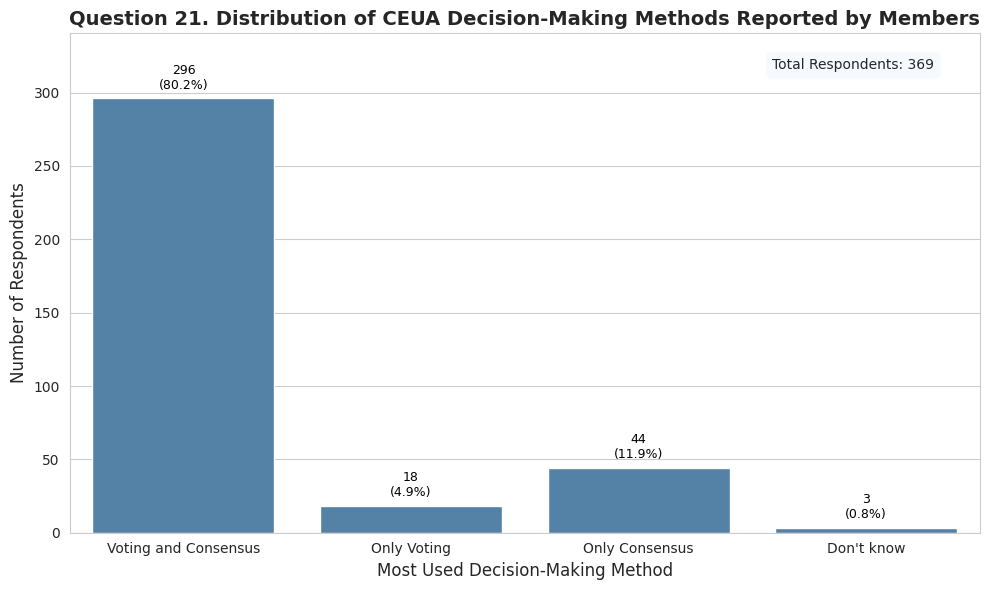

In [43]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_decision_method(db_name):
    """
    Queries the database to get the 'Metodo_decisao' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get the decision-making method data for active respondents.
        query = """
        SELECT
          s."21. Metodo_decisao"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Metodo_decisao' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'Metodo_decisao'.
    """
    decision_df = get_active_respondent_decision_method(DATABASE_NAME)
    
    if decision_df is not None and not decision_df.empty:
        # Rename the column for easier use.
        decision_df.rename(columns={'21. Metodo_decisao': 'DecisionMethod'}, inplace=True)
        
        # Clean up potential 'Other:' prefixes if they exist
        decision_df['DecisionMethod'] = decision_df['DecisionMethod'].str.replace('Other:', 'Other', regex=False).str.strip()


        # --- Data Translation Step ---
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Votação e consenso': 'Voting and Consensus',
            'Só votação': 'Only Voting',
            'Só consenso': 'Only Consensus',
            'Não sei dizer': "Don't know"
        }
        decision_df['DecisionMethod'] = decision_df['DecisionMethod'].replace(translation_map)


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Decision-Making Method ---")
        print(decision_df['DecisionMethod'].describe())
        
        print("\nFrequency Count:")
        print(decision_df['DecisionMethod'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Decision-Making Method Distribution Plot ---")
        
        # Define the logical order for the categories on the plot's x-axis.
        category_order = [
            'Voting and Consensus',
            'Only Voting',
            'Only Consensus',
            "Don't know"
            # Any 'Other' values will be appended if they exist
        ]
        
        # Add 'Other' to the order if it exists in the data
        if 'Other' in decision_df['DecisionMethod'].unique():
            category_order.append('Other')

        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=decision_df,
            x='DecisionMethod',
            color='steelblue',
            order=category_order
        )
        
        plt.xlabel('Most Used Decision-Making Method', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 21. Distribution of CEUA Decision-Making Methods Reported by Members', fontsize=14, fontweight='bold')
        
        total_respondents = len(decision_df['DecisionMethod'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Adjust top margin to ensure labels fit.
        max_height = decision_df['DecisionMethod'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'Periodicidade_das_reunioes' data for active respondents.

--- Descriptive Statistics for Meeting Periodicity (Brittle Clean) ---
count              369
unique               8
top       Once a month
freq               231
Name: TranslatedPeriodicity, dtype: object

Frequency Count (Brittle Clean):
TranslatedPeriodicity
Once a month             231
Every fifteen days        39
Once every two months     38
Once per semester         24
Other                     16
Don't know                13
Once a week                5
Quarterly                  3
Name: count, dtype: int64

--- Generating Meeting Periodicity Distribution Plot (Brittle Clean) ---


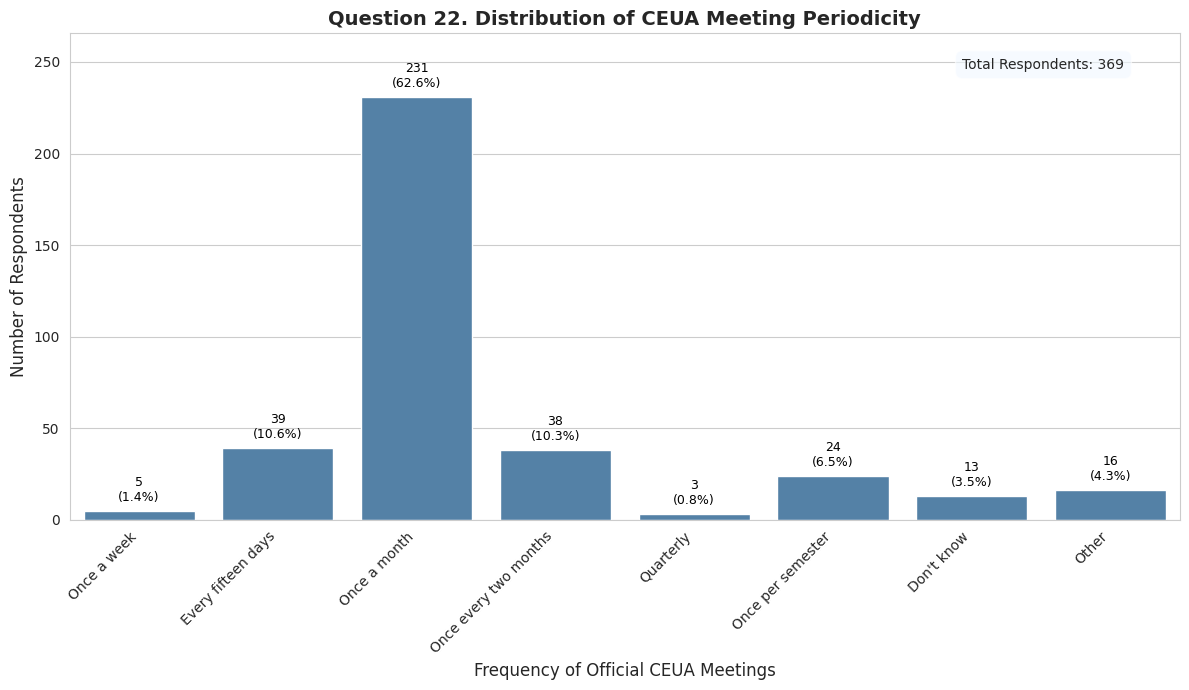

In [44]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_meeting_periodicity(db_name):
    """
    Queries the database to get the 'Periodicidade_das_reunioes' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."22. Periodicidade_das_reunioes"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Periodicidade_das_reunioes' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform a simple, dictionary-based cleaning and display the analysis.
    """
    periodicity_df = get_active_respondent_meeting_periodicity(DATABASE_NAME)
    
    if periodicity_df is not None and not periodicity_df.empty:
        periodicity_df.rename(columns={'22. Periodicidade_das_reunioes': 'MeetingPeriodicity'}, inplace=True)

        # --- Brittle Cleaning Step using a direct dictionary mapping ---
        recode_map = {
            "1 vez/ mês e às vezes 2 vezes/mês": "Uma vez por mês",
            "A CEUA do IFPA reúne-se ordinariamente a cada 30 dias e, extraordinariamente, sempre que convocado pelo presidente ou maioria dos seus membros.": "Uma vez por mês",
            "Além da reunião mensal, alguns meses fazemos reuniões extraordinário.": "Uma vez por mês",
            "As reuniões são mensais, porém sempre que necessário são realizadas reuniões extraordinárias para discussão de algum tema.": "Uma vez por mês",
            "Depende da demanda, normalmente 1 vez por mês. Mas em algumas épocas nos encontravamos 2 vezes por mês.": "Uma vez por mês",
            "Estamos iniciando este ano encontros quinzenais para discutir esse tema.": "A cada quinze dias",
            "Ordinárias a cada dois meses e extraordinária quando precisa": "Uma vez a cada dois meses",
            "Reuniões ordinárias 1 x mês, ou quando necessário, agenda-se reunião extraordinária ara avaliação de algum pedido.": "Uma vez por mês",
            "Uma vez por mês e quando há processos a serem analisados.": "Uma vez por mês",
            "uma vez por mês e quando há demanda maior": "Uma vez por mês",
            "a cada 3 meses": "Trimestralmente",
            "uma vez a cada 3 meses": "Trimestralmente",
            "Uma vez por semestre ou antes, se houver protocolos a serem analisados.": "Uma vez por semestre"
        }
        
        periodicity_df['CleanedPeriodicity'] = periodicity_df['MeetingPeriodicity'].replace(recode_map)

        # --- Data Translation Step ---
        translation_map = {
            'Uma vez por semana': 'Once a week',
            'A cada quinze dias': 'Every fifteen days',
            'Uma vez por mês': 'Once a month',
            'Uma vez a cada dois meses': 'Once every two months',
            'Trimestralmente': 'Quarterly',
            'Uma vez por semestre': 'Once per semester',
            'Não sei dizer': "Don't know"
        }
        
        # Apply translation and categorize everything else as 'Other'
        periodicity_df['TranslatedPeriodicity'] = periodicity_df['CleanedPeriodicity'].map(translation_map).fillna('Other')
        
        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Meeting Periodicity (Brittle Clean) ---")
        print(periodicity_df['TranslatedPeriodicity'].describe())
        
        print("\nFrequency Count (Brittle Clean):")
        print(periodicity_df['TranslatedPeriodicity'].value_counts())

        # --- 2. Plotting the Data ---
        print("\n--- Generating Meeting Periodicity Distribution Plot (Brittle Clean) ---")
        
        category_order = [
            'Once a week',
            'Every fifteen days',
            'Once a month',
            'Once every two months',
            'Quarterly',
            'Once per semester',
            "Don't know",
            'Other'
        ]
        
        final_order = [cat for cat in category_order if cat in periodicity_df['TranslatedPeriodicity'].unique()]

        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 7))
        
        ax = sns.countplot(
            data=periodicity_df,
            x='TranslatedPeriodicity',
            color='steelblue',
            order=final_order
        )
        
        plt.xlabel('Frequency of Official CEUA Meetings', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 22. Distribution of CEUA Meeting Periodicity', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        
        total_respondents = len(periodicity_df['TranslatedPeriodicity'].dropna())
        
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom',
                            xytext=(0, 5), 
                            textcoords='offset points',
                            fontsize=9,
                            color='black')

        max_height = periodicity_df['TranslatedPeriodicity'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded 'SPA_assume_relatoria' data for active respondents.

--- Descriptive Statistics for SPA Protocol Reporting ---
count     369
unique      4
top        No
freq      121
Name: SPAReporting, dtype: object

Frequency Count:
SPAReporting
No                               121
Yes                              116
No SPA representative on CEUA     72
Don't know                        60
Name: count, dtype: int64

--- Generating SPA Protocol Reporting Distribution Plot ---


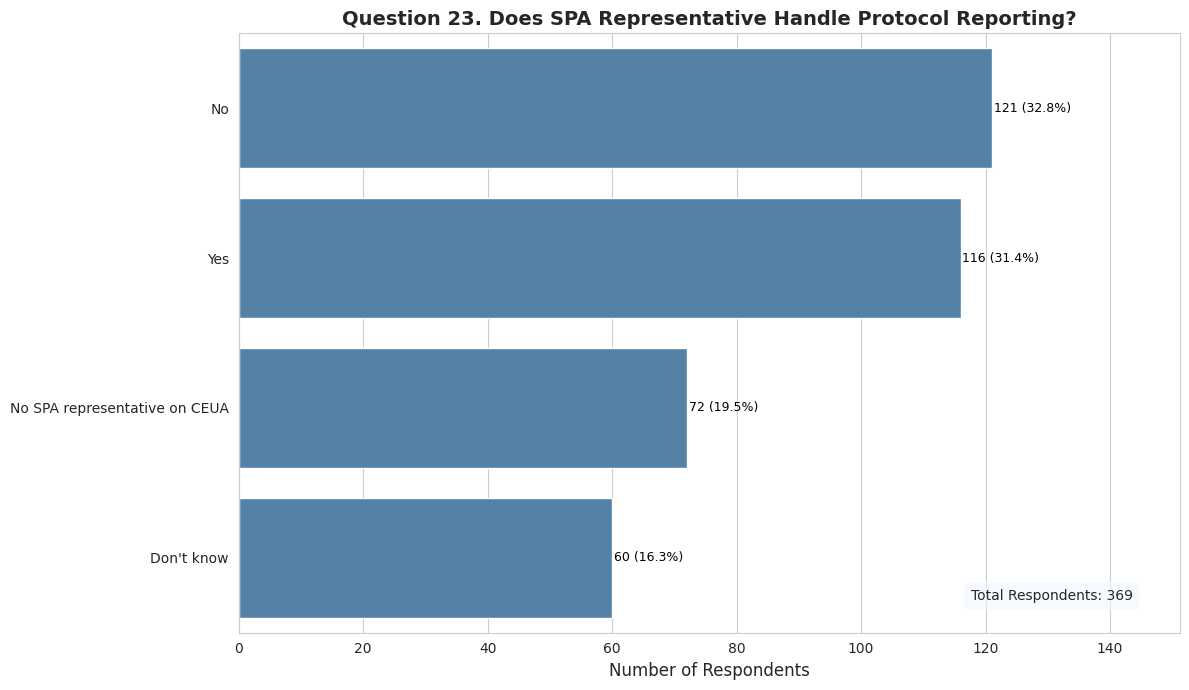

In [45]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_spa_relatoria(db_name):
    """
    Queries the database to get the 'SPA_assume_relatoria' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get the relevant data for active respondents.
        query = """
        SELECT
          s."23. SPA_assume_relatoria"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'SPA_assume_relatoria' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'SPA_assume_relatoria'.
    """
    spa_df = get_active_respondent_spa_relatoria(DATABASE_NAME)
    
    if spa_df is not None and not spa_df.empty:
        # Rename the column for easier use.
        spa_df.rename(columns={'23. SPA_assume_relatoria': 'SPAReporting'}, inplace=True)

        # --- Data Translation Step ---
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Sim': 'Yes',
            'Não': 'No',
            'Não há representante da sociedade protetora de animais': 'No SPA representative on CEUA',
            'Não sei dizer': "Don't know"
        }
        spa_df['SPAReporting'] = spa_df['SPAReporting'].replace(translation_map)

        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for SPA Protocol Reporting ---")
        print(spa_df['SPAReporting'].describe())
        
        print("\nFrequency Count:")
        print(spa_df['SPAReporting'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating SPA Protocol Reporting Distribution Plot ---")
        
        # Define the logical order for the categories on the plot's y-axis.
        category_order = [
            'No',
            'Yes',
            'No SPA representative on CEUA',
            "Don't know"
        ]
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 7))
        
        ax = sns.countplot(
            data=spa_df,
            y='SPAReporting', # Use y-axis for better readability of long labels
            color='steelblue',
            order=category_order
        )
        
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.ylabel('', fontsize=12) # Y-label is self-explanatory
        plt.title('Question 23. Does SPA Representative Handle Protocol Reporting?', fontsize=14, fontweight='bold')
        
        total_respondents = len(spa_df['SPAReporting'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        # Adjust right margin to ensure labels fit.
        max_width = spa_df['SPAReporting'].value_counts().max()
        ax.set_xlim(0, max_width * 1.25)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.05, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded opinion data on SPA reporting for active respondents.

--- Descriptive Statistics for Opinion on SPA Reporting ---
count     369
unique      3
top       Yes
freq      182
Name: OpinionSPAReporting, dtype: object

Frequency Count:
OpinionSPAReporting
Yes                  182
No                   127
I have no opinion     60
Name: count, dtype: int64

--- Generating Opinion on SPA Reporting Distribution Plot ---


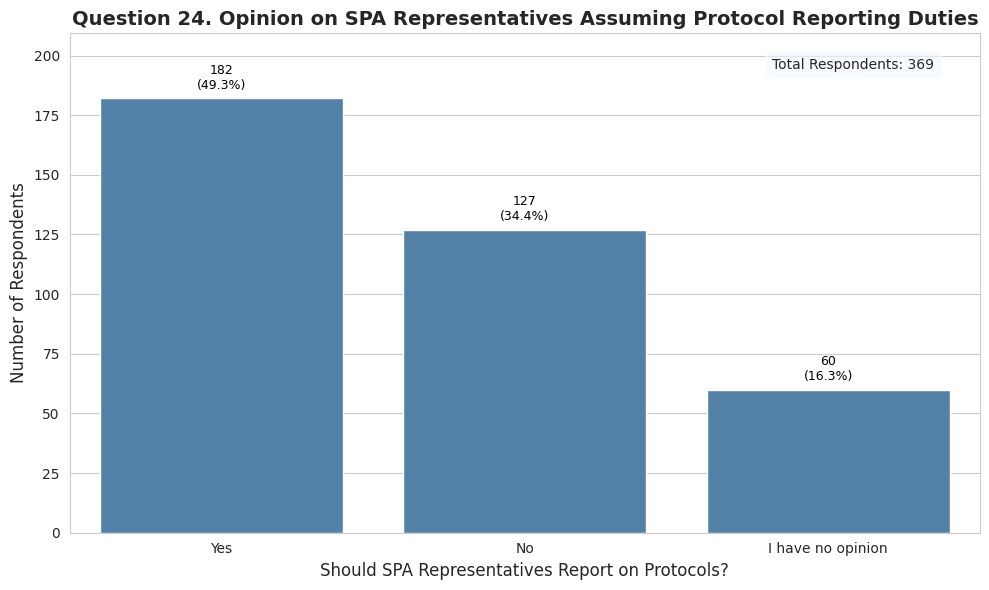

In [46]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_opinion_spa_reporting(db_name):
    """
    Queries the database to get the 'Opiniao_SPA_deve_assumir_relatoria' data
    for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."24. Opiniao_SPA_deve_assumir_relatoria"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded opinion data on SPA reporting for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of opinion on
    whether SPA representatives should report on protocols.
    """
    opinion_df = get_active_respondent_opinion_spa_reporting(DATABASE_NAME)
    
    if opinion_df is not None and not opinion_df.empty:
        # Rename the column for easier use
        opinion_df.rename(columns={'24. Opiniao_SPA_deve_assumir_relatoria': 'OpinionSPAReporting'}, inplace=True)

        # --- Data Translation ---
        # Map Portuguese responses to English for clarity
        translation_map = {
            'Sim': 'Yes',
            'Não': 'No',
            'Não tenho opinião sobre isso': 'I have no opinion'
        }
        opinion_df['OpinionSPAReporting'] = opinion_df['OpinionSPAReporting'].map(translation_map)
        
        # Drop any rows that might not have been mapped (if any exist)
        opinion_df.dropna(subset=['OpinionSPAReporting'], inplace=True)


        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Opinion on SPA Reporting ---")
        print(opinion_df['OpinionSPAReporting'].describe())
        
        print("\nFrequency Count:")
        print(opinion_df['OpinionSPAReporting'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Opinion on SPA Reporting Distribution Plot ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=opinion_df,
            x='OpinionSPAReporting',
            color='steelblue',
            order = opinion_df['OpinionSPAReporting'].value_counts().index
        )
        
        plt.xlabel('Should SPA Representatives Report on Protocols?', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 24. Opinion on SPA Representatives Assuming Protocol Reporting Duties', fontsize=14, fontweight='bold')
        
        total_respondents = len(opinion_df)
        
        # Add both count and percentage to the bar labels.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'bottom',
                            xytext = (0, 5), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

        # Add more space at the top of the plot
        max_height = opinion_df['OpinionSPAReporting'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded and joined justification data for active respondents.

--- Descriptive Statistics for Justification of SPA Reporting Role ---
count                                       369
unique                                        8
top       Risk of partiality / Lacks competence
freq                                         89
Name: Justification, dtype: object

Frequency Count:
Justification
Risk of partiality / Lacks competence        89
Conditional (with training/supervision)      73
Based on equality/isonomy                    62
No opinion / Not classifiable                49
Brings positive contributions                36
SPA is competent for the role                33
Not the function of an SPA representative    16
Lack of engagement from SPA                  11
Name: count, dtype: int64

--- Generating Justification Distribution Plot ---


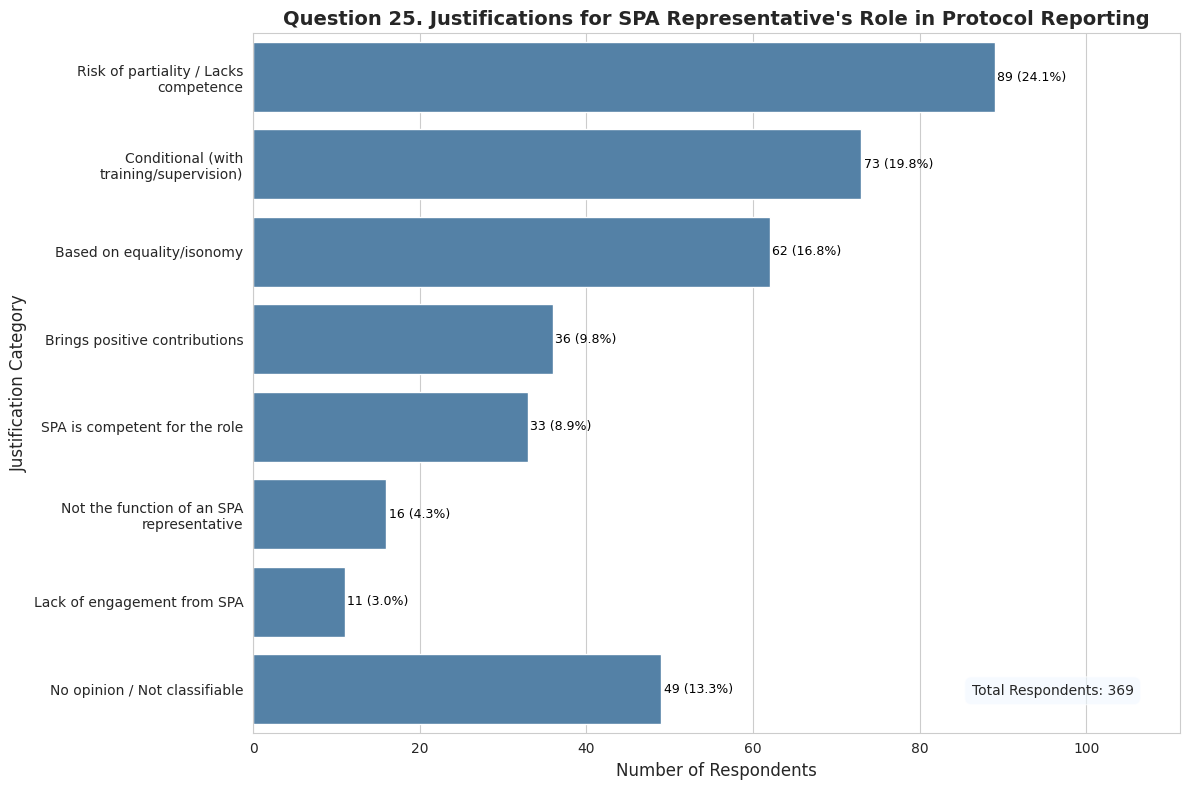

In [47]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_justification(db_name):
    """
    Queries the database to get the decoded justification data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to join SurveyAnswers with the lookup table to get meaningful descriptions.
        query = """
        SELECT
          jrl.name AS Justification
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        JOIN
          JustificativaRelatoriaLookup AS jrl ON s."Justifique_dever_assumir_relatoria_codificado(25)" = jrl.id
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded and joined justification data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform the univariate analysis of the justification for SPA reporting.
    """
    justification_df = get_active_respondent_justification(DATABASE_NAME)
    
    if justification_df is not None and not justification_df.empty:

        # --- Data Translation and Shortening Step ---
        # The descriptions from the DB are too long. We map them to shorter English versions.
        translation_map = {
            'Não opinou; declarou não ter opinião; declarou algo não definível': "No opinion / Not classifiable",
            'Falta de Competências, Conhecimentos Técnicos/Científicos (incluindo em BEA), treinamento, formação superior ou capacidades (incluindo argumentativa). Falta de imparcialidade/Antiético;SPA é passional/pode haver extremismo e conflito; Pessoas de dificil convivência': "Risk of partiality / Lacks competence",
            'Falta de engajamento, participação, comunicação/contato, presença, constância, abertura, diálogo/não há interesse por participar. Falta de engajamento da SPA; dificuldade em encontrar representantes': "Lack of engagement from SPA",
            'Desde que: tenha formação superior ou conhecimento técnico/científico, ou receba ajuda/orientação/contribuição de outro membro/conheça as normativas do CONCEA/seja qualificado/tenha disponibilidade.': "Conditional (with training/supervision)",
            'SPA tem competência/ Por ser membro de uma sociedade protetora deve ter conhecimento de ética e legislações pertinentes ao bem-estar animal.': "SPA is competent for the role",
            'Contribuição positiva: Gera Aprendizado para a CEUA ou para o membro SPA ou aumenta engajamento do SPA, visão externa e Diversidade de opiniões ajudam, melhor distribuição de tarefas. Função educativa (para SPA ou a CEUA ). Positivo para a defesa ou proteção dos animais, positivo para o BEA.Representam os interesses dos animais; protegem decisão ética/correta.': "Brings positive contributions",
            'Respeito à Isonomia, Imparcialidade, acesso igualitário, igualdade, inclusão, diversidade de opiniões/pois a CEUA é multidisciplinar. Não deve haver diferenciação. A regra é a mesma para todos/A decisão final é coletiva/colegiada. Direito; Representatividade': "Based on equality/isonomy",
            'Não é função do SPA. Regra do CONCEA, Papel exclusivo, para membros institucionais, internos ou com certos papeis (médico veterinário, zootecnista ou biólogo). Papel exclusivo de certos membros; Riscos (confidencialidade). Desnecessário; não há benefício; não acrescenta; os outros membros são suficientes; indiferente': "Not the function of an SPA representative",
            'Falta de imparcialidade/Antiético;SPA é passional/pode haver extremismo e conflito; Pessoas de dificil convivência': "Risk of partiality / Lacks competence" # Merged category
        }
        justification_df['Justification'] = justification_df['Justification'].replace(translation_map)

        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Justification of SPA Reporting Role ---")
        print(justification_df['Justification'].describe())
        
        print("\nFrequency Count:")
        print(justification_df['Justification'].value_counts())

        # Wrap text for better display on the y-axis after getting stats
        justification_df['Justification'] = justification_df['Justification'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=35)))


        # --- 2. Plotting the Data ---
        print("\n--- Generating Justification Distribution Plot ---")
        
        # MODIFIED: Define a custom order to place 'No opinion...' last.
        value_counts = justification_df['Justification'].value_counts()
        order = value_counts.index.tolist()
        no_opinion_category_wrapped = '\n'.join(textwrap.wrap("No opinion / Not classifiable", width=35))
        
        if no_opinion_category_wrapped in order:
            order.remove(no_opinion_category_wrapped)
            order.append(no_opinion_category_wrapped)
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 8))
        
        ax = sns.countplot(
            data=justification_df,
            y='Justification',
            color='steelblue',
            order=order
        )
        
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.ylabel('Justification Category', fontsize=12)
        plt.title("Question 25. Justifications for SPA Representative's Role in Protocol Reporting", fontsize=14, fontweight='bold')
        
        total_respondents = len(justification_df['Justification'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        # Adjust right margin to ensure labels fit.
        max_width = justification_df['Justification'].value_counts().max()
        ax.set_xlim(0, max_width * 1.25)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.05, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()



Success: Loaded 'SPA_deve_ter_formacao' data for active respondents.

--- Descriptive Statistics for Opinion on SPA Higher Education ---
count     369
unique      3
top       Yes
freq      209
Name: SPAFormationNeeded, dtype: object

Frequency Count:
SPAFormationNeeded
Yes           209
No            128
No opinion     32
Name: count, dtype: int64

--- Generating Opinion Distribution Plot ---


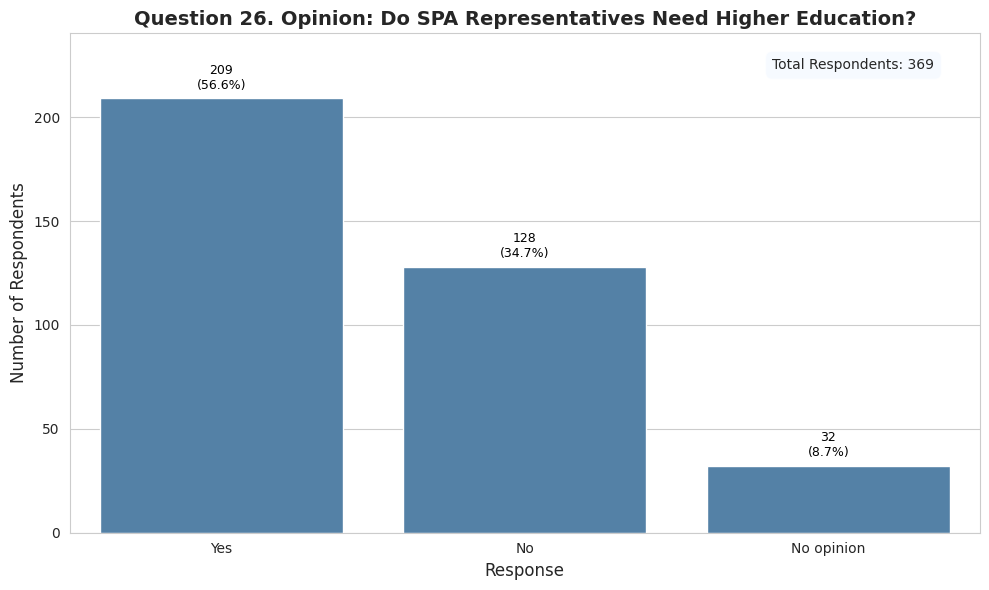

In [48]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_spa_education(db_name):
    """
    Queries the database to get the 'SPA_deve_ter_formacao' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get the opinion on SPA representatives needing higher education.
        query = """
        SELECT
          s."26. SPA_deve_ter_formacao"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'SPA_deve_ter_formacao' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis.
    """
    education_df = get_active_respondent_spa_education(DATABASE_NAME)
    
    if education_df is not None and not education_df.empty:
        # Rename the column for easier use.
        education_df.rename(columns={'26. SPA_deve_ter_formacao': 'SPAFormationNeeded'}, inplace=True)

        # --- Data Translation Step ---
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Sim': 'Yes',
            'Não': 'No',
            'Não tenho opinião sobre isso': 'No opinion'
        }
        education_df['SPAFormationNeeded'] = education_df['SPAFormationNeeded'].replace(translation_map)

        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Opinion on SPA Higher Education ---")
        print(education_df['SPAFormationNeeded'].describe())
        
        print("\nFrequency Count:")
        print(education_df['SPAFormationNeeded'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Opinion Distribution Plot ---")
        
        # Define the logical order for the categories.
        category_order = ['Yes', 'No', 'No opinion']
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        
        ax = sns.countplot(
            data=education_df,
            x='SPAFormationNeeded',
            color='steelblue',
            order=category_order
        )
        
        plt.xlabel('Response', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.title('Question 26. Opinion: Do SPA Representatives Need Higher Education?', fontsize=14, fontweight='bold')
        
        total_respondents = len(education_df['SPAFormationNeeded'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = 100 * height / total_respondents
                label = f'{int(height)}\n({percentage:.1f}%)'
                ax.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom',
                            xytext=(0, 5), 
                            textcoords='offset points',
                            fontsize=9,
                            color='black')

        # Adjust top margin to ensure labels fit.
        max_height = education_df['SPAFormationNeeded'].value_counts().max()
        ax.set_ylim(0, max_height * 1.15)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()


Success: Loaded and joined justification data for active respondents.

--- Descriptive Statistics for Justification of SPA Higher Education ---
count                                       369
unique                                        6
top       Necessary for technical understanding
freq                                        203
Name: Justification, dtype: object

Frequency Count:
Justification
Necessary for technical understanding       203
Not necessary / Can be trained              107
No opinion / Not classifiable                21
Requirement could restrict participation     17
Relevant knowledge isn't from academia       12
To ensure objectivity / Avoid bias            9
Name: count, dtype: int64

--- Generating Justification Distribution Plot ---


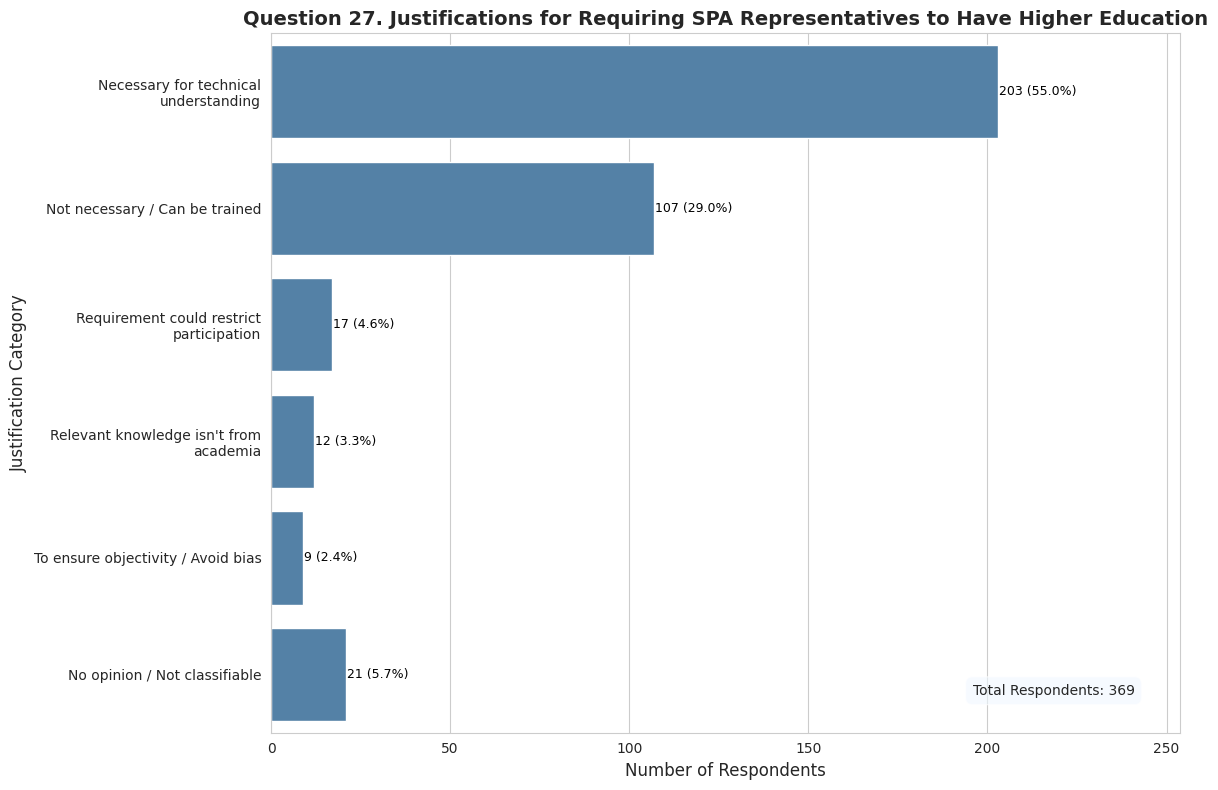

In [49]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_justification(db_name):
    """
    Queries the database to get the decoded justification data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to join SurveyAnswers with the lookup table for justification on SPA formation.
        query = """
        SELECT
          jfl.name AS Justification
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        JOIN
          JustificativaFormacaoLookup AS jfl ON s."Justifique_SPA_deve_ter_formacao_aberta_codificado(27)" = jfl.id
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded and joined justification data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform the univariate analysis of the justification for SPA education.
    """
    justification_df = get_active_respondent_justification(DATABASE_NAME)
    
    if justification_df is not None and not justification_df.empty:

        # --- Data Translation and Shortening Step ---
        # Map long Portuguese descriptions to shorter, analytical English versions.
        translation_map = {
            'Não opinou; declarou não ter opinião; declarou algo não definível': 'No opinion / Not classifiable',
            'É necessário: para entender, avaliar e contribuir. Para estar no nível apropriado/conseguir entender e dialogar os proponentes de pesquisa e seus pares. Para fazer Avaliação técnica. O entendimento dos projetos requer noções de estatistica, delineamento experimental; manipulação de animais, ciências agrárias. Para poder assumir relatoria de protocolos; para dar parecer, avaliar protocolos. Conhecimento acadêmico básico/nível superior. Para ter conhecimento teórico em vários assuntos, o que é muito importante. Graduação em geral contribui, sem especificar área.': 'Necessary for technical understanding',
            'Evitar Imparcialidade, achismo; "fundamentalismo"; fanatismo, atitude anti cientifica, paixoes, realmente contribuir, ter visão mais racional da proteção aos animais, evitar viés emocional.': 'To ensure objectivity / Avoid bias',
            'Não é necessário; As habilidades e conhecimentos importantes para a função não dependem de formação academica. Não é necessário mas é desejável. Um curso ou algum tipo de capacitação poderia resolver': 'Not necessary / Can be trained',
            'É preciso ter Conhecimentos relevantes à proteção animal, para cumporirem o papel de defesa e cuidado com os animais. Conhecimento em ética, direito dos animais. Conhecimentos especificos: anatomia sobre a espécie que se defende; particularidades de cada espécie; legislação, bem-estar animal.': 'Relevant knowledge isn\'t from academia',
            'Pode ser uma Exigência negativa: Necessidade de formação pode ser negativo: não ser representativo da siociedade, restringir participação, reduzir visão diferente': 'Requirement could restrict participation',
            'Para entender a importancia do uso de animais': 'To understand the importance of animal use'
        }
        justification_df['Justification'] = justification_df['Justification'].replace(translation_map)
        
        # --- 1. Descriptive Statistics ---
        print("\n--- Descriptive Statistics for Justification of SPA Higher Education ---")
        # Note: We print stats before wrapping the text to get a clean, non-wrapped describe() output.
        print(justification_df['Justification'].describe())
        
        print("\nFrequency Count:")
        print(justification_df['Justification'].value_counts())

        # Wrap text for better display on the y-axis labels after getting stats.
        justification_df['Justification'] = justification_df['Justification'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=35)))


        # --- 2. Plotting the Data ---
        print("\n--- Generating Justification Distribution Plot ---")
        
        # MODIFIED: Define a custom order to place 'No opinion...' last.
        value_counts = justification_df['Justification'].value_counts()
        # Start with the order based on frequency
        order = value_counts.index.tolist()
        # Identify the target category (which is now wrapped)
        no_opinion_category = '\n'.join(textwrap.wrap('No opinion / Not classifiable', width=35))
        # If the category exists in the list, move it to the end
        if no_opinion_category in order:
            order.remove(no_opinion_category)
            order.append(no_opinion_category)
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 8))
        
        ax = sns.countplot(
            data=justification_df,
            y='Justification',
            color='steelblue',
            order=order
        )
        
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.ylabel('Justification Category', fontsize=12)
        plt.title("Question 27. Justifications for Requiring SPA Representatives to Have Higher Education", fontsize=14, fontweight='bold')
        
        total_respondents = len(justification_df['Justification'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        # Adjust right margin to ensure labels fit.
        max_width = justification_df['Justification'].value_counts().max()
        ax.set_xlim(0, max_width * 1.25)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.05, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()



Success: Loaded 'Papel_na_CEUA' data for active respondents.

--- Descriptive Statistics for CEUA Role ---
count                    369
unique                     6
top       Professor/Lecturer
freq                     100
Name: CEUARole, dtype: object

Frequency Count:
CEUARole
Professor/Lecturer                100
Veterinarian                       95
Researcher                         67
Other                              48
Biologist                          47
Animal Protection Society Rep.     12
Name: count, dtype: int64

--- Generating CEUA Role Distribution Plot ---


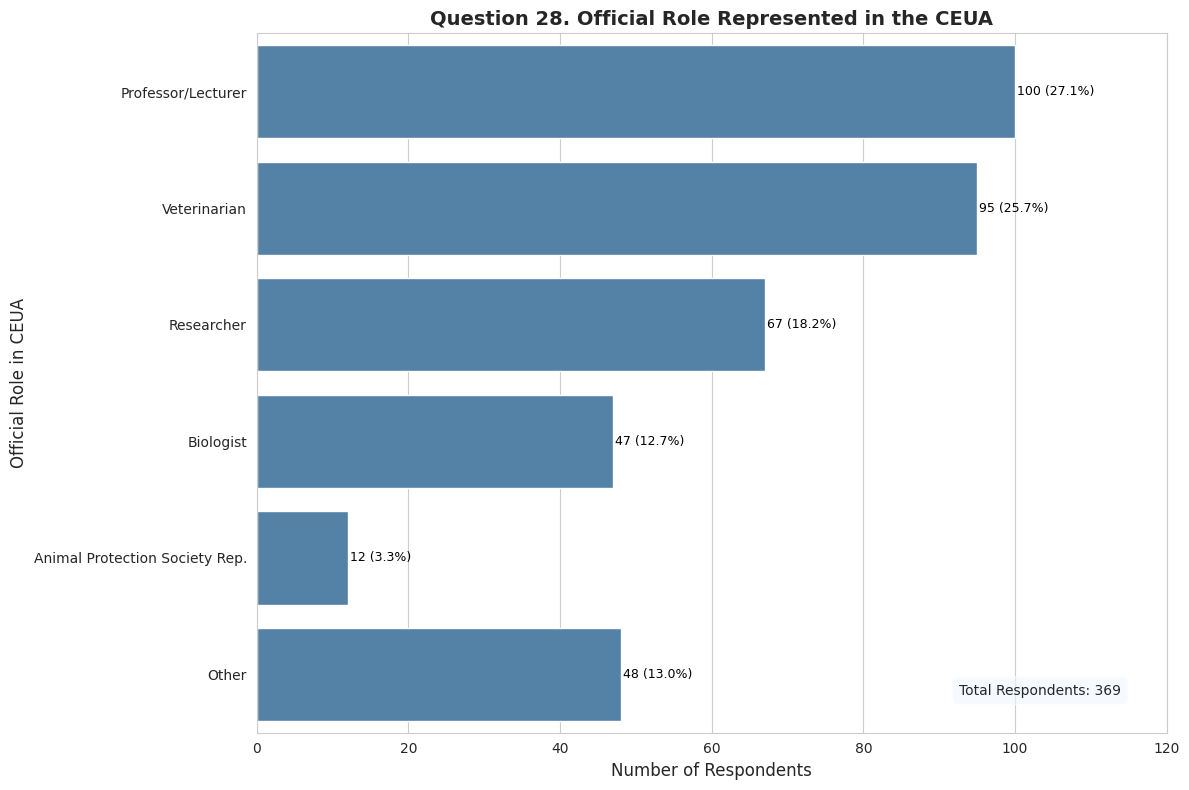

In [50]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_role(db_name):
    """
    Queries the database to get the 'Papel_na_CEUA' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # SQL query to get '28. Papel_na_CEUA' for active respondents.
        query = """
        SELECT
          s."28. Papel_na_CEUA"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded 'Papel_na_CEUA' data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of 'Papel_na_CEUA'.
    """
    role_df = get_active_respondent_role(DATABASE_NAME)
    
    if role_df is not None and not role_df.empty:
        # Rename the column for easier use and clearer outputs.
        role_df.rename(columns={'28. Papel_na_CEUA': 'CEUARole'}, inplace=True)

        # --- Data Cleaning and Translation ---
        # Clean up 'Other:' prefix and extra whitespace
        role_df['CEUARole'] = role_df['CEUARole'].str.replace('Other:', '', regex=False).str.strip()
        
        # Map Portuguese categories to English for the plot.
        translation_map = {
            'Biólogo (a)': 'Biologist',
            'Médico(a) Veterinário (a)': 'Veterinarian',
            'Representante da Sociedade Protetora de Animais': 'Animal Protection Society Rep.',
            'Pesquisador(a)': 'Researcher',
            'Docente': 'Professor/Lecturer',
            'Zootecnista': 'Zootechnician',
            'Farmacêutico': 'Pharmacist'
        }
        role_df['CEUARole'] = role_df['CEUARole'].replace(translation_map)

        # Consolidate less frequent roles into 'Other' for clarity
        value_counts = role_df['CEUARole'].value_counts()
        # Define a threshold for what is considered 'infrequent'
        infrequent_roles = value_counts[value_counts < 5].index
        role_df.loc[role_df['CEUARole'].isin(infrequent_roles), 'CEUARole'] = 'Other'
        
        # --- 1. Descriptive Statistics (on Translated and Aggregated Data) ---
        print("\n--- Descriptive Statistics for CEUA Role ---")
        print(role_df['CEUARole'].describe())
        
        print("\nFrequency Count:")
        print(role_df['CEUARole'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating CEUA Role Distribution Plot ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 8))
        
        # MODIFIED: Define a custom order to place 'Other' last.
        value_counts = role_df['CEUARole'].value_counts()
        # Start with the order based on frequency
        order = value_counts.index.tolist()
        # If 'Other' exists in the list, move it to the end
        if 'Other' in order:
            order.remove('Other')
            order.append('Other')
        
        ax = sns.countplot(
            data=role_df,
            y='CEUARole', # Use y-axis for long labels
            color='steelblue',
            order=order
        )
        
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.ylabel('Official Role in CEUA', fontsize=12)
        plt.title('Question 28. Official Role Represented in the CEUA', fontsize=14, fontweight='bold')
        
        total_respondents = len(role_df)
        
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        max_width = role_df['CEUARole'].value_counts().max()
        ax.set_xlim(0, max_width * 1.20)
        
        ax.text(0.95, 0.05, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()



Success: Loaded unified academic area data for active respondents.

--- Descriptive Statistics for Primary Academic Area (Cleaned & Aggregated) ---
count                     369
unique                      7
top       Veterinary Medicine
freq                      134
Name: 0, dtype: object

Frequency Count (Aggregated for Plot):
0
Veterinary Medicine                               134
Biological Sciences                                82
Health Sciences                                    50
Agrarian Sciences (except Veterinary Medicine)     48
Pharmacy / Chemistry                               26
Humanities                                         18
Other                                              11
Name: count, dtype: int64

--- Generating Primary Academic Background Distribution Plot ---


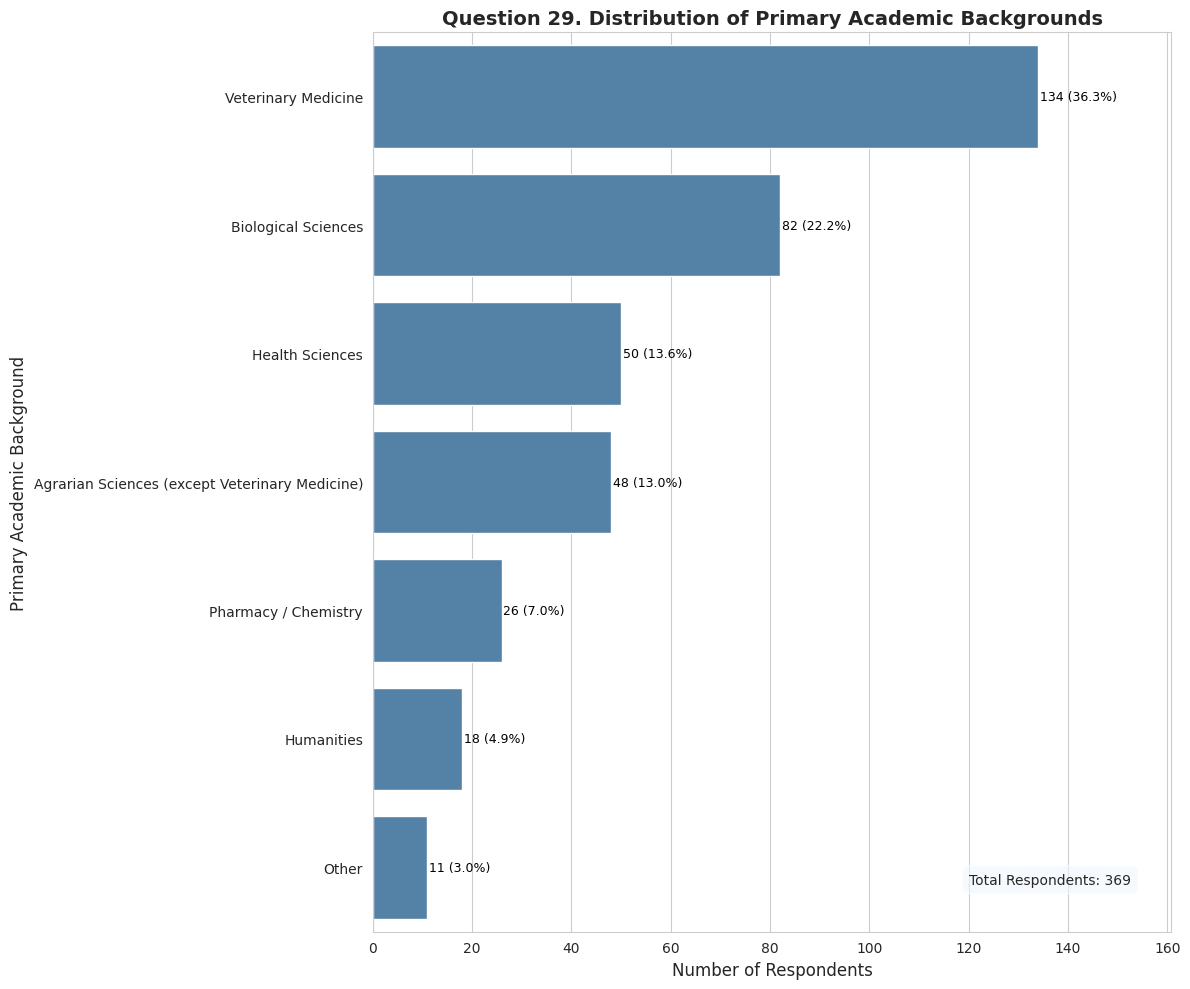

In [51]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_academic_area_unified(db_name):
    """
    Queries the database to get the 'Area_formacao_academica_unificado(29)' data for active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."Area_formacao_academica_unificado(29)"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded unified academic area data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def clean_and_group_academic_area(area_text):
    """
    Cleans and standardizes free-text academic area entries into major fields.
    """
    if pd.isna(area_text) or not isinstance(area_text, str) or area_text.strip() == '':
        return 'Not specified'
    
    area_upper = area_text.upper().strip()

    if 'VETERIN' in area_upper or 'ANIMAIS SELVAGENS' in area_upper: return 'Veterinary Medicine'
    if 'BIOLOG' in area_upper or 'CIÊNCIAS BIOLÓGICAS' in area_upper or 'ZOOLOGIA' in area_upper or 'OCEANOGRAFIA' in area_upper or 'ECOLOGIA' in area_upper: return 'Biological Sciences'
    if 'ZOOTEC' in area_upper or 'PRODUÇÃO ANIMAL' in area_upper or 'PESCA' in area_upper or 'AGRONOMIA' in area_upper or 'AGRÁRIAS' in area_upper: return 'Agrarian Sciences (except Veterinary Medicine)'
    if 'FARMÁCIA' in area_upper or 'FARMACEUT' in area_upper or 'QUÍMICA' in area_upper: return 'Pharmacy / Chemistry'
    if 'FILOSOFIA' in area_upper or 'HUMANIDADES' in area_upper or 'DIREITO' in area_upper or 'JURÍDICAS' in area_upper or 'GESTÃO' in area_upper or 'NEGÓCIOS' in area_upper or 'EDUCAÇÃO' in area_upper or 'COMUNICAÇÃO SOCIAL' in area_upper: return 'Humanities'
    if 'MEDICINA' in area_upper and 'VETERIN' not in area_upper or 'SAÚDE' in area_upper or 'CIRURGIA' in area_upper or 'PATOLOGIA' in area_upper or 'FISIOLOGIA' in area_upper or 'IMUNOLOGIA' in area_upper or 'GENÉTICA' in area_upper or 'RADIOLOGIA' in area_upper or 'FISIOTERAPIA' in area_upper or 'PSICOLOGIA' in area_upper or 'ENFERMAGEM' in area_upper or 'NUTRIÇÃO' in area_upper or 'ODONTOLOGIA' in area_upper or 'BIOMEDICINA' in area_upper: return 'Health Sciences'
    if 'AMBIENTAIS' in area_upper: return 'Environmental Sciences'
    if 'ESTATÍSTICA' in area_upper: return 'Statistics'
    return area_text

def main():
    """
    Main function for univariate analysis of the primary academic background.
    """
    area_df = get_active_respondent_academic_area_unified(DATABASE_NAME)
    
    if area_df is not None and not area_df.empty:
        area_df.rename(columns={'Area_formacao_academica_unificado(29)': 'AcademicAreaUnified'}, inplace=True)
        area_df.dropna(subset=['AcademicAreaUnified'], inplace=True)

        # --- NEW METHODOLOGY: Extract only the FIRST academic area ---
        # Split by semicolon, expand into columns, and take only the first column [0].
        primary_area_series = area_df['AcademicAreaUnified'].str.split(';', expand=True)[0].str.strip()
        
        # # Filter out empty strings AND the literal string 'NaN' (case-insensitive)
        # primary_area_series = primary_area_series[
        #     (primary_area_series != '') & 
        #     (primary_area_series.str.upper() != 'NAN')
        # ].dropna()

        # Apply the comprehensive cleaning function to the primary area
        cleaned_areas_series = primary_area_series.apply(clean_and_group_academic_area)
        cleaned_areas_series = cleaned_areas_series[cleaned_areas_series != 'Not specified']

        # Consolidate less frequent areas into an 'Other' category for the plot
        value_counts = cleaned_areas_series.value_counts()
        infrequent_areas = value_counts[value_counts < 10].index
        cleaned_areas_series.loc[cleaned_areas_series.isin(infrequent_areas)] = 'Other'

        # --- 1. Descriptive Statistics (on Aggregated Data) ---
        print("\n--- Descriptive Statistics for Primary Academic Area (Cleaned & Aggregated) ---")
        print(cleaned_areas_series.describe())
        
        print("\nFrequency Count (Aggregated for Plot):")
        print(cleaned_areas_series.value_counts())

        # --- 2. Plotting the Data ---
        print("\n--- Generating Primary Academic Background Distribution Plot ---")
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 10))
        
        # Custom order to place 'Other' last
        final_value_counts = cleaned_areas_series.value_counts()
        order = final_value_counts.index.tolist()
        if 'Other' in order:
            order.remove('Other')
            order.append('Other')
        
        ax = sns.countplot(
            y=cleaned_areas_series,
            color='steelblue',
            order=order
        )
        
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.ylabel('Primary Academic Background', fontsize=12)
        plt.title('Question 29. Distribution of Primary Academic Backgrounds', fontsize=14, fontweight='bold')
        
        total_respondents = len(cleaned_areas_series)
        
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        max_width = final_value_counts.max()
        ax.set_xlim(0, max_width * 1.20)
        
        ax.text(0.95, 0.05, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()



Success: Loaded education level data for active respondents.

--- Descriptive Statistics for Education Level (Revised Categories) ---
count                 369
unique                  5
top       Doctorate (PhD)
freq                  171
Name: EducationLevel, dtype: object

Frequency Count (Revised Categories):
EducationLevel
Doctorate (PhD)                  171
Post-doctorate / Habilitation     96
Master's Degree                   66
Undergraduate Degree              33
No University Degree               3
Name: count, dtype: int64

--- Generating Education Level Distribution Plot (Revised Categories) ---


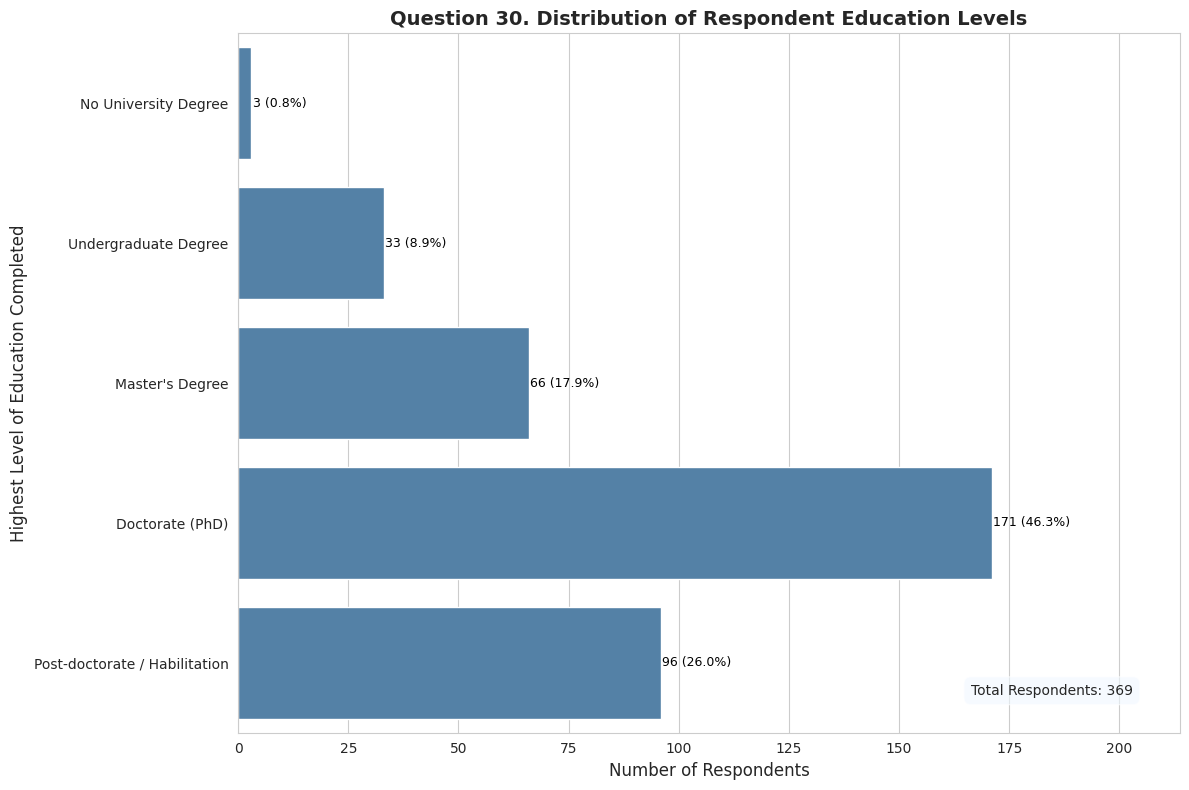

In [52]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_active_respondent_education(db_name):
    """
    Queries the database to get the 'Escolaridade' data for all active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."30. Escolaridade"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded education level data for active respondents.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and display the univariate analysis of education level.
    """
    education_df = get_active_respondent_education(DATABASE_NAME)
    
    if education_df is not None and not education_df.empty:
        education_df.rename(columns={'30. Escolaridade': 'EducationLevel'}, inplace=True)

        # --- REVISED Data Translation and Aggregation Step ---
        # This map now implements the more nuanced grouping logic.
        translation_map = {
            'Ensino fundamental': 'No University Degree',
            'Ensino médio': 'No University Degree',
            'Graduação': "Undergraduate Degree",
            'Mestrado': "Master's Degree",
            'Doutorado': 'Doctorate (PhD)',
            'Pós doutorado': 'Post-doctorate / Habilitation',
            'Livre docência': 'Post-doctorate / Habilitation'
        }
        education_df['EducationLevel'] = education_df['EducationLevel'].replace(translation_map)
        
        # --- 1. Descriptive Statistics (on revised categories) ---
        print("\n--- Descriptive Statistics for Education Level (Revised Categories) ---")
        print(education_df['EducationLevel'].describe())
        
        print("\nFrequency Count (Revised Categories):")
        print(education_df['EducationLevel'].value_counts())


        # --- 2. Plotting the Data ---
        print("\n--- Generating Education Level Distribution Plot (Revised Categories) ---")
        
        # REVISED logical, ordinal order for the new plot categories.
        category_order = [
            'No University Degree',
            "Undergraduate Degree",
            "Master's Degree",
            'Doctorate (PhD)',
            'Post-doctorate / Habilitation'
        ]
        # Filter the order to only include categories present in the data
        final_order = [cat for cat in category_order if cat in education_df['EducationLevel'].unique()]

        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 8))
        
        ax = sns.countplot(
            data=education_df,
            y='EducationLevel', # Horizontal chart for readability
            color='steelblue',
            order=final_order # Use the revised logical order
        )
        
        plt.xlabel('Number of Respondents', fontsize=12)
        plt.ylabel('Highest Level of Education Completed', fontsize=12)
        plt.title('Question 30. Distribution of Respondent Education Levels', fontsize=14, fontweight='bold')
        
        total_respondents = len(education_df['EducationLevel'].dropna())
        
        # Add count and percentage labels to each bar.
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                percentage = 100 * width / total_respondents
                label = f'{int(width)} ({percentage:.1f}%)'
                ax.text(width + 0.3, p.get_y() + p.get_height() / 2,
                        label, 
                        va='center',
                        fontsize=9,
                        color='black')

        # Adjust right margin to ensure labels fit.
        max_width = education_df['EducationLevel'].value_counts().max()
        ax.set_xlim(0, max_width * 1.25)
        
        # Add a text box with the total number of respondents.
        ax.text(0.95, 0.05, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()



## 3. Correlations 

### 3.1 Correlation Matrix

Success: Loaded raw data from database.
Preprocessing complete. Matrix will be built with 369 complete rows.

### Data Dictionary & Methodology for Correlation Matrix ###

--- I. Variable Definitions and Preprocessing ---

- Stance_Critical:
  Target Variable. Derived from 'Justifique...codificado(45)'. Binary. Codes
  2, 3, 9 ('Critical') mapped to 1; others mapped to 0 ('Favorable').
- Is_Vegan:
  Derived from '50. Vegano_ou_vegetariano_binario'. Binary. 'Sim' mapped to 1,
  otherwise 0.
- Is_Animal_User:
  Derived from '31. Area_em_que_usa_animais_lista'. Binary. Presence of text
  indicating animal use mapped to 1, 'não uso' or empty mapped to 0.
- NGO_Affiliation:
  Derived from '9. Vinculo'. Binary. 'Sim' mapped to 1, otherwise 0.
- Age:
  Derived from '3. Idade'. Ordinal Text. Mapped ranges 'Até 30 anos' through
  'Mais de 70 anos' to a numeric scale of 0 to 5.
- Education:
  Derived from '30. Escolaridade'. Ordinal Text. Mapped 'Graduação' through
  'Pós doutorado' to a numeric

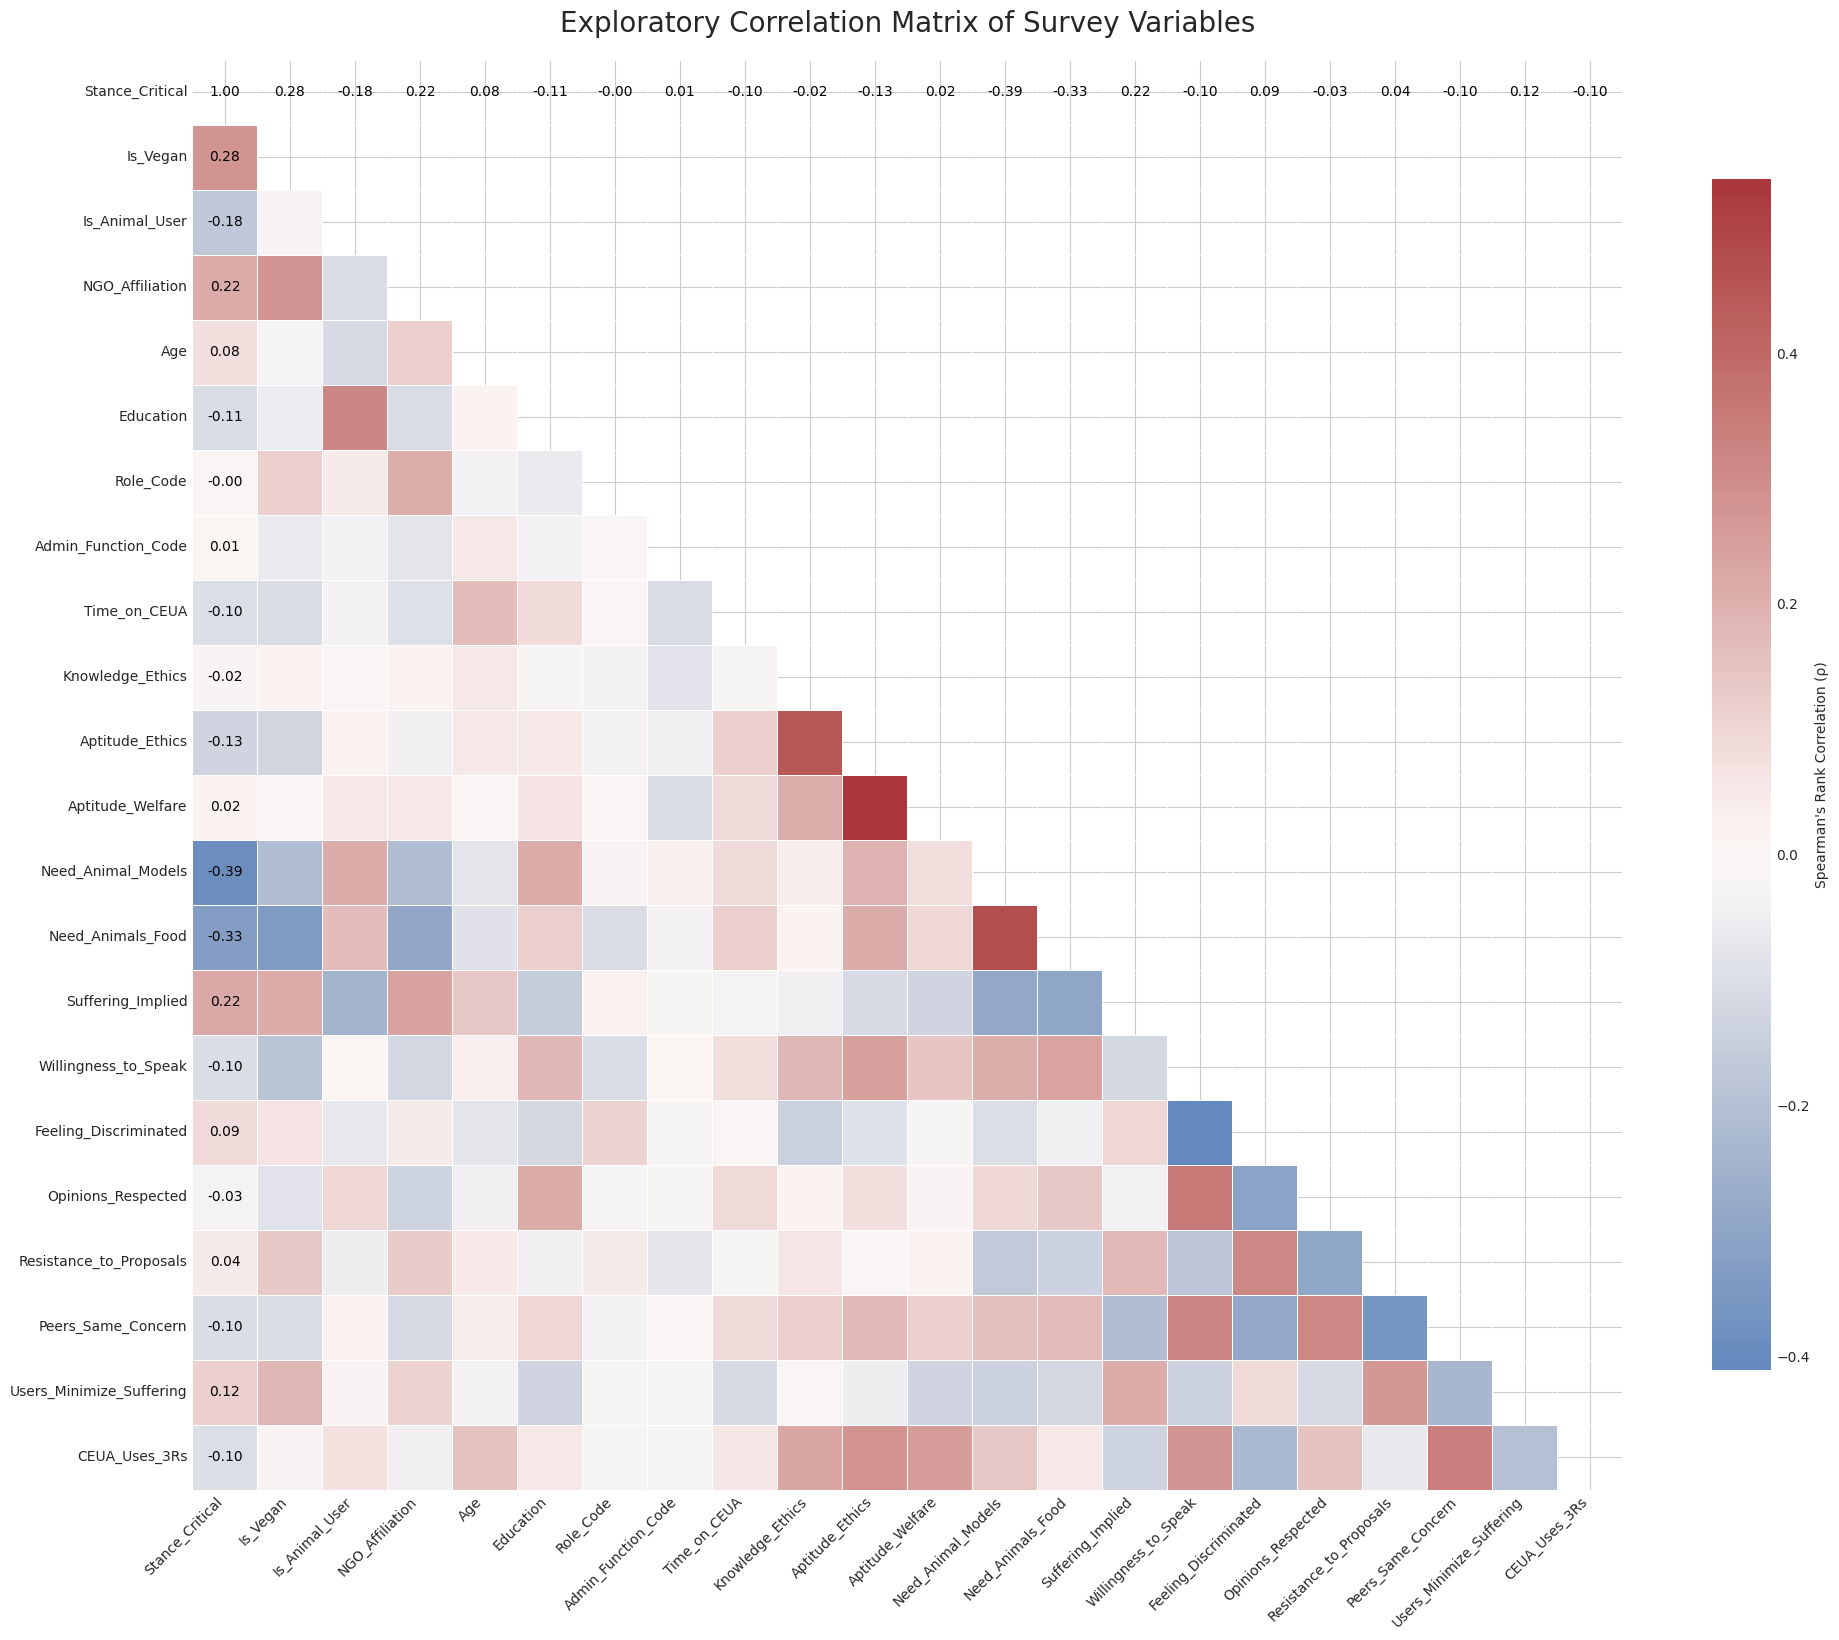

In [53]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def print_methodology_report(df, final_cols):
    """
    Prints a detailed report on the data preparation and methodology for the correlation matrix.
    """
    print("\n" + "="*80)
    print("### Data Dictionary & Methodology for Correlation Matrix ###")
    print("="*80)

    print("\n--- I. Variable Definitions and Preprocessing ---\n")
    
    # Define the descriptions for each variable
    descriptions = {
        'Stance_Critical': "Target Variable. Derived from 'Justifique...codificado(45)'. Binary. Codes 2, 3, 9 ('Critical') mapped to 1; others mapped to 0 ('Favorable').",
        'Is_Vegan': "Derived from '50. Vegano_ou_vegetariano_binario'. Binary. 'Sim' mapped to 1, otherwise 0.",
        'Is_Animal_User': "Derived from '31. Area_em_que_usa_animais_lista'. Binary. Presence of text indicating animal use mapped to 1, 'não uso' or empty mapped to 0.",
        'NGO_Affiliation': "Derived from '9. Vinculo'. Binary. 'Sim' mapped to 1, otherwise 0.",
        'Age': "Derived from '3. Idade'. Ordinal Text. Mapped ranges 'Até 30 anos' through 'Mais de 70 anos' to a numeric scale of 0 to 5.",
        'Education': "Derived from '30. Escolaridade'. Ordinal Text. Mapped 'Graduação' through 'Pós doutorado' to a numeric scale of 0 to 4.",
        'Role_Code': "Derived from 'Papel_na_CEUA_codificado(28)'. Coded Categorical (Nominal). Used directly. Note: Correlation with nominal codes should be interpreted with caution.",
        'Admin_Function_Code': "Derived from 'Funcao_administrativa_na_CEUA_codificado(32)'. Coded Categorical (Nominal). Used directly.",
        'Time_on_CEUA': "Derived from 'tempo_de_CEUA_em_anos_avg(33,34)'. Continuous. Used directly after converting to numeric.",
        'Knowledge_Ethics': "Derived from '35. Conhecimento_formal_em_etica_escala'. Ordinal Scale (1-5). Used directly.",
        'Aptitude_Ethics': "Derived from '39. Aptidao_para_avaliacoes_eticas_escala'. Ordinal Scale (1-5). Used directly.",
        'Aptitude_Welfare': "Derived from '40. Aptidao_para_avaliacoes_de_bem-estar_animal_escala'. Ordinal Scale (1-5). Used directly.",
        'Need_Animal_Models': "Derived from '42. Necessidade_de_uso_de_modelos_animais_escala'. Ordinal Scale (1-5). Used directly.",
        'Need_Animals_Food': "Derived from '43. Necessidade_de_uso_de_animais_na_alimentacao_escala'. Ordinal Scale (1-5). Used directly.",
        'Suffering_Implied': "Derived from '46. Experimentos_cientificos_implicam_sofrimento_animal_escala'. Ordinal Scale (1-5). Used directly.",
        'Willingness_to_Speak': "Derived from '53. Vontade_para_manifestar_posicionamento'. Mixed-Type Ordinal. Processed to a numeric scale 0-3.",
        'Feeling_Discriminated': "Derived from '54. Sente-se_discriminado_nas_reunioes'. Mixed-Type Ordinal. Processed to a numeric scale 0-3.",
        'Opinions_Respected': "Derived from '55. Suas_colocacoes_sao_respeitadas'. Mixed-Type Ordinal. Processed to a numeric scale 0-3.",
        'Resistance_to_Proposals': "Derived from '56. Ha_resistencia_as_suas_propostas'. Mixed-Type Ordinal. Processed to a numeric scale 0-3.",
        'Peers_Same_Concern': "Derived from '57. Demais_membros_atribuem_o_mesmo_nivel_de_preocupacao'. Mixed-Type Ordinal. Processed to a numeric scale 0-3.",
        'Users_Minimize_Suffering': "Derived from '62. Membros_que_pesquisam...minimizam_o_sofrimento...'. Mixed-Type Ordinal. Processed to a numeric scale 0-3.",
        'CEUA_Uses_3Rs': "Derived from '63. O_quanto_a_CEUA_se_baseia_no_principio_dos_3Rs_escala'. Ordinal Scale (1-5). Used directly."
    }

    for col in final_cols:
        if col in descriptions:
            print(f"- {col}:")
            print(textwrap.fill(descriptions[col], 78, initial_indent='  ', subsequent_indent='  '))

    print("\n--- II. Methodology ---\n")
    method_text = (
        f"1. Data Selection: {len(df)} complete rows from active respondents (Ativo=1) were used for this analysis.\n\n"
        "2. Correlation Method: Spearman's Rank Correlation (ρ) was computed for all pairs of variables. This non-parametric method was chosen as it is suitable for measuring monotonic relationships between ordinal variables, which constitute the majority of the data, without assuming linearity.\n\n"
        "3. Handling Missing Data: After initial processing, any remaining missing values (NaNs), primarily from 'Não sei dizer' responses or conversion errors, were imputed using the median of their respective columns. This strategy preserves the full sample size but may introduce a conservative bias by slightly reducing variance.\n\n"
        "4. Visualization: The resulting correlation matrix is displayed as a heatmap. A diverging colormap ('vlag') centered at zero is used to clearly distinguish positive (red) from negative (blue) associations. The upper triangle is masked to reduce redundancy."
    )
    print(method_text)
    print("="*80)


def create_correlation_heatmap():
    """
    Performs a full pipeline: queries the database, preprocesses the data
    to a numeric format, computes a Spearman correlation matrix, and
    visualizes it as a heatmap.
    """
    conn = None
    try:
        # --- 1. Data Loading ---
        conn = sqlite3.connect(DATABASE_NAME)
        # Query all potentially useful columns we identified
        query = """
        SELECT
          "Justifique_experimentacao_animal_ser_mal_necessario_codificado(45)",
          "3. Idade", "4. Genero", "Religiao_codificado(8)", "9. Vinculo",
          "30. Escolaridade", "50. Vegano_ou_vegetariano_binario",
          "Papel_na_CEUA_codificado(28)", "Funcao_administrativa_na_CEUA_codificado(32)",
          "tempo_de_CEUA_em_anos_avg(33,34)", "31. Area_em_que_usa_animais_lista",
          "35. Conhecimento_formal_em_etica_escala",
          "39. Aptidao_para_avaliacoes_eticas_escala",
          "40. Aptidao_para_avaliacoes_de_bem-estar_animal_escala",
          "42. Necessidade_de_uso_de_modelos_animais_escala",
          "43. Necessidade_de_uso_de_animais_na_alimentacao_escala",
          "46. Experimentos_cientificos_implicam_sofrimento_animal_escala",
          "53. Vontade_para_manifestar_posicionamento",
          "54. Sente-se_discriminado_nas_reunioes",
          "55. Suas_colocacoes_sao_respeitadas",
          "56. Ha_resistencia_as_suas_propostas",
          "57. Demais_membros_atribuem_o_mesmo_nivel_de_preocupacao",
          "62. Membros_que_pesquisam_com_modelos_animais_minimizam_o_sofrimento_deles",
          "63. O_quanto_a_CEUA_se_baseia_no_principio_dos_3Rs_escala"
        FROM SurveyAnswers s
        JOIN Respondents r ON s.RespondentID = r."Cod."
        WHERE r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded raw data from database.")

    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return
    finally:
        if conn:
            conn.close()

    # --- 2. Preprocessing & Feature Engineering ---
    # Rename columns for clarity
    df.columns = [
        'Justification_Code', 'Age', 'Gender', 'Religion_Code', 'NGO_Affiliation', 'Education',
        'Is_Vegan', 'Role_Code', 'Admin_Function_Code', 'Time_on_CEUA', 'Animal_Use_Text',
        'Knowledge_Ethics', 'Aptitude_Ethics', 'Aptitude_Welfare', 'Need_Animal_Models',
        'Need_Animals_Food', 'Suffering_Implied', 'Willingness_to_Speak', 'Feeling_Discriminated',
        'Opinions_Respected', 'Resistance_to_Proposals', 'Peers_Same_Concern',
        'Users_Minimize_Suffering', 'CEUA_Uses_3Rs'
    ]

    # a. Create the main target variable
    critical_codes = [2, 3, 9]
    df['Stance_Critical'] = df['Justification_Code'].apply(lambda x: 1 if pd.to_numeric(x, errors='coerce') in critical_codes else 0)

    # b. Create binary User/Non-user variable
    df['Is_Animal_User'] = df['Animal_Use_Text'].apply(lambda x: 0 if pd.isna(x) or 'não uso' in str(x).lower() else 1)
    
    # c. Convert categorical and binary columns to numeric
    df['Is_Vegan'] = df['Is_Vegan'].apply(lambda x: 1 if str(x).strip() == 'Sim' else 0)
    df['NGO_Affiliation'] = df['NGO_Affiliation'].apply(lambda x: 1 if str(x).strip() == 'Sim' else 0)
    
    # d. Map ordinal scales that we KNOW are text
    age_map = {'Até 30 anos': 0, 'Entre 31 e 40 anos': 1, 'Entre 41 e 50 anos': 2, 'Entre 51 e 60 anos': 3, 'Entre 61 e 70 anos': 4, 'Mais de 70 anos': 5}
    education_map = {'Graduação': 0, 'Especialização': 1, 'Mestrado': 2, 'Doutorado': 3, 'Pós doutorado': 4}
    
    df['Age'] = df['Age'].map(age_map)
    df['Education'] = df['Education'].map(education_map)
    
    # Robust mapping for mixed-type ordinal columns
    frequency_map_text = {'Nunca': 0, 'Raramente': 1, 'Frequentemente': 2, 'Constantemente': 3, 'Não sei dizer': np.nan}
    
    mixed_type_cols = [
        'Willingness_to_Speak', 'Feeling_Discriminated', 'Opinions_Respected', 
        'Resistance_to_Proposals', 'Peers_Same_Concern', 'Users_Minimize_Suffering'
    ]

    for col in mixed_type_cols:
        if col in df.columns:
            numeric_part = pd.to_numeric(df[col], errors='coerce')
            text_part = df[col][numeric_part.isnull()].map(frequency_map_text)
            df[col] = numeric_part.combine_first(text_part)

    # e. Select final columns for the matrix
    final_cols = [
        'Stance_Critical', 'Is_Vegan', 'Is_Animal_User', 'NGO_Affiliation', 'Age', 'Education',
        'Role_Code', 'Admin_Function_Code', 'Time_on_CEUA', 'Knowledge_Ethics',
        'Aptitude_Ethics', 'Aptitude_Welfare', 'Need_Animal_Models', 'Need_Animals_Food',
        'Suffering_Implied', 'Willingness_to_Speak', 'Feeling_Discriminated',
        'Opinions_Respected', 'Resistance_to_Proposals', 'Peers_Same_Concern',
        'Users_Minimize_Suffering', 'CEUA_Uses_3Rs'
    ]
    
    # f. Final conversion and imputation
    matrix_df = df[final_cols].apply(pd.to_numeric, errors='coerce')
    
    for col in matrix_df.columns:
        if matrix_df[col].isnull().any():
            median_val = matrix_df[col].median()
            matrix_df[col] = matrix_df[col].fillna(median_val)
    
    print(f"Preprocessing complete. Matrix will be built with {len(matrix_df)} complete rows.")

    # --- 3. Print Methodology Report ---
    print_methodology_report(matrix_df, final_cols)

    # --- 4. Correlation Calculation ---
    corr_matrix = matrix_df.corr(method='spearman')

    # --- 5. Visualization ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 18))

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix,
                mask=mask,
                cmap='vlag',
                center=0,
                annot=False,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .7, "label": "Spearman's Rank Correlation (ρ)"})

    # Manually add annotations for the 'Stance_Critical' row/column
    for i in range(len(corr_matrix.columns)):
        if i > 0:
            ax.text(0.5, i + 0.5, f"{corr_matrix.iloc[i, 0]:.2f}", ha='center', va='center', color='black', fontsize=10)
        ax.text(i + 0.5, 0.5, f"{corr_matrix.iloc[0, i]:.2f}", ha='center', va='center', color='black', fontsize=10)

    ax.set_title('Exploratory Correlation Matrix of Survey Variables', fontsize=20, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return matrix_df

if __name__ == '__main__':
    final_data = create_correlation_heatmap()



In [54]:
import pandas as pd
import sqlite3
from scipy.stats import chi2_contingency
import textwrap
import numpy as np

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def classify_stance(text: str) -> str:
    """
    Classifies a respondent's stance as 'User' or 'Non-user' based on their
    text response, handling nuanced cases of non-use.
    """
    if pd.isna(text) or not text.strip():
        return 'Non-user'
    
    text_lower = text.lower()
    
    non_user_phrases = [
        'não uso', 'hoje não mais', 'no momento não', 'atualmente não'
    ]
    
    if any(phrase in text_lower for phrase in non_user_phrases):
        return 'Non-user'
        
    return 'User'

def get_data_for_test(db_name):
    """
    Queries the database for the two variables needed for the Chi-Square test.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."31. Area_em_que_usa_animais_lista",
          s."44. Experimentacao_animal_e_um_mal_necessario"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for analysis.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform the Chi-Square test and interpret the results.
    """
    df = get_data_for_test(DATABASE_NAME)
    
    if df is not None and not df.empty:
        df.rename(columns={
            '31. Area_em_que_usa_animais_lista': 'AreaOfAnimalUse',
            '44. Experimentacao_animal_e_um_mal_necessario': 'OpinionNecessaryEvil'
        }, inplace=True)

        # --- Data Preparation (IMPROVED) ---
        # Use the more robust classification function
        df['StanceOnExperimentation'] = df['AreaOfAnimalUse'].apply(classify_stance)
        
        # Clean up the response variable
        df['OpinionNecessaryEvil'] = df['OpinionNecessaryEvil'].str.strip()
        df.dropna(subset=['StanceOnExperimentation', 'OpinionNecessaryEvil'], inplace=True)
        df = df[df['OpinionNecessaryEvil'] != '']
        
        # --- (OPTIONAL METHODOLOGICAL CHOICE) ---
        # To run a 2x2 test focusing only on firm opinions, uncomment the next line:
        # df = df[df['OpinionNecessaryEvil'] != 'Não sei dizer']
        
        contingency_table = pd.crosstab(df['StanceOnExperimentation'], df['OpinionNecessaryEvil'])
        
        print("\n--- Contingency Table (Observed Frequencies) ---")
        print(contingency_table)

        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            print("\nWarning: Contingency table is too small for the Chi-Square test.")
            return
            
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        # --- Print Results and Interpretation ---
        print("\n" + "="*50)
        print("### CHI-SQUARE TEST RESULTS ###")
        print("="*50)

        print("\n[1] HYPOTHESIS:")
        hypothesis = "Whether an individual uses animals in their work is associated with their opinion on animal experimentation being a 'necessary evil'."
        null_hypothesis = "There is NO association between using animals in work and the opinion on animal experimentation being a 'necessary evil'."
        print(textwrap.fill(f"H₀ (Null Hypothesis): {null_hypothesis}", 80))
        print(textwrap.fill(f"H₁ (Alternative Hypothesis): {hypothesis}", 80))
        
        print("\n[2] P-VALUE:")
        print(f"The calculated p-value is: {p_value:.4f}")

        print("\n[3] CONCLUSION:")
        alpha = 0.05
        if p_value < alpha:
            print(f"Since the p-value ({p_value:.4f}) is less than our significance level ({alpha}), we REJECT the null hypothesis.")
            print(textwrap.fill("This means there is a statistically significant association between whether a person uses animals in their work and their opinion on it being a 'necessary evil'.", 80))
        else:
            print(f"Since the p-value ({p_value:.4f}) is greater than our significance level ({alpha}), we FAIL TO REJECT the null hypothesis.")
            print(textwrap.fill("This means we do not have sufficient evidence from our data to conclude that there is an association between the two variables.", 80))

        # 4. Effect Size
        print("\n[4] EFFECT SIZE:")
        n = contingency_table.sum().sum()
        #cramers_v = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
        # The corrected formula for Cramer's V
        k = min(contingency_table.shape)
        cramers_v = np.sqrt(chi2 / (n * (k - 1)))
        print(f"Cramer's V: {cramers_v:.4f}")
        interpretation = (
            "Cramer's V measures the strength of the association (0=none, 1=perfect). "
            f"For this test (df={dof}), a value around 0.1 is small, 0.3 is medium, and 0.5 is large."
        )
        print(textwrap.fill(interpretation, 80))
        print("="*50)


if __name__ == '__main__':
    main()

Success: Loaded data for analysis.

--- Contingency Table (Observed Frequencies) ---
OpinionNecessaryEvil     Não  Não sei dizer  Sim
StanceOnExperimentation                         
Non-user                  29              8   25
User                     139             27  141

### CHI-SQUARE TEST RESULTS ###

[1] HYPOTHESIS:
H₀ (Null Hypothesis): There is NO association between using animals in work and
the opinion on animal experimentation being a 'necessary evil'.
H₁ (Alternative Hypothesis): Whether an individual uses animals in their work is
associated with their opinion on animal experimentation being a 'necessary
evil'.

[2] P-VALUE:
The calculated p-value is: 0.5211

[3] CONCLUSION:
Since the p-value (0.5211) is greater than our significance level (0.05), we FAIL TO REJECT the null hypothesis.
This means we do not have sufficient evidence from our data to conclude that
there is an association between the two variables.

[4] EFFECT SIZE:
Cramer's V: 0.0594
Cramer's V measures

Success: Loaded data for analysis.

--- Contingency Table (Observed Frequencies) ---
This table shows the number of respondents in each categorized stance.
JustificationBucket      Critical  Favorable
StanceOnExperimentation                     
Non-user                       21         37
User                           41        257

--- Generating Visualization: Grouped Bar Chart ---


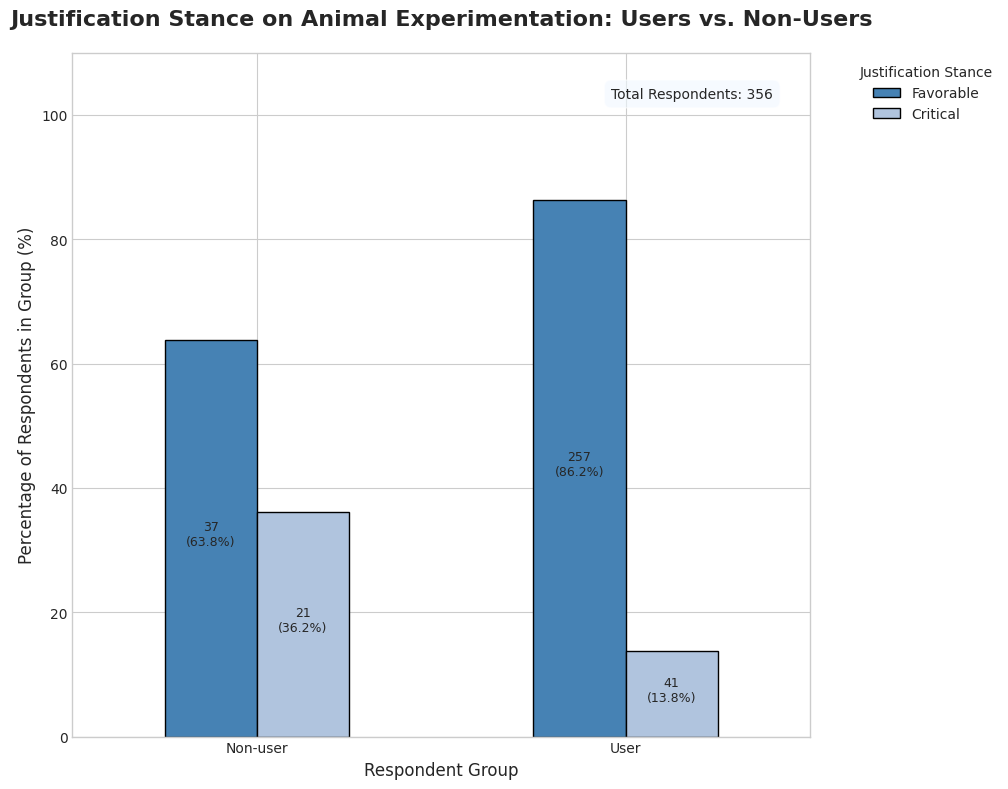


### CHI-SQUARE TEST RESULTS ###

[1] HYPOTHESIS:
H₀ (Null Hypothesis): There is NO association between using animals in work and
their justification stance on animal experimentation.
H₁ (Alternative Hypothesis): Whether an individual uses animals in their work is
associated with their justification stance (Favorable vs. Critical) on animal
experimentation.

[2] P-VALUE:
The calculated p-value is: 0.0001

[3] CONCLUSION:
Since the p-value (0.0001) is less than our significance level (0.05), we REJECT the null hypothesis.
This indicates a statistically significant association between a person's status
as an animal user and their justification stance.

[4] EFFECT SIZE:
Cramer's V: 0.2086
Cramer's V measures the strength of the association (from 0 to 1). Typical
interpretations for this test's degrees of freedom (df=1) are: ~0.1 (small),
~0.3 (medium), ~0.5 (large effect).


In [55]:
import pandas as pd
import sqlite3
from scipy.stats import chi2_contingency
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def classify_stance(text: str) -> str:
    """
    Classifies a respondent's stance as 'User' or 'Non-user' based on their
    text response, handling nuanced cases of non-use.

    Args:
        text: The string response from the survey.

    Returns:
        'User' or 'Non-user'.
    """
    if pd.isna(text) or not text.strip():
        return 'Non-user'

    text_lower = text.lower()

    non_user_phrases = [
        'não uso', 'hoje não mais', 'no momento não', 'atualmente não'
    ]

    if any(phrase in text_lower for phrase in non_user_phrases):
        return 'Non-user'

    return 'User'


def get_data_for_test(db_name):
    """
    Queries the database for the variables needed for the Chi-Square test.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."31. Area_em_que_usa_animais_lista",
          s."Justifique_experimentacao_animal_ser_mal_necessario_codificado(45)" AS JustificationCode
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for analysis.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()


def main():
    """
    Main function to perform the Chi-Square test and interpret the results.
    """
    df = get_data_for_test(DATABASE_NAME)
    
    if df is not None and not df.empty:
        df.rename(columns={'31. Area_em_que_usa_animais_lista': 'AreaOfAnimalUse'}, inplace=True)

        # --- Data Preparation ---
        df['StanceOnExperimentation'] = df['AreaOfAnimalUse'].apply(classify_stance)
        
        df['JustificationCode'] = pd.to_numeric(df['JustificationCode'], errors='coerce')
        df.dropna(subset=['StanceOnExperimentation', 'JustificationCode'], inplace=True)
        
        df = df[df['JustificationCode'] != 0]

        # --- Bucketing Justifications ---
        justification_buckets = {
            1: 'Favorable', 4: 'Favorable', 5: 'Favorable', 6: 'Favorable', 7: 'Favorable', 8: 'Favorable',
            2: 'Critical', 3: 'Critical', 9: 'Critical'
        }
        df['JustificationBucket'] = df['JustificationCode'].map(justification_buckets)
        
        df.dropna(subset=['JustificationBucket'], inplace=True)

        # --- Create a Contingency Table ---
        contingency_table = pd.crosstab(df['StanceOnExperimentation'], df['JustificationBucket'])
        
        print("\n--- Contingency Table (Observed Frequencies) ---")
        print("This table shows the number of respondents in each categorized stance.")
        print(contingency_table)

        
        print("\n--- Generating Visualization: Grouped Bar Chart ---")

        proportions_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
        
        plot_order = ['Favorable', 'Critical']
        proportions_table = proportions_table.reindex(columns=plot_order)

        
        # --- CORRECTED VISUALIZATION CODE ---
        # Use the 'color' argument with a list of colors, not 'colormap'.
        ax = proportions_table.plot(
            kind='bar', 
            figsize=(12, 8), 
            color=['steelblue', 'lightsteelblue'], # Correct parameter with two distinct shades
            edgecolor='black'
        )

        plt.title("Justification Stance on Animal Experimentation: Users vs. Non-Users", fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('Percentage of Respondents in Group (%)', fontsize=12)
        plt.xlabel('Respondent Group', fontsize=12)
        plt.xticks(rotation=0)
        plt.legend(title='Justification Stance', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.ylim(0, 110) # Increased ylim slightly for label padding

        # Add total respondents text box
        total_respondents = contingency_table.sum().sum()
        ax.text(0.95, 0.95, f'Total Respondents: {total_respondents}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.6))

        # Add both absolute and percentage labels to the bars
        categories_in_order = proportions_table.columns
        for i, container in enumerate(ax.containers):
            category = categories_in_order[i]
            # Handle potential KeyError if a category is missing for a group
            absolute_counts = contingency_table.get(category, pd.Series(0, index=contingency_table.index))
            labels = [f'{count}\n({perc:.1f}%)' for count, perc in zip(absolute_counts, container.datavalues)]
            ax.bar_label(container, labels=labels, label_type='center', padding=3, weight='normal', fontsize=9)


        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

        # --- Perform Chi-Square Test ---
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            print("\nWarning: The contingency table has less than two rows or columns.")
            print("Chi-Square test cannot be performed. The data does not have enough variation.")
            return
            
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        # --- Print Results and Interpretation ---
        print("\n" + "="*50)
        print("### CHI-SQUARE TEST RESULTS ###")
        print("="*50)

        print("\n[1] HYPOTHESIS:")
        hypothesis = "Whether an individual uses animals in their work is associated with their justification stance (Favorable vs. Critical) on animal experimentation."
        null_hypothesis = "There is NO association between using animals in work and their justification stance on animal experimentation."
        print(textwrap.fill(f"H₀ (Null Hypothesis): {null_hypothesis}", 80))
        print(textwrap.fill(f"H₁ (Alternative Hypothesis): {hypothesis}", 80))
        
        print("\n[2] P-VALUE:")
        print(f"The calculated p-value is: {p_value:.4f}")

        print("\n[3] CONCLUSION:")
        alpha = 0.05
        if p_value < alpha:
            print(f"Since the p-value ({p_value:.4f}) is less than our significance level ({alpha}), we REJECT the null hypothesis.")
            print(textwrap.fill("This indicates a statistically significant association between a person's status as an animal user and their justification stance.", 80))
        else:
            print(f"Since the p-value ({p_value:.4f}) is greater than our significance level ({alpha}), we FAIL TO REJECT the null hypothesis.")
            print(textwrap.fill("This means we do not have sufficient evidence from our data to conclude that there is an association between the two variables.", 80))

        print("\n[4] EFFECT SIZE:")
        n = contingency_table.sum().sum()
        phi2 = chi2 / n
        r, k = contingency_table.shape
        cramers_v = np.sqrt(phi2 / min(r - 1, k - 1))
        print(f"Cramer's V: {cramers_v:.4f}")
        
        interpretation = (
            "Cramer's V measures the strength of the association (from 0 to 1). "
            "Typical interpretations for this test's degrees of freedom (df=1) are: "
            "~0.1 (small), ~0.3 (medium), ~0.5 (large effect)."
        )
        print(textwrap.fill(interpretation, 80))
        print("="*50)


if __name__ == '__main__':
    main()


In [56]:
import pandas as pd
import sqlite3
from scipy.stats import chi2_contingency
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_data_for_test(db_name):
    """
    Queries the database for the variables needed for the Chi-Square test:
    - '35. Conhecimento_formal_em_etica_escala'
    - 'Justifique_experimentacao_animal_ser_mal_necessario_codificado(45)'
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # MODIFIED QUERY to fetch Ethics Knowledge instead of Animal Use
        query = """
        SELECT
          s."35. Conhecimento_formal_em_etica_escala" AS EthicsKnowledge,
          s."Justifique_experimentacao_animal_ser_mal_necessario_codificado(45)" AS JustificationCode
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for analysis.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()


def main():
    """
    Main function to perform the Chi-Square test and interpret the results.
    """
    df = get_data_for_test(DATABASE_NAME)
    
    if df is not None and not df.empty:
        # --- Data Preparation ---
        df['EthicsKnowledge'] = pd.to_numeric(df['EthicsKnowledge'], errors='coerce')
        df['JustificationCode'] = pd.to_numeric(df['JustificationCode'], errors='coerce')
        df.dropna(subset=['EthicsKnowledge', 'JustificationCode'], inplace=True)
        
        # Exclude the 'Não clasificável' (code 0) category
        df = df[df['JustificationCode'] != 0]

        # --- Bucketing Justifications (Methodology preserved) ---
        justification_buckets = {
            1: 'Favorable', 4: 'Favorable', 5: 'Favorable', 6: 'Favorable', 7: 'Favorable', 8: 'Favorable',
            2: 'Critical', 3: 'Critical', 9: 'Critical'
        }
        df['JustificationBucket'] = df['JustificationCode'].map(justification_buckets)
        
        df.dropna(subset=['JustificationBucket'], inplace=True)

        # --- Create a Contingency Table ---
        # MODIFIED CROSSTAB to use EthicsKnowledge as the index
        contingency_table = pd.crosstab(df['EthicsKnowledge'], df['JustificationBucket'])
        
        print("\n--- Contingency Table (Observed Frequencies) ---")
        print(contingency_table)

        # --- Perform Chi-Square Test ---
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            print("\nWarning: The contingency table is too small for the Chi-Square test.")
            return
            
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        # --- Print Results and Interpretation ---
        print("\n" + "="*50)
        print("### CHI-SQUARE TEST RESULTS ###")
        print("="*50)

        # 1. Hypothesis
        print("\n[1] HYPOTHESIS:")
        hypothesis = "A respondent's self-assessed formal knowledge in ethics is associated with their justification stance (Favorable vs. Critical) on animal experimentation."
        null_hypothesis = "There is NO association between ethics knowledge and justification stance."
        print(textwrap.fill(f"H₀ (Null Hypothesis): {null_hypothesis}", 80))
        print(textwrap.fill(f"H₁ (Alternative Hypothesis): {hypothesis}", 80))
        
        # 2. P-Value
        print("\n[2] P-VALUE:")
        print(f"The calculated p-value is: {p_value:.4f}")

        # 3. Conclusion
        print("\n[3] CONCLUSION:")
        alpha = 0.05
        if p_value < alpha:
            print(f"Since the p-value ({p_value:.4f}) is less than our significance level ({alpha}), we REJECT the null hypothesis.")
            print(textwrap.fill("This indicates a statistically significant association between a person's self-assessed ethics knowledge and their justification stance.", 80))
        else:
            print(f"Since the p-value ({p_value:.4f}) is greater than our significance level ({alpha}), we FAIL TO REJECT the null hypothesis.")
            print(textwrap.fill("This means we do not have sufficient evidence from our data to conclude that there is an association between the two variables.", 80))

        # 4. Effect Size
        print("\n[4] EFFECT SIZE:")
        n = contingency_table.sum().sum()
        r, k = contingency_table.shape
        cramers_v = np.sqrt(chi2 / (n * (min(r, k) - 1)))
        print(f"Cramer's V: {cramers_v:.4f}")
        
        interpretation = (
            "Cramer's V measures the strength of the association (from 0 to 1). "
            f"For this test's degrees of freedom (df={dof}), interpretations can be guided by: "
            "~0.1 (small), ~0.3 (medium), ~0.5 (large effect)."
        )
        print(textwrap.fill(interpretation, 80))
        print("="*50)


if __name__ == '__main__':
    main()


Success: Loaded data for analysis.

--- Contingency Table (Observed Frequencies) ---
JustificationBucket  Critical  Favorable
EthicsKnowledge                         
1                           1          5
2                           1         14
3                          19         72
4                          27        126
5                          14         77

### CHI-SQUARE TEST RESULTS ###

[1] HYPOTHESIS:
H₀ (Null Hypothesis): There is NO association between ethics knowledge and
justification stance.
H₁ (Alternative Hypothesis): A respondent's self-assessed formal knowledge in
ethics is associated with their justification stance (Favorable vs. Critical) on
animal experimentation.

[2] P-VALUE:
The calculated p-value is: 0.6930

[3] CONCLUSION:
Since the p-value (0.6930) is greater than our significance level (0.05), we FAIL TO REJECT the null hypothesis.
This means we do not have sufficient evidence from our data to conclude that
there is an association between the two var

Success: Loaded data for analysis.

Sample sizes:
Vegan/Vegetarian (n=44)
Non-Vegan/Vegetarian (n=325)



/tmp/ipykernel_96998/3014332350.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Non-Vegan/Vegetarian', 'Vegan/Vegetarian'])


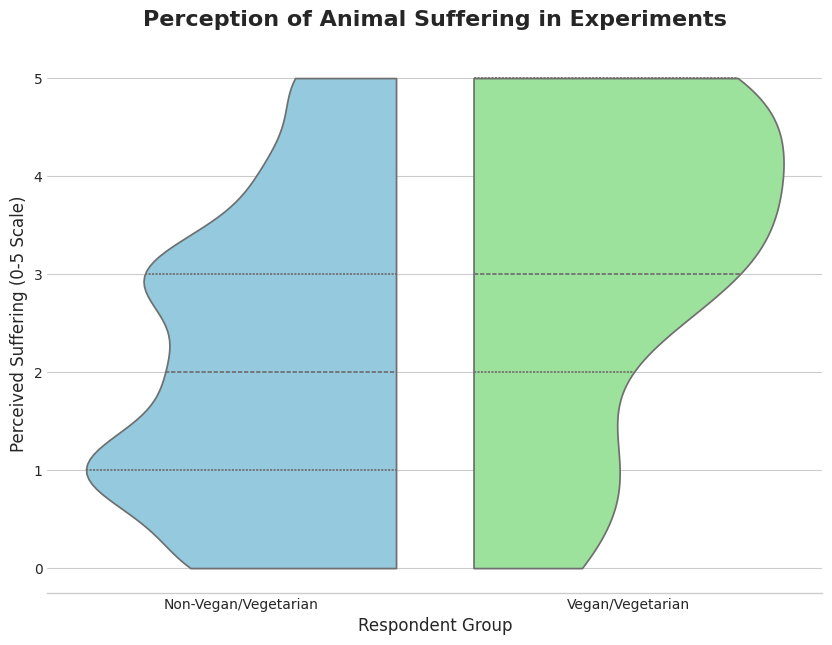


### MANN-WHITNEY U TEST: DETAILED ANALYTICAL REPORT ###
The Mann-Whitney U test is a non-parametric test used to
determine if there is a significant difference between two
independent groups on an ordinal or continuous variable. We
chose this test because our 'SufferingScale' data is ordinal
(ranked) and not assumed to be normally distributed, making
a standard t-test inappropriate.
------------------------------------------------------------

[1] Stating the Hypotheses
------------------------------------------------------------
We formally state our research question as a testable pair
of hypotheses. The Null Hypothesis (H₀) is the default
assumption of no difference, while the Alternative
Hypothesis (H₁) is what we are testing for.

  H₀: The distributions of perceived suffering scores are IDENTICAL for both groups.
  H₁: The distributions of perceived suffering scores are DIFFERENT for the two groups.
------------------------------------------------------------

[2] Descriptive St

In [57]:
import pandas as pd
import sqlite3
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_data_for_test(db_name):
    """
    Queries the database for the variables needed for the Mann-Whitney U test.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."50. Vegano_ou_vegetariano_binario",
          s."46. Experimentos_cientificos_implicam_sofrimento_animal_escala"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for analysis.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform the Mann-Whitney U test and generate a detailed report.
    """
    df = get_data_for_test(DATABASE_NAME)
    
    if df is not None and not df.empty:
        # --- Data Preparation ---
        df.rename(columns={
            '50. Vegano_ou_vegetariano_binario': 'IsVegan',
            '46. Experimentos_cientificos_implicam_sofrimento_animal_escala': 'SufferingScale'
        }, inplace=True)
        df['SufferingScale'] = pd.to_numeric(df['SufferingScale'], errors='coerce')
        df['IsVegan'] = df['IsVegan'].str.strip()
        df.dropna(subset=['IsVegan', 'SufferingScale'], inplace=True)

        vegan_group = df[df['IsVegan'] == 'Sim']['SufferingScale']
        non_vegan_group = df[df['IsVegan'] == 'Não']['SufferingScale']
        
        n1, n2 = len(vegan_group), len(non_vegan_group)
        print(f"\nSample sizes:\nVegan/Vegetarian (n={n1})\nNon-Vegan/Vegetarian (n={n2})\n")

        # --- Visualization ---
        plt.figure(figsize=(10, 7))
        sns.set_style("whitegrid")
        ax = sns.violinplot(x='IsVegan', y='SufferingScale', data=df,
                              order=['Não', 'Sim'], palette=['skyblue', 'lightgreen'],
                              split=True, inner='quartiles', cut=0)
        
        plt.title('Perception of Animal Suffering in Experiments', fontsize=16, fontweight='bold', pad=20)
        ax.set_xticklabels(['Non-Vegan/Vegetarian', 'Vegan/Vegetarian'])
        ax.set_xlabel('Respondent Group', fontsize=12)
        ax.set_ylabel('Perceived Suffering (0-5 Scale)', fontsize=12)
        sns.despine(left=True)
        plt.show()

        # --- Perform Mann-Whitney U Test ---
        if n1 < 1 or n2 < 1:
            print("\nError: One or both sample groups are empty.")
            return
            
        u_stat, p_value = mannwhitneyu(vegan_group, non_vegan_group, alternative='two-sided')

        # --- CORRECTED Effect Size Calculation ---
        # Calculate the magnitude of the Rank-Biserial Correlation
        effect_size_r_magnitude = abs(1 - (2 * u_stat) / (n1 * n2))

        # Programmatically determine the correct sign based on the medians
        if vegan_group.median() > non_vegan_group.median():
            effect_size_r = effect_size_r_magnitude
        elif vegan_group.median() < non_vegan_group.median():
            effect_size_r = -effect_size_r_magnitude
        else:
            effect_size_r = 0 # No difference in medians means zero effect

        # --- DETAILED REPORT GENERATION ---
        
        # Introduction to the Test
        print("\n" + "="*60)
        print("### MANN-WHITNEY U TEST: DETAILED ANALYTICAL REPORT ###")
        print("="*60)
        intro_text = (
            "The Mann-Whitney U test is a non-parametric test used to determine if there is a "
            "significant difference between two independent groups on an ordinal or continuous "
            "variable. We chose this test because our 'SufferingScale' data is ordinal (ranked) "
            "and not assumed to be normally distributed, making a standard t-test inappropriate."
        )
        print(textwrap.fill(intro_text, 60))
        print("-" * 60)

        # 1. Hypothesis
        print("\n[1] Stating the Hypotheses")
        print("-" * 60)
        hypothesis_text = (
            "We formally state our research question as a testable pair of hypotheses. The "
            "Null Hypothesis (H₀) is the default assumption of no difference, while the "
            "Alternative Hypothesis (H₁) is what we are testing for."
        )
        print(textwrap.fill(hypothesis_text, 60))
        print(f"\n  H₀: The distributions of perceived suffering scores are IDENTICAL for both groups.")
        print(f"  H₁: The distributions of perceived suffering scores are DIFFERENT for the two groups.")
        print("-" * 60)

        # 2. Descriptive Statistics
        print("\n[2] Descriptive Statistics: A First Look at the Data")
        print("-" * 60)
        descriptive_text = (
            "Before testing our hypothesis, we examine the central tendency of each group. Since "
            "the data is ordinal, the **median** (the middle value) is the most appropriate measure. "
            "It tells us the score at which 50% of the group responded at or above."
        )
        print(textwrap.fill(descriptive_text, 60))
        print(f"\n  Median Score (Vegan/Vegetarian Group): {vegan_group.median():.2f}")
        print(f"  Median Score (Non-Vegan/Vegetarian Group): {non_vegan_group.median():.2f}")
        print("\n" + textwrap.fill("Observation: The median for the vegan/vegetarian group is higher. The next step is to determine if this observed difference is statistically significant or likely due to random chance.", 60))
        print("-" * 60)

        # 3. Inferential Statistics
        print("\n[3] Inferential Statistics: Testing for Significance")
        print("-" * 60)
        inferential_text = (
            "This is the core of the test. The **p-value** represents the probability of observing a difference "
            "this large (or larger) between our groups purely by chance, assuming H₀ is true. A small "
            "p-value (typically < 0.05) suggests the observed difference is real."
        )
        print(textwrap.fill(inferential_text, 60))
        print(f"\n  Mann-Whitney U statistic: {u_stat:.1f}")
        print(f"  Calculated p-value: {p_value:.4f}")
        print("-" * 60)

        # 4. Effect Size (with CORRECTED text)
        print("\n[4] Effect Size: Measuring the Magnitude of the Difference")
        print("-" * 60)
        effect_size_text = (
            "A small p-value tells us the difference is significant, but not how *large* it is. "
            "For this, we calculate the **Rank-Biserial Correlation (r)**. This value ranges from -1 to 1 "
            "and measures the strength of the difference between the groups."
        )
        print(textwrap.fill(effect_size_text, 60))
        print(f"\n  Rank-Biserial Correlation (r): {effect_size_r:.4f}")
        print("\n" + textwrap.fill("Interpretation Guide: |0.1| is a small effect, |0.3| is a medium effect, and |0.5| is a large effect. The positive sign indicates the first group (Vegan/Vegetarian) tends to have higher scores.", 60))
        print("-" * 60)
        
        # 5. Conclusion (with CORRECTED text)
        print("\n[5] Analytical Conclusion")
        print("-" * 60)
        alpha = 0.05
        if p_value < alpha:
            conclusion_text = (
                f"The p-value ({p_value:.4f}) is less than our significance level of {alpha}. Therefore, we "
                f"**reject the Null Hypothesis**. There is strong statistical evidence to conclude that a "
                f"significant difference exists in the distribution of perceived suffering scores between "
                f"vegans/vegetarians and non-vegetarians, with the vegan/vegetarian group tending to report higher scores. "
                f"The effect size (r={effect_size_r:.2f}) indicates that the magnitude of this difference is [EFFECT]."
            )
            abs_r = abs(effect_size_r)
            if abs_r < 0.3:
                magnitude = "small to medium"
            elif abs_r < 0.5:
                magnitude = "medium to large"
            else:
                magnitude = "large"
            conclusion_text = conclusion_text.replace("[EFFECT]", magnitude)
            print(textwrap.fill(conclusion_text, 60))
        else:
            conclusion_text = (
                f"The p-value ({p_value:.4f}) is greater than our significance level of {alpha}. Therefore, we "
                f"**fail to reject the Null Hypothesis**. We do not have sufficient statistical evidence to "
                f"conclude that a difference exists between the two groups based on this data."
            )
            print(textwrap.fill(conclusion_text, 60))
        print("="*60)

if __name__ == '__main__':
    main()

Success: Loaded data for animal use and suffering perception.

--- Descriptive Statistics by Group ---
             count      mean       std  min  25%  50%  75%  max
UsesAnimals                                                    
Non-User      54.0  3.074074  1.502851  0.0  2.0  3.0  4.0  5.0
User         315.0  2.053968  1.547633  0.0  1.0  2.0  3.0  5.0

--- Generating Visualization ---


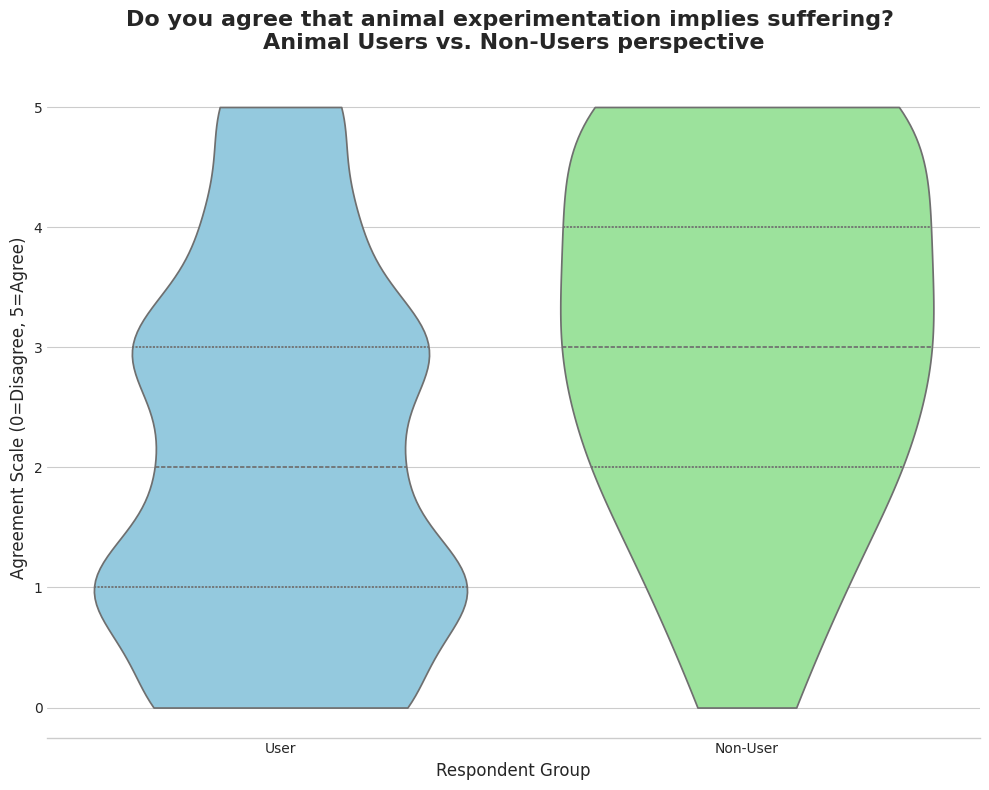


--- Chi-Squared Test of Independence ---
Contingency Table:
SufferingScale   0   1   2   3   4   5
UsesAnimals                           
Non-User         3   6  10  12  11  12
User            56  85  47  68  31  28

Chi-Squared Statistic (χ²): 21.4611
P-value: 0.0007
Degrees of Freedom: 5

--- Interpretation of Results ---
Significance level (α): 0.05
Null Hypothesis (H₀): There is no association between a respondent's status as an animal user and their level of agreement that scientific experiments imply suffering.

Conclusion: Since the p-value (0.0007) is less than 0.05, we reject the null hypothesis.
There is a statistically significant association between using animals professionally and the perception of animal suffering in experiments.

Assumption Check: All expected cell frequencies are 5 or greater. The test is considered reliable.


In [58]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np


# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_data_for_analysis(db_name):
    """
    Queries the database to get the necessary columns for the analysis:
    - '31. Area_em_que_usa_animais_lista' to define the groups.
    - '46. Experimentos_cientificos_implicam_sofrimento_animal_escala' for the opinion.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."31. Area_em_que_usa_animais_lista" AS AnimalUse,
          s."46. Experimentos_cientificos_implicam_sofrimento_animal_escala" AS SufferingScale
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for animal use and suffering perception.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform the analysis, now featuring a violin plot
    with a consistent visual style.
    """
    df = get_data_for_analysis(DATABASE_NAME)
    
    if df is not None and not df.empty:
        # --- 1. Data Preparation ---
        # Create the binary 'UsesAnimals' group variable.
        df['UsesAnimals'] = np.where(df['AnimalUse'] == 'Não uso animais', 'Non-User', 'User')
        
        # Ensure the scale is treated as a clean integer, handling potential non-numeric data
        df['SufferingScale'] = pd.to_numeric(df['SufferingScale'], errors='coerce')
        df.dropna(subset=['SufferingScale'], inplace=True)
        df['SufferingScale'] = df['SufferingScale'].astype(int)

        # --- 2. Descriptive Statistics (Optional but good practice) ---
        print("\n--- Descriptive Statistics by Group ---")
        print(df.groupby('UsesAnimals')['SufferingScale'].describe())

        # --- 3. Visualization: Violin Plot ---
        print("\n--- Generating Visualization ---")
        
        plt.figure(figsize=(10, 8))
        sns.set_style("whitegrid")
        ax = sns.violinplot(
            data=df,
            x='UsesAnimals',
            y='SufferingScale',
            order=['User', 'Non-User'], # Specify order for consistency
            # MODIFICATION: Apply the requested color palette and styling
            palette=['skyblue', 'lightgreen'],
            inner='quartiles', # Shows the median and interquartile range
            cut=0 # Trims the violins to the data range
        )
        
        plt.title('Do you agree that animal experimentation implies suffering? \nAnimal Users vs. Non-Users perspective', fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('Agreement Scale (0=Disagree, 5=Agree)', fontsize=12)
        plt.xlabel('Respondent Group', fontsize=12)
        
        # Set y-axis ticks to be integers representing the scale
        ax.set_yticks(range(6))
        ax.set_yticklabels([f'{i}' for i in range(6)])
        
        # MODIFICATION: Remove the left axis spine for a cleaner look
        sns.despine(left=True)
        
        plt.tight_layout()
        plt.show()

        # --- 4. Chi-Squared Test (Kept for statistical association) ---
        print("\n--- Chi-Squared Test of Independence ---")
        contingency_table = pd.crosstab(df['UsesAnimals'], df['SufferingScale'])
        print("Contingency Table:")
        print(contingency_table)
        
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        
        print(f"\nChi-Squared Statistic (χ²): {chi2:.4f}")
        print(f"P-value: {p:.4f}")
        print(f"Degrees of Freedom: {dof}")
        
        # --- 5. Interpretation ---
        print("\n--- Interpretation of Results ---")
        alpha = 0.05
        print(f"Significance level (α): {alpha}")
        print("Null Hypothesis (H₀): There is no association between a respondent's status as an animal user and their level of agreement that scientific experiments imply suffering.")
        
        if p < alpha:
            print(f"\nConclusion: Since the p-value ({p:.4f}) is less than {alpha}, we reject the null hypothesis.")
            print("There is a statistically significant association between using animals professionally and the perception of animal suffering in experiments.")
        else:
            print(f"\nConclusion: Since the p-value ({p:.4f}) is not less than {alpha}, we fail to reject the null hypothesis.")
            print("There is not enough evidence to conclude a statistically significant association exists between the two variables.")

        if (expected < 5).any():
            print("\nWarning: The Chi-Squared test assumption of expected frequencies > 5 in each cell is violated.")
            print("The results should be interpreted with caution.")
        else:
            print("\nAssumption Check: All expected cell frequencies are 5 or greater. The test is considered reliable.")


if __name__ == '__main__':
    main()




### SPEARMAN'S RANK CORRELATION: DETAILED ANALYTICAL REPORT ###
Spearman's rank correlation (rho, ρ) is a non-parametric test that
measures the strength and direction of a monotonic relationship
between two ranked or ordinal variables. Unlike Pearson's correlation,
it does not assume a linear relationship, making it ideal here.
----------------------------------------------------------------------

[1] Stating the Hypotheses
----------------------------------------------------------------------
H₀ (Null Hypothesis): There is NO monotonic association between a member's
time on a CEUA and their self-perceived ethical aptitude.

H₁ (Alternative Hypothesis): There IS a monotonic association between the
two variables.
----------------------------------------------------------------------

[2] Inferential Statistics & Effect Size
----------------------------------------------------------------------
The correlation coefficient (rho) is itself a measure of effect size.

  Spearman's rho (ρ):

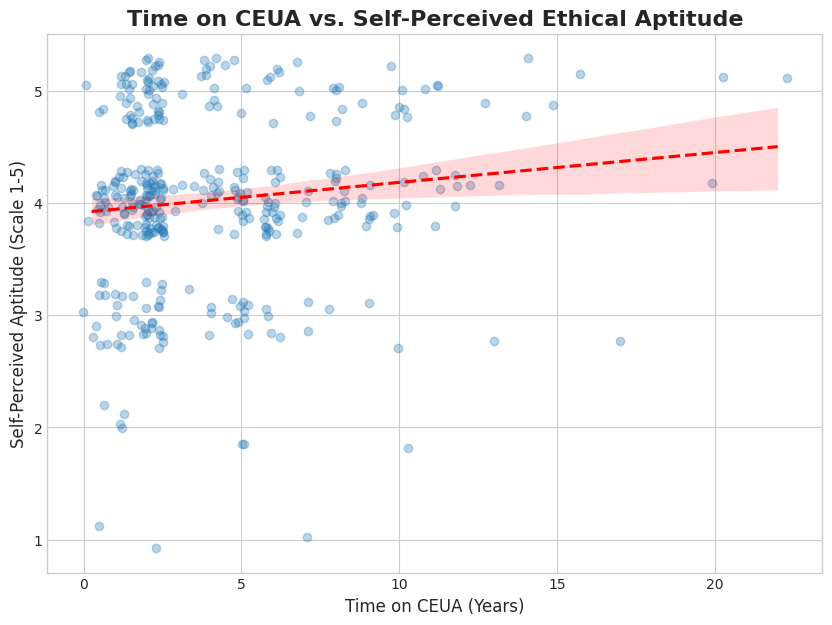


### VALIDITY CHECKS FOR SPEARMAN CORRELATION ###

[1] Sensitivity Analysis (excluding TimeOnCEUA > 15 years)
----------------------------------------------------------------------
Original sample size: 369
Filtered sample size: 364
Original rho: 0.1122 (p-value: 0.0312)
Filtered rho: 0.1030 (p-value: 0.0496)
 Conclusion: Compare the original and filtered results. If they are
very similar, our initial conclusion is robust. If they differ
significantly, the outliers had a strong influence.


[2] Bootstrapping (1000 iterations)
----------------------------------------------------------------------
95% Confidence Interval for rho: [0.0008, 0.2101]
 Conclusion: A confidence interval tells us the range where the true
correlation likely lies. If this interval does not contain 0, we can
be confident that the relationship is statistically significant and
stable.


In [59]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_data_for_correlation(db_name):
    """Queries for time on CEUA and self-assessed ethical aptitude."""
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."tempo_de_CEUA_em_anos_avg(33,34)" AS TimeOnCEUA,
          s."39. Aptidao_para_avaliacoes_eticas_escala" AS EthicalAptitude
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    df = get_data_for_correlation(DATABASE_NAME)
    if df is None or df.empty:
        print("Could not load data. Aborting analysis.")
        return

    # --- Data Cleaning ---
    df['TimeOnCEUA'] = pd.to_numeric(df['TimeOnCEUA'], errors='coerce')
    df['EthicalAptitude'] = pd.to_numeric(df['EthicalAptitude'], errors='coerce')
    df.dropna(inplace=True)

    # --- Perform Spearman Correlation Test ---
    rho, p_value = spearmanr(df['TimeOnCEUA'], df['EthicalAptitude'])

    # --- GENERATE THE DETAILED REPORT ---
    print("\n" + "="*70)
    print("### SPEARMAN'S RANK CORRELATION: DETAILED ANALYTICAL REPORT ###")
    print("="*70)
    # ... (The full report generation code is here, identical to before) ...
    intro_text = (
        "Spearman's rank correlation (rho, ρ) is a non-parametric test that "
        "measures the strength and direction of a monotonic relationship "
        "between two ranked or ordinal variables. Unlike Pearson's correlation, "
        "it does not assume a linear relationship, making it ideal here."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)
    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀ (Null Hypothesis): There is NO monotonic association between a member's")
    print("time on a CEUA and their self-perceived ethical aptitude.")
    print("\nH₁ (Alternative Hypothesis): There IS a monotonic association between the")
    print("two variables.")
    print("-" * 70)
    print("\n[2] Inferential Statistics & Effect Size")
    print("-" * 70)
    print("The correlation coefficient (rho) is itself a measure of effect size.")
    print(f"\n  Spearman's rho (ρ): {rho:.4f}")
    print(f"  Calculated p-value: {p_value:.4f}\n")
    interpretation_guide = (
        "Interpretation Guide for |ρ|:\n"
        "  • 0.00 - 0.30: Weak correlation\n"
        "  • 0.30 - 0.60: Moderate correlation\n"
        "  • 0.60 - 1.00: Strong correlation\n"
        "The sign of ρ indicates the direction (positive or negative)."
    )
    print(interpretation_guide)
    print("-" * 70)
    print("\n[3] Analytical Conclusion")
    print("-" * 70)
    alpha = 0.05
    if p_value < alpha:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is less than our significance level of {alpha}. "
            f"Therefore, we REJECT the Null Hypothesis. There is a statistically "
            f"significant, although weak, positive monotonic relationship between "
            f"time served on a CEUA and self-perceived ethical aptitude. As experience "
            f"increases, aptitude tends to increase as well."
        )
        print(textwrap.fill(conclusion_text, 70))
    else:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is greater than our significance level of {alpha}. "
            f"Therefore, we FAIL TO REJECT the Null Hypothesis. We do not have "
            f"sufficient statistical evidence to conclude that an association exists "
            f"between time on a CEUA and self-perceived ethical aptitude."
        )
        print(textwrap.fill(conclusion_text, 70))
    print("="*70)

    # --- Visualization ---
    plt.figure(figsize=(10, 7))
    sns.set_style("whitegrid")
    sns.regplot(x='TimeOnCEUA', y='EthicalAptitude', data=df,
                x_jitter=0.3, y_jitter=0.3,
                scatter_kws={'alpha': 0.3},
                line_kws={'color': 'red', 'linestyle': '--'})
    plt.title('Time on CEUA vs. Self-Perceived Ethical Aptitude', fontsize=16, fontweight='bold')
    plt.xlabel('Time on CEUA (Years)', fontsize=12)
    plt.ylabel('Self-Perceived Aptitude (Scale 1-5)', fontsize=12)
    plt.show()

    # --- *** INTEGRATED VALIDITY CHECKS START HERE *** ---
    print("\n" + "="*70)
    print("### VALIDITY CHECKS FOR SPEARMAN CORRELATION ###")
    print("="*70)

    # --- Method 1: Sensitivity Analysis ---
    df_filtered = df[df['TimeOnCEUA'] <= 15]
    rho_filtered, p_filtered = spearmanr(df_filtered['TimeOnCEUA'], df_filtered['EthicalAptitude'])
    print("\n[1] Sensitivity Analysis (excluding TimeOnCEUA > 15 years)")
    print("-" * 70)
    print(f"Original sample size: {len(df)}")
    print(f"Filtered sample size: {len(df_filtered)}")
    print(f"Original rho: {rho:.4f} (p-value: {p_value:.4f})")
    print(f"Filtered rho: {rho_filtered:.4f} (p-value: {p_filtered:.4f})")
    print(textwrap.fill("\nConclusion: Compare the original and filtered results. If they are very similar, our initial conclusion is robust. If they differ significantly, the outliers had a strong influence.", 70))

    # --- Method 2: Bootstrapping ---
    n_iterations = 1000
    bootstrap_rhos = []
    # Set a seed for reproducibility
    np.random.seed(42)
    for i in range(n_iterations):
        indices = np.random.choice(df.index, size=len(df), replace=True)
        sample = df.loc[indices]
        rho_sample, _ = spearmanr(sample['TimeOnCEUA'], sample['EthicalAptitude'])
        bootstrap_rhos.append(rho_sample)
    
    alpha_ci = 0.95
    lower_bound = np.quantile(bootstrap_rhos, (1-alpha_ci)/2)
    upper_bound = np.quantile(bootstrap_rhos, alpha_ci+(1-alpha_ci)/2)
    print("\n\n[2] Bootstrapping (1000 iterations)")
    print("-" * 70)
    print(f"95% Confidence Interval for rho: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(textwrap.fill("\nConclusion: A confidence interval tells us the range where the true correlation likely lies. If this interval does not contain 0, we can be confident that the relationship is statistically significant and stable.", 70))
    print("="*70)

    # # Optional: Visualize the bootstrap distribution
    # plt.figure(figsize=(8, 5))
    # sns.histplot(bootstrap_rhos, kde=True)
    # plt.title('Bootstrap Distribution of Spearman Rho')
    # plt.xlabel('Rho Value')
    # plt.axvline(lower_bound, color='red', linestyle='--')
    # plt.axvline(upper_bound, color='red', linestyle='--')
    # plt.show()

if __name__ == '__main__':
    main()


Success: Loaded data for ethics education and ethical aptitude.
Data Cleaning: Retained 369 of 369 respondents with complete data.

--- Generating Visualization ---


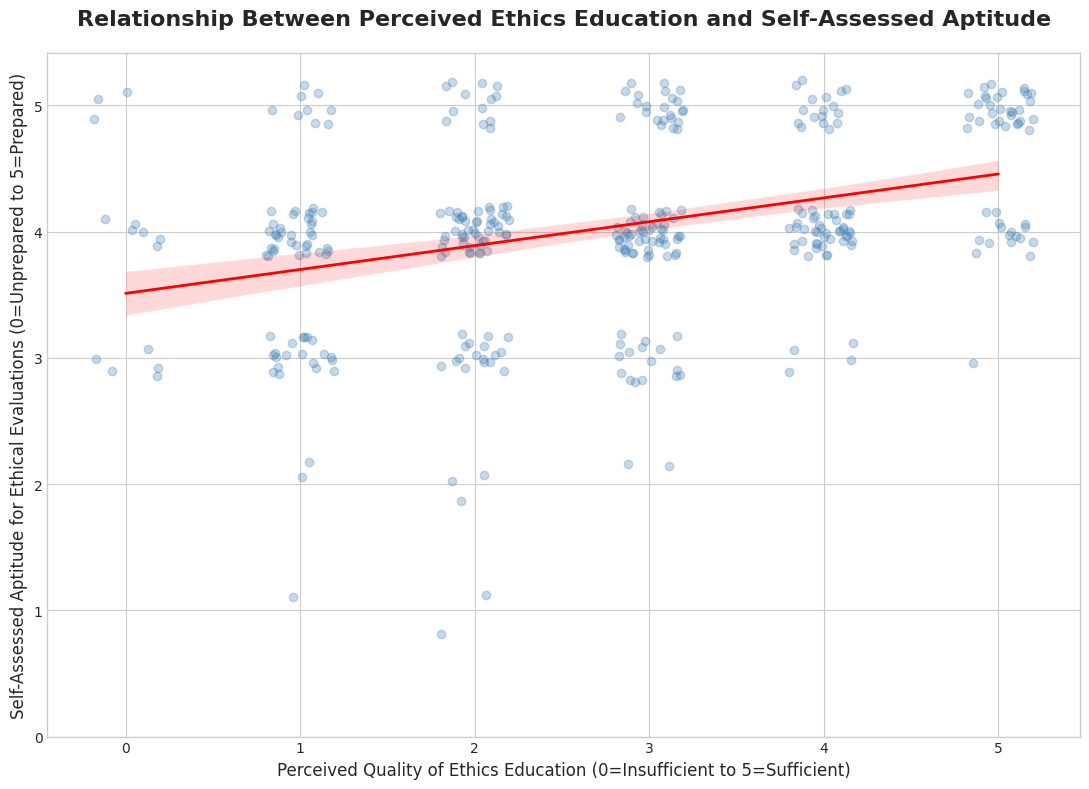


### SPEARMAN'S RANK CORRELATION: DETAILED ANALYTICAL REPORT ###
This analysis investigates the relationship between two ordinal
variables: the perceived quality of a respondent's ethics education
and their self-assessed aptitude for conducting ethical evaluations.
Spearman's rank correlation (rho) is the appropriate non-parametric
test to measure the strength and direction of a monotonic relationship
between such ranked data.
----------------------------------------------------------------------

[1] Stating the Hypotheses
----------------------------------------------------------------------
 H₀ (Null Hypothesis): There is NO monotonic correlation between the variables.
 H₁ (Alternative Hypothesis): There IS a monotonic correlation between the variables.
----------------------------------------------------------------------

[2] Statistical Results
----------------------------------------------------------------------
  Spearman's Correlation Coefficient (rho): 0.3517
  P-value: 0.00

In [60]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
import textwrap
import warnings

# Suppress non-critical warnings for a polished presentation
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_data_for_correlation(db_name):
    """
    Queries the database to get the two ordinal variables for correlation analysis.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."36. Ensino_de_etica_na_sua_formação_escala" AS EthicsEducation,
          s."39. Aptidao_para_avaliacoes_eticas_escala" AS EthicalAptitude
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for ethics education and ethical aptitude.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and report the Spearman's Rank Correlation analysis.
    """
    df = get_data_for_correlation(DATABASE_NAME)

    if df is not None and not df.empty:
        # --- 1. Data Cleaning and Preparation ---
        # Convert columns to numeric, coercing errors to NaN
        df['EthicsEducation'] = pd.to_numeric(df['EthicsEducation'], errors='coerce')
        df['EthicalAptitude'] = pd.to_numeric(df['EthicalAptitude'], errors='coerce')

        # Drop rows with any missing values to ensure complete pairs for correlation
        original_count = len(df)
        df.dropna(inplace=True)
        cleaned_count = len(df)
        print(f"Data Cleaning: Retained {cleaned_count} of {original_count} respondents with complete data.")

        if cleaned_count < 2:
            print("\nError: Not enough data to perform correlation analysis after cleaning.")
            return

        # --- 2. Exploratory Visualization: Jittered Scatterplot ---
        print("\n--- Generating Visualization ---")
        plt.figure(figsize=(11, 8))
        sns.set_style("whitegrid")

        # Use regplot with jitter to visualize the relationship between two ordinal variables
        ax = sns.regplot(
            data=df,
            x='EthicsEducation',
            y='EthicalAptitude',
            x_jitter=0.2,  # Add horizontal jitter to see point density
            y_jitter=0.2,  # Add vertical jitter
            scatter_kws={'alpha': 0.3, 'color': 'steelblue'}, # Make points semi-transparent
            line_kws={'color': 'red', 'linewidth': 2} # Style the regression line
        )

        plt.title('Relationship Between Perceived Ethics Education and Self-Assessed Aptitude', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Perceived Quality of Ethics Education (0=Insufficient to 5=Sufficient)', fontsize=12)
        plt.ylabel('Self-Assessed Aptitude for Ethical Evaluations (0=Unprepared to 5=Prepared)', fontsize=12)

        # Ensure ticks are integers for the scales
        ax.set_xticks(range(6))
        ax.set_yticks(range(6))

        plt.tight_layout()
        plt.show()

        # --- 3. Statistical Test: Spearman's Rank Correlation ---
        correlation, p_value = spearmanr(df['EthicsEducation'], df['EthicalAptitude'])

        # --- 4. Comprehensive Interpretation and Reporting ---
        print("\n" + "="*70)
        print("### SPEARMAN'S RANK CORRELATION: DETAILED ANALYTICAL REPORT ###")
        print("="*70)

        # Introduction to the Test
        intro_text = (
            "This analysis investigates the relationship between two ordinal variables: the "
            "perceived quality of a respondent's ethics education and their self-assessed "
            "aptitude for conducting ethical evaluations. Spearman's rank correlation (rho) "
            "is the appropriate non-parametric test to measure the strength and direction of a "
            "monotonic relationship between such ranked data."
        )
        print(textwrap.fill(intro_text, 70))
        print("-" * 70)

        # Hypotheses
        print("\n[1] Stating the Hypotheses")
        print("-" * 70)
        print(" H₀ (Null Hypothesis): There is NO monotonic correlation between the variables.")
        print(" H₁ (Alternative Hypothesis): There IS a monotonic correlation between the variables.")
        print("-" * 70)

        # Results
        print("\n[2] Statistical Results")
        print("-" * 70)
        print(f"  Spearman's Correlation Coefficient (rho): {correlation:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Sample Size (n): {cleaned_count}")
        print("-" * 70)

        # Interpretation of Results
        print("\n[3] Interpretation")
        print("-" * 70)
        alpha = 0.05
        
        # Significance
        if p_value < alpha:
            significance_text = (
                f"The p-value ({p_value:.4f}) is less than our significance level of {alpha}. "
                "Therefore, we REJECT the Null Hypothesis. The observed correlation is "
                "statistically significant and is unlikely to be due to random chance."
            )
        else:
            significance_text = (
                f"The p-value ({p_value:.4f}) is not less than our significance level of {alpha}. "
                "Therefore, we FAIL to reject the Null Hypothesis. We do not have sufficient "
                "statistical evidence to conclude that a correlation exists between the variables."
            )
        print(textwrap.fill(significance_text, 70))
        
        # Strength and Direction
        abs_corr = abs(correlation)
        if abs_corr >= 0.7:
            strength = "strong"
        elif abs_corr >= 0.4:
            strength = "moderate"
        elif abs_corr >= 0.1:
            strength = "weak"
        else:
            strength = "very weak or non-existent"

        if correlation > 0:
            direction = "positive"
        elif correlation < 0:
            direction = "negative"
        else:
            direction = "no"

        strength_text = (
            f"The correlation coefficient (rho = {correlation:.2f}) indicates a {strength} {direction} "
            "monotonic relationship. This means that as the perceived quality of ethics education "
            "increases, the self-assessed aptitude for ethical evaluations also tends to increase."
        )
        if p_value < alpha:
             print("\n" + textwrap.fill(strength_text, 70))
        print("-" * 70)

        # Final Conclusion
        print("\n[4] Final Conclusion")
        print("="*70)
        if p_value < alpha:
            final_text = (
                "There is a statistically significant, positive relationship between how well "
                "respondents feel they were taught ethics and how prepared they feel to make ethical "
                "evaluations. Those who report a more sufficient educational background in ethics also "
                f"tend to report a higher aptitude for the task. The strength of this relationship is {strength}."
            )
        else:
            final_text = (
                "Based on this analysis, we cannot conclude that a significant relationship exists "
                "between a respondent's ethics education and their self-assessed aptitude. The "
                "observed trend is not strong enough to be distinguished from random chance."
            )
        print(textwrap.fill(final_text, 70))
        print("="*70)

if __name__ == '__main__':
    main()


Success: Loaded data for animal welfare education and aptitude.
Data Cleaning: Retained 369 of 369 respondents with complete data.

--- Generating Visualization 1: Jittered Scatterplot ---


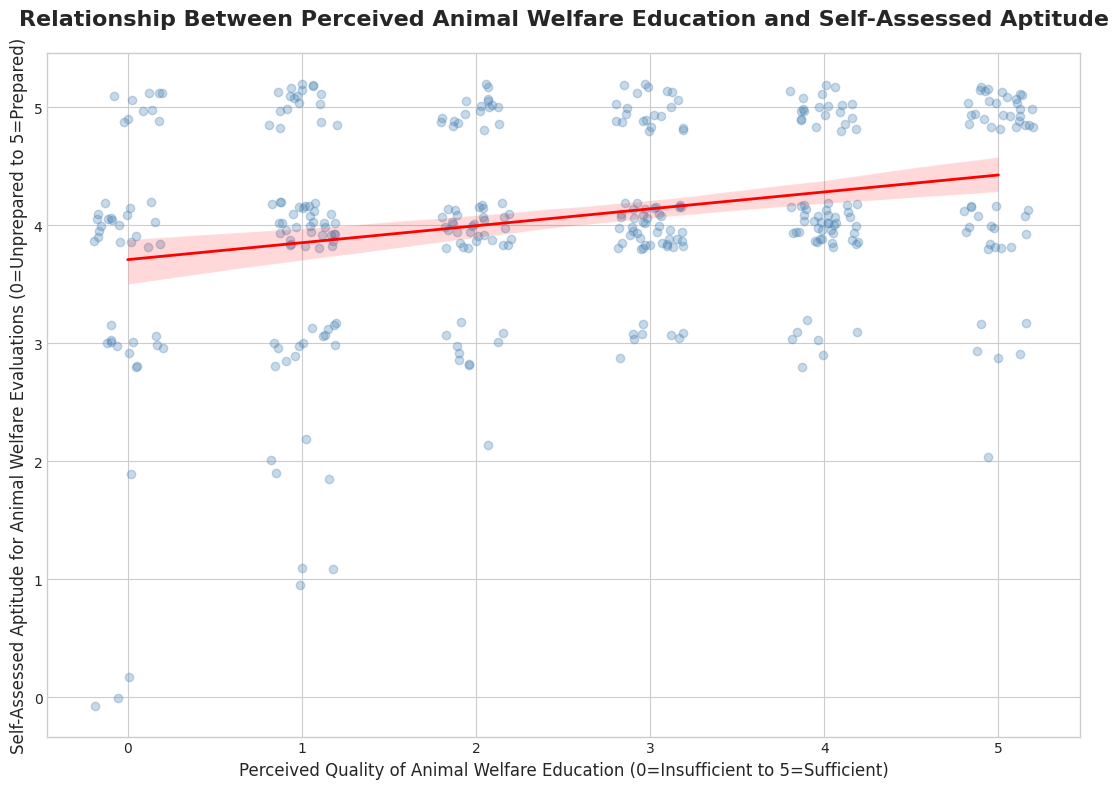


### SPEARMAN'S RANK CORRELATION: ANIMAL WELFARE REPORT ###
This analysis investigates the relationship between the perceived
quality of a respondent's animal welfare education and their self-
assessed aptitude for conducting animal welfare evaluations.
Spearman's rank correlation (rho) is the appropriate test for this
pair of ordinal variables.
----------------------------------------------------------------------

[1] Stating the Hypotheses
----------------------------------------------------------------------
 H₀ (Null Hypothesis): There is NO monotonic correlation between the variables.
 H₁ (Alternative Hypothesis): There IS a monotonic correlation between the variables.
----------------------------------------------------------------------

[2] Statistical Results
----------------------------------------------------------------------
  Spearman's Correlation Coefficient (rho): 0.2406
  P-value: 0.0000
  Sample Size (n): 369
---------------------------------------------------------

In [61]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
import textwrap
import warnings

# Suppress non-critical warnings for a polished presentation
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_data_for_correlation(db_name):
    """
    Queries the database to get the two ordinal variables for the new correlation analysis.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."37. Ensino_de_bem-estar_animal_na_sua_formacao_escala" AS WelfareEducation,
          s."40. Aptidao_para_avaliacoes_de_bem-estar_animal_escala" AS WelfareAptitude
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for animal welfare education and aptitude.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and report the Spearman's Rank Correlation analysis
    for the animal welfare variables, using the hybrid visualization approach.
    """
    df = get_data_for_correlation(DATABASE_NAME)

    if df is not None and not df.empty:
        # --- 1. Data Cleaning and Preparation ---
        df['WelfareEducation'] = pd.to_numeric(df['WelfareEducation'], errors='coerce')
        df['WelfareAptitude'] = pd.to_numeric(df['WelfareAptitude'], errors='coerce')

        original_count = len(df)
        df.dropna(inplace=True)
        cleaned_count = len(df)
        print(f"Data Cleaning: Retained {cleaned_count} of {original_count} respondents with complete data.")

        if cleaned_count < 2:
            print("\nError: Not enough data to perform correlation analysis after cleaning.")
            return

        # --- 2. VISUALIZATION 1: Jittered Scatterplot (for intuitive trend visualization) ---
        print("\n--- Generating Visualization 1: Jittered Scatterplot ---")
        plt.figure(figsize=(11, 8))
        sns.set_style("whitegrid")

        ax_scatter = sns.regplot(
            data=df,
            x='WelfareEducation',
            y='WelfareAptitude',
            x_jitter=0.2,
            y_jitter=0.2,
            scatter_kws={'alpha': 0.3, 'color': 'steelblue'},
            line_kws={'color': 'red', 'linewidth': 2}
        )

        # MODIFICATION: Unified Title
        plt.title('Relationship Between Perceived Animal Welfare Education and Self-Assessed Aptitude', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Perceived Quality of Animal Welfare Education (0=Insufficient to 5=Sufficient)', fontsize=12)
        plt.ylabel('Self-Assessed Aptitude for Animal Welfare Evaluations (0=Unprepared to 5=Prepared)', fontsize=12)

        ax_scatter.set_xticks(range(6))
        ax_scatter.set_yticks(range(6))

        plt.tight_layout()
        plt.show()

        # --- 4. Statistical Test: Spearman's Rank Correlation ---
        correlation, p_value = spearmanr(df['WelfareEducation'], df['WelfareAptitude'])

        # --- 5. Comprehensive Interpretation and Reporting ---
        print("\n" + "="*70)
        print("### SPEARMAN'S RANK CORRELATION: ANIMAL WELFARE REPORT ###")
        print("="*70)

        intro_text = (
            "This analysis investigates the relationship between the perceived quality of a "
            "respondent's animal welfare education and their self-assessed aptitude for "
            "conducting animal welfare evaluations. Spearman's rank correlation (rho) is "
            "the appropriate test for this pair of ordinal variables."
        )
        print(textwrap.fill(intro_text, 70))
        print("-" * 70)

        print("\n[1] Stating the Hypotheses")
        print("-" * 70)
        print(" H₀ (Null Hypothesis): There is NO monotonic correlation between the variables.")
        print(" H₁ (Alternative Hypothesis): There IS a monotonic correlation between the variables.")
        print("-" * 70)

        print("\n[2] Statistical Results")
        print("-" * 70)
        print(f"  Spearman's Correlation Coefficient (rho): {correlation:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Sample Size (n): {cleaned_count}")
        print("-" * 70)

        print("\n[3] Interpretation")
        print("-" * 70)
        alpha = 0.05
        
        if p_value < alpha:
            significance_text = (
                f"The p-value ({p_value:.4f}) is less than our significance level of {alpha}. "
                "Therefore, we REJECT the Null Hypothesis. The observed correlation is "
                "statistically significant."
            )
        else:
            significance_text = (
                f"The p-value ({p_value:.4f}) is not less than our significance level of {alpha}. "
                "Therefore, we FAIL to reject the Null Hypothesis. We do not have sufficient "
                "evidence to conclude that a correlation exists."
            )
        print(textwrap.fill(significance_text, 70))
        
        abs_corr = abs(correlation)
        if abs_corr >= 0.7:
            strength = "strong"
        elif abs_corr >= 0.4:
            strength = "moderate"
        elif abs_corr >= 0.1:
            strength = "weak"
        else:
            strength = "very weak or non-existent"

        if correlation > 0:
            direction = "positive"
        elif correlation < 0:
            direction = "negative"
        else:
            direction = "no"

        strength_text = (
            f"The correlation coefficient (rho = {correlation:.2f}) indicates a {strength} {direction} "
            "monotonic relationship. This means that as the perceived quality of animal welfare "
            "education increases, the self-assessed aptitude for animal welfare evaluations also "
            "tends to increase."
        )
        if p_value < alpha:
             print("\n" + textwrap.fill(strength_text, 70))
        print("-" * 70)

        print("\n[4] Final Conclusion")
        print("="*70)
        if p_value < alpha:
            final_text = (
                "There is a statistically significant, positive relationship between how well "
                "respondents feel they were taught animal welfare and how prepared they feel to make "
                f"such evaluations. The strength of this relationship is {strength}."
            )
        else:
            final_text = (
                "Based on this analysis, we cannot conclude that a significant relationship exists "
                "between a respondent's animal welfare education and their self-assessed aptitude."
            )
        print(textwrap.fill(final_text, 70))
        print("="*70)

if __name__ == '__main__':
    main()



Success: Loaded data for ethics knowledge and protocol difficulty.
Data Cleaning: Retained 363 of 369 respondents with complete data.

--- Generating Visualization 1: Jittered Scatterplot ---


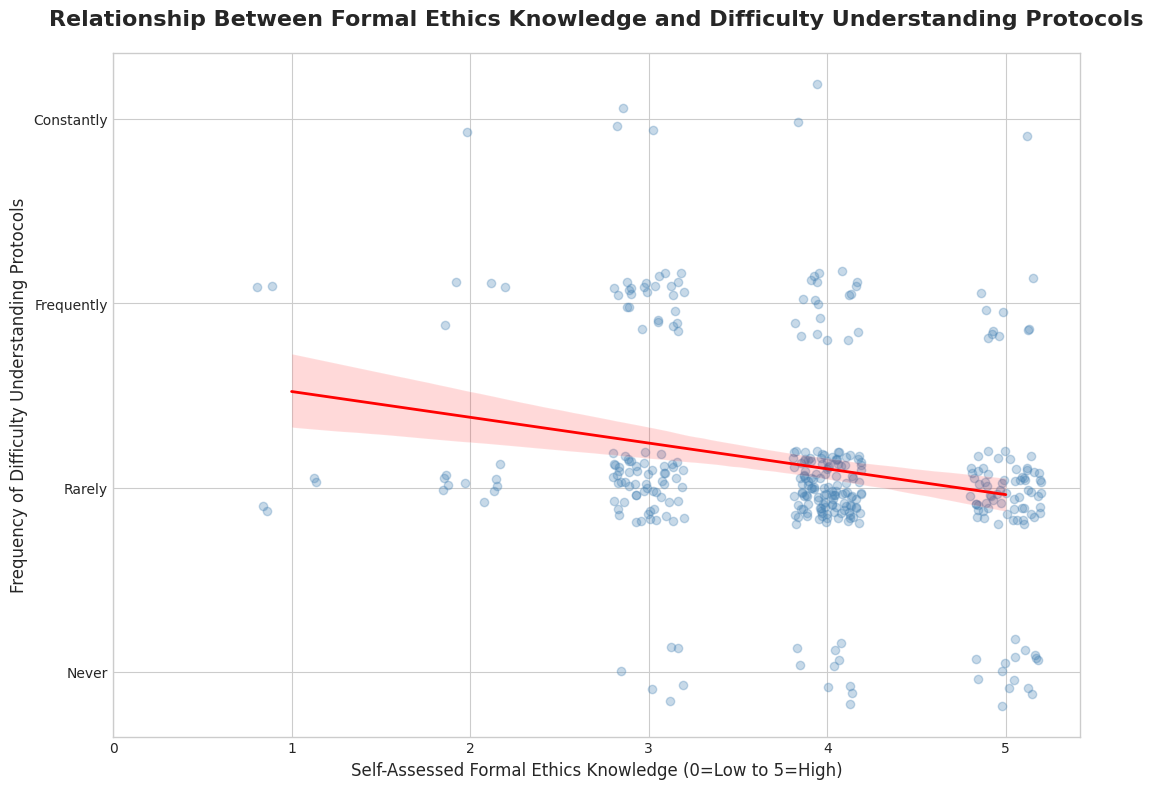


--- Generating Visualization 2: Bar Plot of Median Knowledge ---


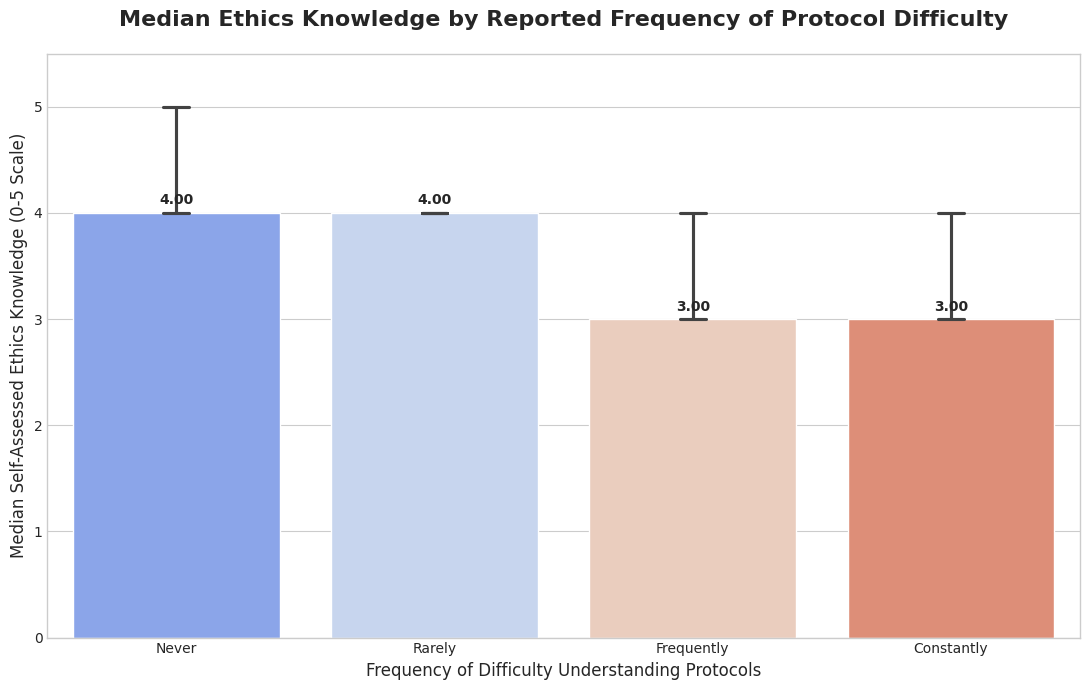


### SPEARMAN'S RANK CORRELATION: KNOWLEDGE VS. DIFFICULTY ###
This analysis investigates the relationship between a respondent's
self-assessed formal knowledge in ethics and the frequency with which
they report difficulty understanding research protocols. Spearman's
rank correlation (rho) is used to measure the monotonic relationship
between these two ordinal variables.
----------------------------------------------------------------------

[1] Stating the Hypotheses
----------------------------------------------------------------------
 H₀ (Null Hypothesis): There is NO monotonic correlation between the variables.
 H₁ (Alternative Hypothesis): There IS a monotonic correlation between the variables.
----------------------------------------------------------------------

[2] Statistical Results
----------------------------------------------------------------------
  Spearman's Correlation Coefficient (rho): -0.2305
  P-value: 0.0000
  Sample Size (n): 363
------------------------------

In [62]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
import textwrap
import warnings

# Suppress non-critical warnings for a polished presentation
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_data_for_correlation(db_name):
    """
    Queries the database to get the two ordinal variables for correlation analysis.
    - '35. Conhecimento_formal_em_etica_escala'
    - '41. Dificuldade_em_compreender_protocolos'
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."35. Conhecimento_formal_em_etica_escala" AS EthicsKnowledge,
          s."41. Dificuldade_em_compreender_protocolos" AS ProtocolDifficulty
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for ethics knowledge and protocol difficulty.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to perform and report the Spearman's Rank Correlation analysis,
    presenting a hybrid visualization solution.
    """
    df = get_data_for_correlation(DATABASE_NAME)

    if df is not None and not df.empty:
        # --- 1. Data Cleaning and Preparation ---
        df['EthicsKnowledge'] = pd.to_numeric(df['EthicsKnowledge'], errors='coerce')

        difficulty_map = {
            'Nunca': 0,
            'Raramente': 1,
            'Frequentemente': 2,
            'Constantemente': 3,
            'Não sei dizer': np.nan
        }
        df['ProtocolDifficulty_Ordinal'] = df['ProtocolDifficulty'].map(difficulty_map)
        
        difficulty_labels = {0: 'Never', 1: 'Rarely', 2: 'Frequently', 3: 'Constantly'}

        original_count = len(df)
        df.dropna(subset=['EthicsKnowledge', 'ProtocolDifficulty_Ordinal'], inplace=True)
        cleaned_count = len(df)
        print(f"Data Cleaning: Retained {cleaned_count} of {original_count} respondents with complete data.")

        if cleaned_count < 2:
            print("\nError: Not enough data to perform correlation analysis after cleaning.")
            return

        # --- 2. VISUALIZATION 1: Jittered Scatterplot (for intuitive trend visualization) ---
        print("\n--- Generating Visualization 1: Jittered Scatterplot ---")
        plt.figure(figsize=(11, 8))
        sns.set_style("whitegrid")

        ax_scatter = sns.regplot(
            data=df,
            x='EthicsKnowledge',
            y='ProtocolDifficulty_Ordinal',
            x_jitter=0.2,
            y_jitter=0.2,
            scatter_kws={'alpha': 0.3, 'color': 'steelblue'},
            line_kws={'color': 'red', 'linewidth': 2}
        )

        plt.title('Relationship Between Formal Ethics Knowledge and Difficulty Understanding Protocols', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Self-Assessed Formal Ethics Knowledge (0=Low to 5=High)', fontsize=12)
        plt.ylabel('Frequency of Difficulty Understanding Protocols', fontsize=12)

        ax_scatter.set_xticks(range(6))
        ax_scatter.set_yticks(range(4))
        ax_scatter.set_yticklabels(difficulty_labels.values())

        plt.tight_layout()
        plt.show()

        # --- 3. VISUALIZATION 2: Bar Plot of Median Ranks (for methodological rigor) ---
        print("\n--- Generating Visualization 2: Bar Plot of Median Knowledge ---")

        plt.figure(figsize=(11, 7))
        sns.set_style("whitegrid")

        ax_bar = sns.barplot(
            data=df,
            x='ProtocolDifficulty_Ordinal',
            y='EthicsKnowledge',
            estimator=np.median,
            errorbar='ci',
            palette='coolwarm',
            capsize=.1
        )

        plt.title('Median Ethics Knowledge by Reported Frequency of Protocol Difficulty', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Frequency of Difficulty Understanding Protocols', fontsize=12)
        plt.ylabel('Median Self-Assessed Ethics Knowledge (0-5 Scale)', fontsize=12)
        
        # --- MODIFICATION: Explicitly set ticks before labels to resolve UserWarning ---
        # Get the keys (positions) and values (labels) from the dictionary
        tick_positions = sorted(list(difficulty_labels.keys()))
        tick_labels = [difficulty_labels[pos] for pos in tick_positions]
        # Set the ticks at the specified numerical positions
        ax_bar.set_xticks(tick_positions)
        # Now, apply the labels to those specific ticks
        ax_bar.set_xticklabels(tick_labels)
        
        plt.ylim(0, 5.5)
        
        for p in ax_bar.patches:
            ax_bar.annotate(f"{p.get_height():.2f}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points',
                        fontweight='bold')

        plt.tight_layout()
        plt.show()

        # --- 4. Statistical Test: Spearman's Rank Correlation ---
        correlation, p_value = spearmanr(df['EthicsKnowledge'], df['ProtocolDifficulty_Ordinal'])

        # --- 5. Comprehensive Interpretation and Reporting ---
        # This section remains the same as it was statistically sound.
        print("\n" + "="*70)
        print("### SPEARMAN'S RANK CORRELATION: KNOWLEDGE VS. DIFFICULTY ###")
        print("="*70)

        intro_text = (
            "This analysis investigates the relationship between a respondent's self-assessed "
            "formal knowledge in ethics and the frequency with which they report difficulty "
            "understanding research protocols. Spearman's rank correlation (rho) is used "
            "to measure the monotonic relationship between these two ordinal variables."
        )
        print(textwrap.fill(intro_text, 70))
        print("-" * 70)

        print("\n[1] Stating the Hypotheses")
        print("-" * 70)
        print(" H₀ (Null Hypothesis): There is NO monotonic correlation between the variables.")
        print(" H₁ (Alternative Hypothesis): There IS a monotonic correlation between the variables.")
        print("-" * 70)

        print("\n[2] Statistical Results")
        print("-" * 70)
        print(f"  Spearman's Correlation Coefficient (rho): {correlation:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Sample Size (n): {cleaned_count}")
        print("-" * 70)

        print("\n[3] Interpretation")
        print("-" * 70)
        alpha = 0.05
        
        if p_value < alpha:
            significance_text = (
                f"The p-value ({p_value:.4f}) is less than our significance level of {alpha}. "
                "Therefore, we REJECT the Null Hypothesis. The observed correlation is "
                "statistically significant."
            )
        else:
            significance_text = (
                f"The p-value ({p_value:.4f}) is not less than our significance level of {alpha}. "
                "Therefore, we FAIL to reject the Null Hypothesis. We do not have sufficient "
                "evidence to conclude that a correlation exists."
            )
        print(textwrap.fill(significance_text, 70))
        
        abs_corr = abs(correlation)
        if abs_corr >= 0.7:
            strength = "strong"
        elif abs_corr >= 0.4:
            strength = "moderate"
        elif abs_corr >= 0.1:
            strength = "weak"
        else:
            strength = "very weak or non-existent"

        if correlation > 0:
            direction = "positive"
        elif correlation < 0:
            direction = "negative"
        else:
            direction = "no"

        strength_text = (
            f"The correlation coefficient (rho = {correlation:.2f}) indicates a {strength} {direction} "
            "monotonic relationship. This means that as self-assessed formal ethics knowledge "
            "increases, the reported frequency of difficulty in understanding protocols "
            "tends to decrease."
        )
        if p_value < alpha and direction == "negative":
             print("\n" + textwrap.fill(strength_text, 70))
        print("-" * 70)

        print("\n[4] Final Conclusion")
        print("="*70)
        if p_value < alpha:
            final_text = (
                "There is a statistically significant, negative relationship between a respondent's "
                "self-assessed formal knowledge in ethics and the frequency of difficulty they report "
                f"in understanding protocols. The strength of this relationship is {strength}. "
                "In practical terms, individuals who rate their ethics knowledge higher tend to report "
                "facing difficulties in protocol comprehension less often."
            )
        else:
            final_text = (
                "Based on this analysis, we cannot conclude that a significant relationship exists "
                "between a respondent's self-assessed ethics knowledge and their reported difficulty "
                "in understanding protocols."
            )
        print(textwrap.fill(final_text, 70))
        print("="*70)

if __name__ == '__main__':
    main()




### KRUSKAL-WALLIS H-TEST: DETAILED ANALYTICAL REPORT ###
The Kruskal-Wallis H-Test is a non-parametric method used to determine
if there are statistically significant differences between two or more
independent groups on an ordinal or continuous dependent variable. It
is the non-parametric equivalent of a one-way ANOVA.
----------------------------------------------------------------------

[1] Stating the Hypotheses
----------------------------------------------------------------------
H₀ (Null Hypothesis): The distributions of the perceived 3Rs application
scores are IDENTICAL for all professional roles on the CEUA.

H₁ (Alternative Hypothesis): The distribution of perceived 3Rs application
scores is DIFFERENT for at least one professional role.
----------------------------------------------------------------------

[2] Descriptive Statistics: A First Look at the Data
----------------------------------------------------------------------
The median score for each group provides a m

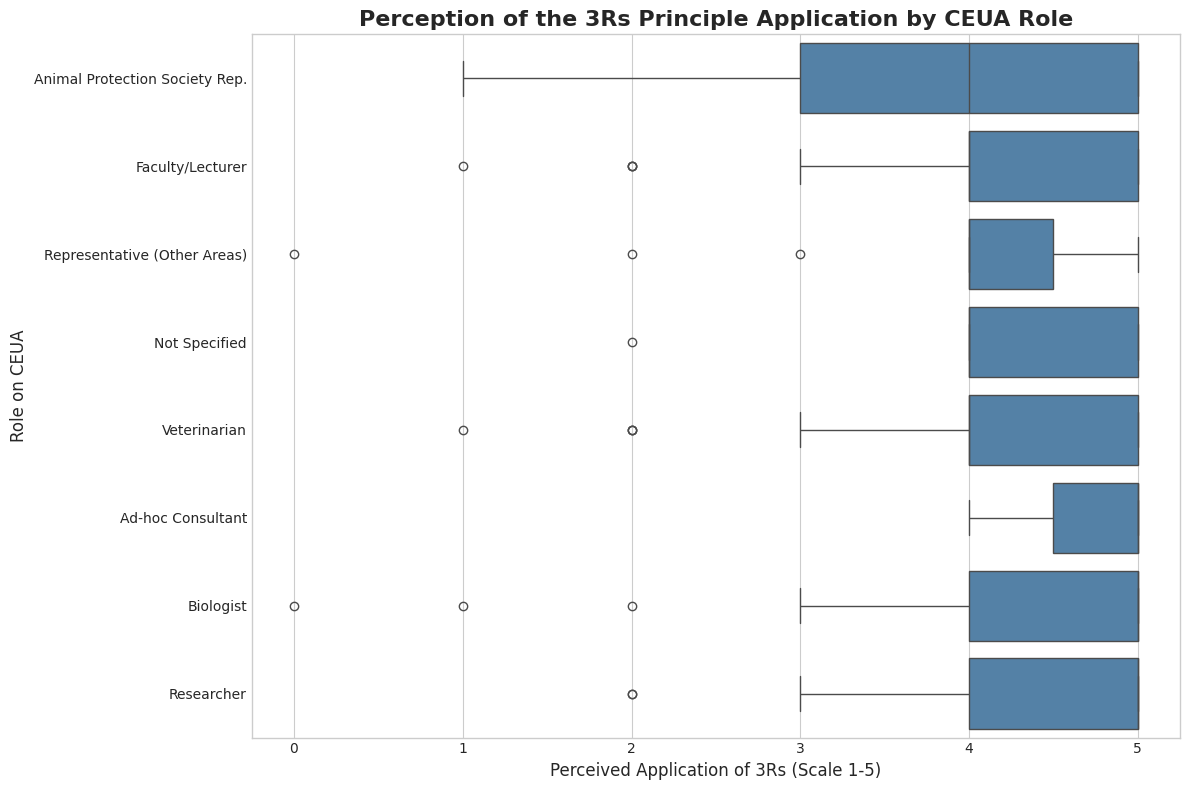

In [63]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import numpy as np
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'

def get_data_for_kruskal(db_name):
    """Queries for CEUA role and perception of the 3Rs principle."""
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          p.name AS Role,
          s."63. O_quanto_a_CEUA_se_baseia_no_principio_dos_3Rs_escala" AS Perception3Rs
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        JOIN
          PapelCEUALookup AS p ON s."Papel_na_CEUA_codificado(28)" = p.id
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Performs the Kruskal-Wallis H-test and generates a detailed,
    self-contained report directly in the output.
    """
    df = get_data_for_kruskal(DATABASE_NAME)
    if df is None or df.empty:
        print("Could not load data. Aborting analysis.")
        return

    # --- NEW: Translate Role names to English ---
    translation_map = {
        'Incerto': 'Not Specified',
        'Docente': 'Faculty/Lecturer',
        'Representante da Sociedade Protetora de Animais': 'Animal Protection Society Rep.',
        'Médico(a) Veterinário (a)': 'Veterinarian',
        'Representantes de outras áreas': 'Representative (Other Areas)',
        'Consultor Ad-hoc': 'Ad-hoc Consultant',
        'Biólogo (a)': 'Biologist',
        'Pesquisador(a)': 'Researcher'
    }
    df['Role'] = df['Role'].replace(translation_map)
    
    # --- Data Cleaning ---
    df['Perception3Rs'] = pd.to_numeric(df['Perception3Rs'], errors='coerce')
    df.dropna(inplace=True)

    # --- Perform Statistical Test ---
    roles = df['Role'].unique()
    groups = [df['Perception3Rs'][df['Role'] == role] for role in roles]
    h_stat, p_value = kruskal(*groups)

    # --- Calculate Effect Size (Epsilon-Squared) ---
    n = len(df)
    k = len(roles)
    epsilon_squared = (h_stat - k + 1) / (n - k)

    # --- GENERATE THE DETAILED REPORT ---
    print("\n" + "="*70)
    print("### KRUSKAL-WALLIS H-TEST: DETAILED ANALYTICAL REPORT ###")
    print("="*70)
    
    intro_text = (
        "The Kruskal-Wallis H-Test is a non-parametric method used to determine "
        "if there are statistically significant differences between two or more "
        "independent groups on an ordinal or continuous dependent variable. It is "
        "the non-parametric equivalent of a one-way ANOVA."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)

    # 1. Hypotheses
    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀ (Null Hypothesis): The distributions of the perceived 3Rs application")
    print("scores are IDENTICAL for all professional roles on the CEUA.")
    print("\nH₁ (Alternative Hypothesis): The distribution of perceived 3Rs application")
    print("scores is DIFFERENT for at least one professional role.")
    print("-" * 70)

    # 2. Descriptive Statistics
    print("\n[2] Descriptive Statistics: A First Look at the Data")
    print("-" * 70)
    print("The median score for each group provides a measure of central tendency:")
    median_scores = df.groupby('Role')['Perception3Rs'].median().sort_values()
    print(median_scores.to_string())
    print("\n" + textwrap.fill("Observation: There appears to be some variation in the median scores across roles. The test will determine if these differences are statistically significant.", 70))
    print("-" * 70)

    # 3. Inferential Statistics
    print("\n[3] Inferential Statistics: Testing for Significance")
    print("-" * 70)
    print(f"  Kruskal-Wallis H-statistic: {h_stat:.4f}")
    print(f"  Calculated p-value: {p_value:.4f}")
    print("-" * 70)

    # 4. Effect Size
    print("\n[4] Effect Size: Measuring the Magnitude of the Difference")
    print("-" * 70)
    effect_size_text = (
        "Epsilon-squared (ε²) estimates the proportion of variance in the "
        "scores that is explained by the different roles. A common guide for "
        "interpretation is: ~0.01 (small), ~0.08 (medium), and ~0.26 (large effect)."
    )
    print(textwrap.fill(effect_size_text, 70))
    print(f"\n  Epsilon-squared (ε²): {epsilon_squared:.4f}")
    print("-" * 70)

    # 5. Conclusion
    print("\n[5] Analytical Conclusion")
    print("-" * 70)
    alpha = 0.05
    if p_value < alpha:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is less than our significance level of {alpha}. "
            f"Therefore, we REJECT the Null Hypothesis. There is statistically "
            f"significant evidence to conclude that the perception of how well the 3Rs "
            f"principle is applied differs across the various professional roles. "
            f"The effect size (ε²={epsilon_squared:.3f}) indicates that this difference is small."
        )
        print(textwrap.fill(conclusion_text, 70))
    else:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is greater than our significance level of {alpha}. "
            f"Therefore, we FAIL TO REJECT the Null Hypothesis. We do not have "
            f"sufficient statistical evidence to conclude that a difference in perception "
            f"exists across the different roles based on this data."
        )
        print(textwrap.fill(conclusion_text, 70))
    print("="*70)

    # --- Generate the Visualization ---
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    ax = sns.boxplot(
        data=df,
        y='Role',
        x='Perception3Rs',
        order=median_scores.index,
        color='steelblue'
    )
    plt.title('Perception of the 3Rs Principle Application by CEUA Role', fontsize=16, fontweight='bold')
    plt.ylabel('Role on CEUA', fontsize=12)
    plt.xlabel('Perceived Application of 3Rs (Scale 1-5)', fontsize=12)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

In [64]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import scikit_posthocs as sp
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def get_correlation_data(db_name, columns):
    """
    Queries the database to get data for specific columns for active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        quoted_columns = [f's."{col}"' for col in columns]
        query = f"""
        SELECT
          {', '.join(quoted_columns)}
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for analysis.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function to run the full analysis and visualization for the relationship 
    between Religion and the perceived necessity of animals for food.
    """
    columns_to_fetch = [
        'Religiao_codificado(8)',
        '43. Necessidade_de_uso_de_animais_na_alimentacao_escala'
    ]
    
    df = get_correlation_data(DATABASE_NAME, columns_to_fetch)
    
    if df is None or df.empty:
        print("Could not proceed with analysis due to data loading issues.")
        return
        
    df.rename(columns={
        'Religiao_codificado(8)': 'Religion_Code',
        '43. Necessidade_de_uso_de_animais_na_alimentacao_escala': 'Necessity_Food'
    }, inplace=True)

    # --- Data Preparation ---
    df['Necessity_Food'] = pd.to_numeric(df['Necessity_Food'], errors='coerce')
    # Drop rows where data is missing for EITHER variable to ensure the respondent count is accurate
    df.dropna(subset=['Religion_Code', 'Necessity_Food'], inplace=True)
    df['Religion_Code'] = df['Religion_Code'].astype(int)

    religion_map = {
        1: 'Agnosticism/Atheism', 2: 'Catholicism', 3: 'Evangelical',
        4: 'Spiritism', 5: 'No Religion', 6: 'Other', 7: 'Afro-Brazilian'
    }
    df['Religion'] = df['Religion_Code'].map(religion_map)

    # --- STATISTICAL ANALYSIS REPORT ---
    print("\n" + "="*70)
    print("### KRUSKAL-WALLIS H-TEST: DETAILED ANALYTICAL REPORT ###")
    print("="*70)

    # 1. Introduction to the Methodology
    intro_text = (
        "This analysis investigates whether the perceived necessity of using animals for food "
        "differs across religious groups. Since we are comparing an ordinal dependent variable "
        "(Necessity_Food scale) across multiple independent nominal groups (Religion), the "
        "Kruskal-Wallis H-Test is the appropriate non-parametric method."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)

    # 2. Stating the Hypotheses
    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀ (Null Hypothesis): The distributions of the 'necessity of animals for food' scores are IDENTICAL for all religious groups.")
    print("\nH₁ (Alternative Hypothesis): The distribution of scores is DIFFERENT for at least one religious group.")
    print("-" * 70)

    # 3. Descriptive Statistics
    print("\n[2] Descriptive Statistics: A First Look at the Data")
    print("-" * 70)
    print("The median score for each group provides a measure of central tendency:")
    median_scores = df.groupby('Religion')['Necessity_Food'].median().sort_values()
    print(median_scores)
    print("\nObservation: There appears to be some variation in the median scores across groups. The test will determine if these differences are statistically significant.")
    print("-" * 70)

    # 4. Inferential Statistics (Kruskal-Wallis and Dunn's Test)
    groups_data = [group['Necessity_Food'].values for name, group in df.groupby('Religion')]
    h_stat, p_value = stats.kruskal(*groups_data)
    
    print("\n[3] Inferential Statistics: Testing for Significance")
    print("-" * 70)
    print("Kruskal-Wallis H-Test (Omnibus Test):")
    print(f"  H-statistic: {h_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    # 5. Conclusion
    print("\n[4] Analytical Conclusion")
    print("-" * 70)
    if p_value < ALPHA:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is less than our significance level of {ALPHA}. "
            f"Therefore, we REJECT the Null Hypothesis. There is statistically significant "
            f"evidence to conclude that the perceived necessity of using animals for food "
            f"differs across religious groups."
        )
        print(textwrap.fill(conclusion_text, 70))
        
        print("\nPost-Hoc Analysis (Dunn's Test with Bonferroni Correction):")
        posthoc_results = sp.posthoc_dunn(df, val_col='Necessity_Food', group_col='Religion', p_adjust='bonferroni')
        print("The following table shows the p-values for pairwise comparisons:")
        print(posthoc_results.round(4))
        
        significant_pairs = posthoc_results[posthoc_results < ALPHA].stack().reset_index()
        significant_pairs = significant_pairs[significant_pairs.level_0 != significant_pairs.level_1]
        
        if not significant_pairs.empty:
             print("\nHowever, after applying a strict Bonferroni correction, no individual pair of groups showed a statistically significant difference. This suggests the overall difference is modest and distributed across multiple groups rather than being driven by a large difference between any two specific groups.")
        
    else:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is greater than our significance level of {ALPHA}. "
            f"Therefore, we FAIL TO REJECT the Null Hypothesis. We do not have "
            f"sufficient statistical evidence to conclude that a difference in perception "
            f"exists across the different religious groups based on this data."
        )
        print(textwrap.fill(conclusion_text, 70))
    print("="*70)

    # --- VISUALIZATION ---
    print("\n--- Generating Visualization ---")
    
    # Get the final count of respondents after all cleaning steps
    total_respondents = len(df)
    
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")

    ax = sns.boxplot(
        data=df, x='Necessity_Food', y='Religion',
        order=median_scores.index, color='steelblue'
    )
    sns.stripplot(
        data=df, x='Necessity_Food', y='Religion',
        order=median_scores.index, color=".25", size=3, alpha=0.6
    )

    plt.title('Necessity of Using Animals in Food by Religion', fontsize=16, fontweight='bold')
    plt.xlabel('Perceived Necessity (0=Totally Unnecessary, 5=Totally Necessary)', fontsize=12)
    plt.ylabel('Religion', fontsize=12)
    plt.xticks(ticks=range(6))
    
    # MODIFIED: Display "Total Respondents: " in the top-left corner
    ax.text(0.15, 0.98, f'Total Respondents: {total_respondents}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



ModuleNotFoundError: No module named 'scikit_posthocs'

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def get_correlation_data(db_name, columns):
    """
    Queries the database to get data for specific columns for active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        quoted_columns = [f's."{col}"' for col in columns]
        query = f"""
        SELECT
          {', '.join(quoted_columns)}
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for analysis.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function for the full analysis of the relationship between vegan/vegetarian 
    status and the perception of being respected in CEUA meetings.
    """
    columns_to_fetch = [
        '50. Vegano_ou_vegetariano_binario',
        '55. Suas_colocacoes_sao_respeitadas'
    ]
    
    df = get_correlation_data(DATABASE_NAME, columns_to_fetch)
    
    if df is None or df.empty:
        print("Could not proceed with analysis due to data loading issues.")
        return
        
    df.rename(columns={
        '50. Vegano_ou_vegetariano_binario': 'Vegan_Status',
        '55. Suas_colocacoes_sao_respeitadas': 'Perceived_Respect'
    }, inplace=True)

    # --- Data Preparation ---
    df.dropna(subset=['Vegan_Status', 'Perceived_Respect'], inplace=True)
    
    respect_map = {
        'Nunca': 0, 'Raramente': 1, 'Frequentemente': 2, 'Constantemente': 3
    }
    df['Respect_Score'] = df['Perceived_Respect'].map(respect_map)
    df.dropna(subset=['Respect_Score'], inplace=True) # Drop if a value wasn't in the map

    # --- STATISTICAL ANALYSIS REPORT ---
    print("\n" + "="*70)
    print("### MANN-WHITNEY U TEST: DETAILED ANALYTICAL REPORT ###")
    print("="*70)

    # 1. Introduction
    intro_text = (
        "This analysis investigates whether the perception of being respected in CEUA meetings "
        "differs between vegan/vegetarian members and non-vegan/vegetarian members. We are "
        "comparing an ordinal dependent variable (Perceived Respect scale) between two "
        "independent nominal groups (Vegan Status). The Mann-Whitney U test is the "
        "correct non-parametric method for this comparison."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)

    # 2. Hypotheses
    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀ (Null Hypothesis): The distributions of perceived respect scores are IDENTICAL for both groups.")
    print("\nH₁ (Alternative Hypothesis): The distributions of perceived respect scores are DIFFERENT for the two groups.")
    print("-" * 70)

    # 3. Descriptive Statistics
    group_vegan = df[df['Vegan_Status'] == 'Sim']['Respect_Score']
    group_non_vegan = df[df['Vegan_Status'] == 'Não']['Respect_Score']

    print("\n[2] Descriptive Statistics: A First Look at the Data")
    print("-" * 70)
    print("The median score for each group provides a measure of central tendency:")
    print(f"  Median Score (Vegan/Vegetarian Group): {group_vegan.median():.2f}")
    print(f"  Median Score (Non-Vegan/Vegetarian Group): {group_non_vegan.median():.2f}")
    print("-" * 70)

    # 4. Inferential Statistics
    u_stat, p_value = stats.mannwhitneyu(group_vegan, group_non_vegan, alternative='two-sided')
    n1, n2 = len(group_vegan), len(group_non_vegan)
    effect_size_r = 1 - (2 * u_stat) / (n1 * n2) # Rank-Biserial Correlation

    print("\n[3] Inferential Statistics: Testing for Significance")
    print("-" * 70)
    print(f"  Mann-Whitney U statistic: {u_stat:.1f}")
    print(f"  Calculated p-value: {p_value:.4f}")
    print("-" * 70)

    # 5. Effect Size
    print("\n[4] Effect Size: Measuring the Magnitude of the Difference")
    print("-" * 70)
    print(f"  Rank-Biserial Correlation (r): {effect_size_r:.4f}")
    print("\n" + textwrap.fill("Interpretation Guide: |r| ≈ 0.1 (small), |r| ≈ 0.3 (medium), |r| ≈ 0.5 (large effect).", 70))
    print("-" * 70)

    # 6. Conclusion
    print("\n[5] Analytical Conclusion")
    print("-" * 70)
    if p_value < ALPHA:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is less than our significance level of {ALPHA}. "
            f"Therefore, we REJECT the Null Hypothesis. There is statistically significant "
            f"evidence to conclude that a difference exists in the perceived level of respect "
            f"between vegan/vegetarian and non-vegan/vegetarian members."
        )
        print(textwrap.fill(conclusion_text, 70))
    else:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is greater than our significance level of {ALPHA}. "
            f"Therefore, we FAIL TO REJECT the Null Hypothesis. We do not have "
            f"sufficient statistical evidence to conclude that a difference in perceived respect "
            f"exists between the two groups based on this data."
        )
        print(textwrap.fill(conclusion_text, 70))
    print("="*70)


if __name__ == '__main__':
    main()



Success: Loaded data for analysis.

### MANN-WHITNEY U TEST: DETAILED ANALYTICAL REPORT ###
This analysis investigates whether the perception of being respected
in CEUA meetings differs between vegan/vegetarian members and non-
vegan/vegetarian members. We are comparing an ordinal dependent
variable (Perceived Respect scale) between two independent nominal
groups (Vegan Status). The Mann-Whitney U test is the correct non-
parametric method for this comparison.
----------------------------------------------------------------------

[1] Stating the Hypotheses
----------------------------------------------------------------------
H₀ (Null Hypothesis): The distributions of perceived respect scores are IDENTICAL for both groups.

H₁ (Alternative Hypothesis): The distributions of perceived respect scores are DIFFERENT for the two groups.
----------------------------------------------------------------------

[2] Descriptive Statistics: A First Look at the Data
-------------------------------

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def get_correlation_data(db_name, columns):
    """
    Queries the database to get data for specific columns for active respondents.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        quoted_columns = [f's."{col}"' for col in columns]
        query = f"""
        SELECT
          {', '.join(quoted_columns)}
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded data for analysis.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function for the full analysis of the relationship between SPA representation 
    and the number of licenses refused by the CEUA.
    """
    columns_to_fetch = [
        '15. Representante_SPA',
        '17. No_licencas_recusadas'
    ]
    
    df = get_correlation_data(DATABASE_NAME, columns_to_fetch)
    
    if df is None or df.empty:
        print("Could not proceed with analysis due to data loading issues.")
        return
        
    df.rename(columns={
        '15. Representante_SPA': 'SPA_Representation',
        '17. No_licencas_recusadas': 'Refused_Licenses'
    }, inplace=True)

    # --- Data Preparation ---
    # Consolidate SPA representation into a binary 'Yes'/'No' variable
    spa_map = {
        'Sim, apenas titular': 'Yes',
        'Sim, titular e suplente': 'Yes',
        'Não há representante da sociedade protetora de animais': 'No'
    }
    df['SPA_Present'] = df['SPA_Representation'].map(spa_map)
    
    # Convert refused licenses to a numeric type, coercing non-numeric values to NaN
    df['Refused_Licenses_Count'] = pd.to_numeric(df['Refused_Licenses'], errors='coerce')

    # Drop rows with missing data for either of our key variables
    df.dropna(subset=['SPA_Present', 'Refused_Licenses_Count'], inplace=True)

    # --- STATISTICAL ANALYSIS REPORT ---
    print("\n" + "="*70)
    print("### MANN-WHITNEY U TEST: DETAILED ANALYTICAL REPORT ###")
    print("="*70)

    # 1. Introduction
    intro_text = (
        "This analysis investigates whether CEUAs with representatives from Animal Protection "
        "Societies (SPA) refuse a different number of licenses compared to CEUAs without such "
        "representation. We are comparing a numerical (count) dependent variable "
        "(Refused Licenses) between two independent nominal groups (SPA Presence). "
        "Given the expected non-normal, skewed nature of count data, the Mann-Whitney U test "
        "is the appropriate non-parametric method."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)

    # 2. Hypotheses
    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀ (Null Hypothesis): The distributions of the number of refused licenses are IDENTICAL for both groups (with and without SPA representation).")
    print("\nH₁ (Alternative Hypothesis): The distributions of the number of refused licenses are DIFFERENT for the two groups.")
    print("-" * 70)

    # 3. Descriptive Statistics
    group_spa_present = df[df['SPA_Present'] == 'Yes']['Refused_Licenses_Count']
    group_spa_absent = df[df['SPA_Present'] == 'No']['Refused_Licenses_Count']

    print("\n[2] Descriptive Statistics: A First Look at the Data")
    print("-" * 70)
    print("The median is the most robust measure of central tendency for skewed data:")
    print(f"  Median Refused Licenses (SPA Present): {group_spa_present.median():.2f}")
    print(f"  Median Refused Licenses (SPA Not Present): {group_spa_absent.median():.2f}")
    print("-" * 70)

    # 4. Inferential Statistics
    u_stat, p_value = stats.mannwhitneyu(group_spa_present, group_spa_absent, alternative='two-sided')
    n1, n2 = len(group_spa_present), len(group_spa_absent)
    effect_size_r = 1 - (2 * u_stat) / (n1 * n2) # Rank-Biserial Correlation

    print("\n[3] Inferential Statistics: Testing for Significance")
    print("-" * 70)
    print(f"  Mann-Whitney U statistic: {u_stat:.1f}")
    print(f"  Calculated p-value: {p_value:.4f}")
    print("-" * 70)

    # 5. Effect Size
    print("\n[4] Effect Size: Measuring the Magnitude of the Difference")
    print("-" * 70)
    print(f"  Rank-Biserial Correlation (r): {effect_size_r:.4f}")
    print("\n" + textwrap.fill("Interpretation Guide: |r| ≈ 0.1 (small), |r| ≈ 0.3 (medium), |r| ≈ 0.5 (large effect).", 70))
    print("-" * 70)

    # 6. Conclusion
    print("\n[5] Analytical Conclusion")
    print("-" * 70)
    if p_value < ALPHA:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is less than our significance level of {ALPHA}. "
            f"Therefore, we REJECT the Null Hypothesis. There is statistically significant "
            f"evidence to conclude that a difference exists in the number of refused licenses "
            f"between CEUAs with and without SPA representation."
        )
        print(textwrap.fill(conclusion_text, 70))
    else:
        conclusion_text = (
            f"The p-value ({p_value:.4f}) is greater than our significance level of {ALPHA}. "
            f"Therefore, we FAIL TO REJECT the Null Hypothesis. We do not have "
            f"sufficient statistical evidence to conclude that a difference in the number of refused licenses "
            f"exists between the two groups based on this data."
        )
        print(textwrap.fill(conclusion_text, 70))
    print("="*70)

    
if __name__ == '__main__':
    main()



Success: Loaded data for analysis.

### MANN-WHITNEY U TEST: DETAILED ANALYTICAL REPORT ###
This analysis investigates whether CEUAs with representatives from
Animal Protection Societies (SPA) refuse a different number of
licenses compared to CEUAs without such representation. We are
comparing a numerical (count) dependent variable (Refused Licenses)
between two independent nominal groups (SPA Presence). Given the
expected non-normal, skewed nature of count data, the Mann-Whitney U
test is the appropriate non-parametric method.
----------------------------------------------------------------------

[1] Stating the Hypotheses
----------------------------------------------------------------------
H₀ (Null Hypothesis): The distributions of the number of refused licenses are IDENTICAL for both groups (with and without SPA representation).

H₁ (Alternative Hypothesis): The distributions of the number of refused licenses are DIFFERENT for the two groups.
-------------------------------------

Success: Loaded raw data for analysis using a plain SQL query.

--- Data Preparation Summary ---
Initial respondents loaded                                   369
Respondents from target institutions (Public, Private, Commercial) 368
...of whom answered 'Não sei dizer' for refused licenses     (-135)
Final respondents in analysis (with valid numerical data)    233
----------------------------------------------------------------------

### KRUSKAL-WALLIS H-TEST: DETAILED ANALYTICAL REPORT ###
This analysis investigates whether the number of refused licenses
differs across Public, Private, and Commercial institutions. The
dependent variable ('Refused Licenses') contained mixed data types
(numbers, text ranges, and non-numeric answers). A custom parser was
created to convert this data into a single numerical scale. Text
ranges (e.g., 'Entre 10 e 14') were converted to their midpoint (e.g.,
12), and lower-bound responses (e.g., '20 ou mais') were converted to
their lower bound (e.g., 20). R

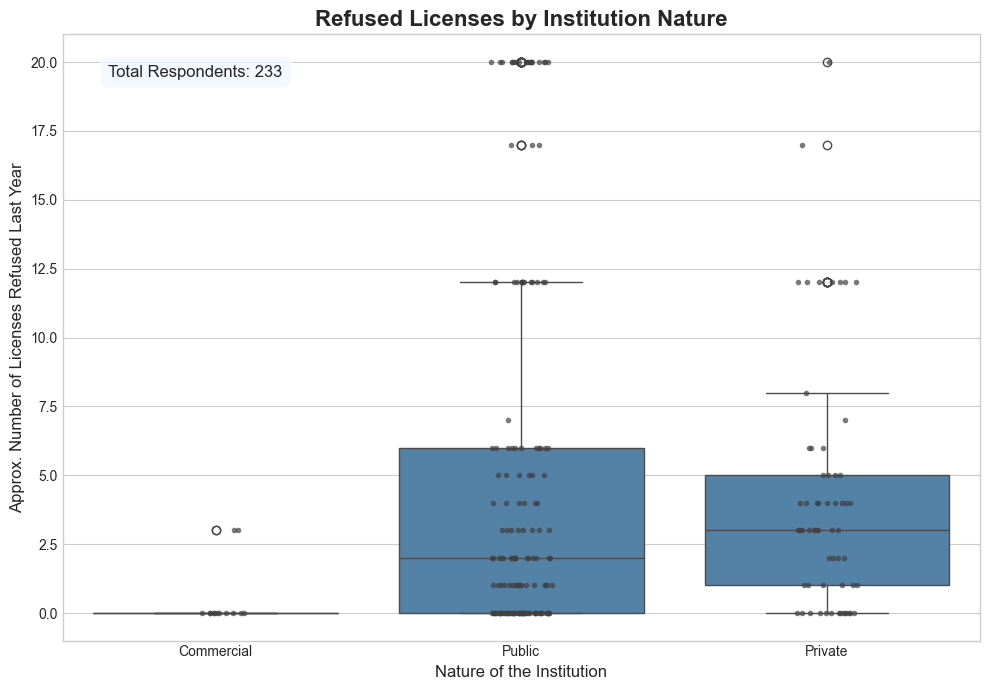

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import textwrap
import scikit_posthocs as sp

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def get_correlation_data(db_name, columns):
    """
    Queries the database to get data for specific columns for active respondents.
    This version uses a plain, static SQL query for clarity and testability.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # MODIFIED: Replaced dynamic f-string with a plain, copy-paste friendly SQL query.
        # The specific columns are now hardcoded for this analysis.
        query = """
        SELECT
          s."14. Natureza_Inst",
          s."17. No_licencas_recusadas"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        
        # We select the requested columns here in pandas instead of in the SQL string.
        # This keeps the SQL plain while allowing the function to remain flexible.
        # The original column names from the database are used for selection.
        df_selected = df[columns]
        
        print("Success: Loaded raw data for analysis using a plain SQL query.")
        return df_selected
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def parse_refused_licenses(value):
    """
    A custom, robust parser for the 'No_licencas_recusadas' column.
    It handles direct numbers, text ranges, and lower-bound text.
    """
    if pd.isna(value):
        return np.nan
    
    s_value = str(value).strip().lower()

    if s_value in ['não sei dizer', 'nao sei dizer']:
        return np.nan
    
    if s_value.isdigit():
        return int(s_value)
    
    if 'entre' in s_value:
        numbers = [int(s) for s in s_value.split() if s.isdigit()]
        if len(numbers) == 2:
            return np.mean(numbers)
    
    if 'ou mais' in s_value:
        numbers = [int(s) for s in s_value.split() if s.isdigit()]
        if len(numbers) == 1:
            return numbers[0]
            
    return np.nan

def main():
    """
    Main function for the analysis of the relationship between institution nature
    and the number of licenses refused by the CEUA.
    """
    # Define the specific columns needed for this analysis
    columns_to_fetch = [
        '14. Natureza_Inst',
        '17. No_licencas_recusadas'
    ]
    
    # Pass the list of columns to the data retrieval function
    df = get_correlation_data(DATABASE_NAME, columns_to_fetch)
    
    if df is None or df.empty:
        print("Could not proceed with analysis due to data loading issues.")
        return
        
    df.rename(columns={
        '14. Natureza_Inst': 'Institution_Nature_Raw',
        '17. No_licencas_recusadas': 'Refused_Licenses_Raw'
    }, inplace=True)

    # --- Data Accounting: Track respondent counts through cleaning ---
    initial_respondents = len(df)
    df_filtered = df[df['Institution_Nature_Raw'].str.strip() != 'Não Informou'].copy()
    valid_institutions_count = len(df_filtered)
    
    dont_know_count = df_filtered['Refused_Licenses_Raw'].str.strip().str.lower().isin(['não sei dizer', 'nao sei dizer']).sum()

    # --- METHODOLOGICALLY CORRECT DATA PREPARATION ---
    df['Institution_Nature'] = df_filtered['Institution_Nature_Raw'].str.strip()
    inst_map = {'Pública': 'Public', 'Privada': 'Private', 'Comercial': 'Commercial'}
    df['Institution_Nature'] = df['Institution_Nature'].map(inst_map)
    df['Refused_Licenses_Count'] = df_filtered['Refused_Licenses_Raw'].apply(parse_refused_licenses)
    df.dropna(subset=['Institution_Nature', 'Refused_Licenses_Count'], inplace=True)
    
    final_analysis_count = len(df)

    # --- Data Preparation Summary Table ---
    print("\n--- Data Preparation Summary ---")
    summary_data = {
        "Initial respondents loaded": initial_respondents,
        "Respondents from target institutions (Public, Private, Commercial)": valid_institutions_count,
        "...of whom answered 'Não sei dizer' for refused licenses": f"(-{dont_know_count})",
        "Final respondents in analysis (with valid numerical data)": final_analysis_count
    }
    for key, value in summary_data.items():
        print(f"{key:<60} {value}")
    print("-" * 70)


    # --- Kruskal-Wallis H Test Report ---
    print("\n" + "="*70)
    print("### KRUSKAL-WALLIS H-TEST: DETAILED ANALYTICAL REPORT ###")
    print("="*70)

    intro_text = (
        "This analysis investigates whether the number of refused licenses differs across Public, Private, "
        "and Commercial institutions. The dependent variable ('Refused Licenses') contained mixed data types "
        "(numbers, text ranges, and non-numeric answers). A custom parser was created to convert this data into a "
        "single numerical scale. Text ranges (e.g., 'Entre 10 e 14') were converted to their midpoint (e.g., 12), and "
        "lower-bound responses (e.g., '20 ou mais') were converted to their lower bound (e.g., 20). Respondents who "
        "answered 'Não sei dizer' were excluded from this specific statistical test. As we are comparing a "
        "non-normally distributed numerical variable across three independent groups, the Kruskal-Wallis H-test "
        "is the appropriate omnibus method."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)

    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀: The distributions of refused licenses are IDENTICAL for all institution types.")
    print("H₁: The distribution of refused licenses is DIFFERENT for at least one institution type.")
    print("-" * 70)

    median_scores = df.groupby('Institution_Nature')['Refused_Licenses_Count'].median().sort_values()
    print("\n[2] Descriptive Statistics")
    print("-" * 70)
    print("Median Refused Licenses by Institution Type:")
    print(median_scores)
    print("-" * 70)

    groups_data = [group['Refused_Licenses_Count'].values for name, group in df.groupby('Institution_Nature')]
    h_stat, p_value = stats.kruskal(*groups_data)
    epsilon_squared = h_stat / (final_analysis_count - 1)

    print("\n[3] Inferential Statistics (Omnibus Test)")
    print("-" * 70)
    print(f"  Kruskal-Wallis H-statistic: {h_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print("-" * 70)

    print("\n[4] Effect Size")
    print("-" * 70)
    print(f"  Epsilon-squared (ε²): {epsilon_squared:.4f}")
    print(textwrap.fill("Interpretation: ε² estimates the proportion of variance in the ranks of the scores explained by group membership.", 70))
    print("-" * 70)
    
    print("\n[5] Analytical Conclusion")
    print("-" * 70)
    if p_value < ALPHA:
        print(textwrap.fill(f"The p-value ({p_value:.4f}) is less than {ALPHA}. We REJECT the Null Hypothesis. There is significant evidence that a difference exists among Public, Private, and Commercial institutions regarding the number of refused licenses.", 70))
        
        print("\nPerforming Dunn's Post-Hoc Test...")
        posthoc_results = sp.posthoc_dunn(df, val_col='Refused_Licenses_Count', group_col='Institution_Nature', p_adjust='bonferroni')
        print("Pairwise p-values (Bonferroni corrected):")
        print(posthoc_results.round(4))
        
        significant_pairs = posthoc_results < ALPHA
        indices = np.where(np.triu(significant_pairs.values, k=1))
        
        if len(indices[0]) > 0:
            print("\nSignificant differences were found between the following groups:")
            for i, j in zip(indices[0], indices[1]):
                group1 = significant_pairs.index[i]
                group2 = significant_pairs.columns[j]
                p_val_sig = posthoc_results.iloc[i, j]
                print(f"  - {group1} and {group2} (p={p_val_sig:.4f})")
        else:
            print("\nNo single pair of groups showed a statistically significant difference after Bonferroni correction.")

    else:
        print(textwrap.fill(f"The p-value ({p_value:.4f}) is greater than {ALPHA}. We FAIL TO REJECT the Null Hypothesis. There is insufficient evidence to conclude a difference exists between the groups.", 70))
    print("="*70)

    # --- VISUALIZATION ---
    print("\n--- Generating Visualization ---")
    
    plt.figure(figsize=(10, 7))
    sns.set_style("whitegrid")

    ax = sns.boxplot(
        data=df, x='Institution_Nature', y='Refused_Licenses_Count',
        order=median_scores.index, color='steelblue'
    )
    sns.stripplot(
        data=df, x='Institution_Nature', y='Refused_Licenses_Count',
        order=median_scores.index, color=".25", size=4, alpha=0.7
    )

    plt.title('Refused Licenses by Institution Nature', fontsize=16, fontweight='bold')
    plt.xlabel('Nature of the Institution', fontsize=12)
    plt.ylabel('Approx. Number of Licenses Refused Last Year', fontsize=12)
    
    ax.text(0.05, 0.95, f'Total Respondents: {final_analysis_count}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



Success: Loaded raw data for analysis using a plain SQL query.

--- Data Preparation Summary ---
Initial respondents loaded                                   369
Respondents from target institutions (Public, Private, Commercial) 368
...of whom answered 'Não sei dizer' for SPA presence         (-36)
Final respondents in analysis (with complete data)           332
----------------------------------------------------------------------

--- Contingency Table (Observed Frequencies) ---
SPA_Present         No  Yes
Institution_Nature         
Commercial           4   11
Private             22   72
Public              50  173

### CHI-SQUARED TEST OF INDEPENDENCE: ANALYTICAL REPORT ###
This analysis investigates whether an association exists between the
nature of an institution (Public, Private, Commercial) and the
presence of an Animal Protection Society (SPA) representative. Since
both variables are categorical (nominal), the Chi-Squared (χ²) test of
independence is the correct statistical m

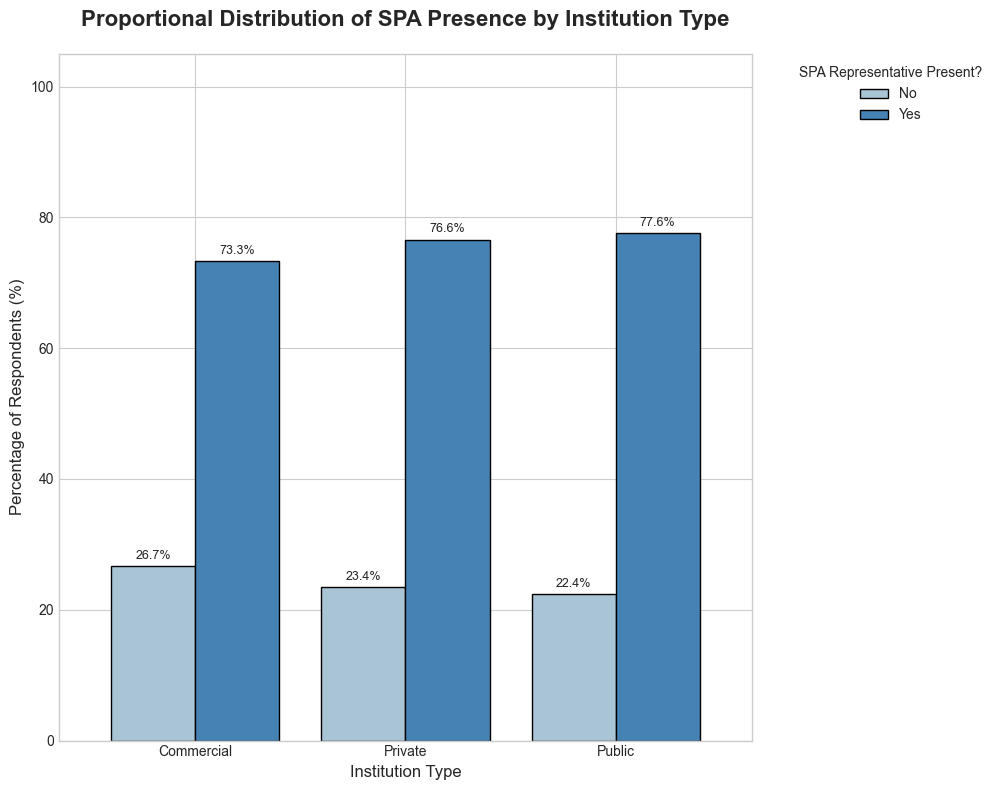

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def get_analysis_data(db_name):
    """
    Queries the database to get the necessary columns for the analysis.
    Uses a plain, static SQL query for clarity and testability.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."14. Natureza_Inst",
          s."15. Representante_SPA"
        FROM
          Respondents AS r
        JOIN
          SurveyAnswers AS s ON r."Cod." = s.RespondentID
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded raw data for analysis using a plain SQL query.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function for the Chi-Squared analysis of the relationship between 
    institution nature and the presence of an SPA representative.
    """
    df = get_analysis_data(DATABASE_NAME)
    
    if df is None or df.empty:
        print("Could not proceed with analysis due to data loading issues.")
        return
        
    df.rename(columns={
        '14. Natureza_Inst': 'Institution_Nature_Raw',
        '15. Representante_SPA': 'SPA_Representation_Raw'
    }, inplace=True)

    # --- Data Accounting & Preparation ---
    initial_respondents = len(df)
    
    # Step 1: Clean and filter Institution Nature
    df['Institution_Nature'] = df['Institution_Nature_Raw'].str.strip()
    df_filtered = df[df['Institution_Nature'].isin(['Pública', 'Privada', 'Comercial'])].copy()
    valid_institutions_count = len(df_filtered)
    
    # Step 2: Clean and map SPA Representation
    spa_map = {
        'Sim, apenas titular': 'Yes',
        'Sim, titular e suplente': 'Yes',
        'Não há representante da sociedade protetora de animais': 'No'
    }
    df_filtered['SPA_Present'] = df_filtered['SPA_Representation_Raw'].str.strip().map(spa_map)
    
    # Count "Não sei dizer" before dropping them
    dont_know_count = (df_filtered['SPA_Representation_Raw'].str.strip() == 'Não sei dizer').sum()

    # Step 3: Drop all rows with missing data for our key variables
    df_filtered.dropna(subset=['Institution_Nature', 'SPA_Present'], inplace=True)
    final_analysis_count = len(df_filtered)

    # --- Data Preparation Summary Table ---
    print("\n--- Data Preparation Summary ---")
    summary_data = {
        "Initial respondents loaded": initial_respondents,
        "Respondents from target institutions (Public, Private, Commercial)": valid_institutions_count,
        "...of whom answered 'Não sei dizer' for SPA presence": f"(-{dont_know_count})",
        "Final respondents in analysis (with complete data)": final_analysis_count
    }
    for key, value in summary_data.items():
        print(f"{key:<60} {value}")
    print("-" * 70)

    # --- Contingency Table ---
    contingency_table = pd.crosstab(df_filtered['Institution_Nature'], df_filtered['SPA_Present'])
    contingency_table.index = contingency_table.index.map({'Pública': 'Public', 'Privada': 'Private', 'Comercial': 'Commercial'})
    print("\n--- Contingency Table (Observed Frequencies) ---")
    print(contingency_table)

    # --- Chi-Squared Test of Independence ---
    print("\n" + "="*70)
    print("### CHI-SQUARED TEST OF INDEPENDENCE: ANALYTICAL REPORT ###")
    print("="*70)

    intro_text = (
        "This analysis investigates whether an association exists between the nature of an institution "
        "(Public, Private, Commercial) and the presence of an Animal Protection Society (SPA) representative. "
        "Since both variables are categorical (nominal), the Chi-Squared (χ²) test of independence is the "
        "correct statistical method to determine if the observed proportions differ significantly from what "
        "would be expected by chance."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)
    
    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀ (Null Hypothesis): There is NO association between institution type and SPA presence.")
    print("H₁ (Alternative Hypothesis): There IS an association between institution type and SPA presence.")
    print("-" * 70)

    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if n > 0 and min_dim > 0 else 0

    print("\n[2] Statistical Results")
    print("-" * 70)
    print(f"  Chi-Squared Statistic (χ²): {chi2:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Degrees of Freedom: {dof}")
    print("-" * 70)

    print("\n[3] Effect Size")
    print("-" * 70)
    print(f"  Cramér's V: {cramers_v:.4f}")
    print(textwrap.fill("Interpretation: Cramér's V measures the strength of association. 0 indicates no association, 1 indicates a perfect association. A common guide is: ~0.1 (small), ~0.3 (medium), ~0.5 (large effect).", 70))
    print("-" * 70)

    print("\n[4] Analytical Conclusion")
    print("-" * 70)
    if p_value < ALPHA:
        print(textwrap.fill(f"The p-value ({p_value:.4f}) is less than {ALPHA}. We REJECT the Null Hypothesis. There is a statistically significant association between the type of institution and whether it has an SPA representative.", 70))
    else:
        print(textwrap.fill(f"The p-value ({p_value:.4f}) is greater than {ALPHA}. We FAIL TO REJECT the Null Hypothesis. There is insufficient evidence to conclude an association exists between the variables.", 70))
    print("="*70)

    # --- REVISED VISUALIZATION: Grouped Bar Chart ---
    print("\n--- Generating Visualization ---")
    
    proportions_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    ax = proportions_table.plot(
        kind='bar', 
        figsize=(12, 8), 
        color=['#A9C4D4', '#4682B4'],  # Light blue for 'No', SteelBlue for 'Yes'
        edgecolor='black',
        width=0.8
    )

    plt.title('Proportional Distribution of SPA Presence by Institution Type', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Percentage of Respondents (%)', fontsize=12)
    plt.xlabel('Institution Type', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0, 105) # Set y-axis limit to give space for labels

    plt.legend(title='SPA Representative Present?', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add percentage labels to the top of each bar
    for container in ax.containers:
        labels = [f'{v:.1f}%' if v > 0 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontsize=9)

    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
    plt.show()

if __name__ == '__main__':
    main()



Success: Loaded and joined data for analysis using a plain SQL query.

--- Data Preparation Summary ---
Initial respondents loaded                                   369
Respondents with a valid, codified role                      369
...of whom answered 'Não sei dizer' for perceived respect    (-11)
Final respondents in analysis (with complete data)           358
----------------------------------------------------------------------
Final Role Frequencies for Analysis:
Role
Faculty/Lecturer                97
Veterinarian                    91
Researcher                      67
Biologist                       45
Other                           28
Representative (Other Areas)    15
SPA Representative              12
Ad-hoc Consultant                3
Name: count, dtype: int64
----------------------------------------------------------------------

### KRUSKAL-WALLIS H-TEST: DETAILED ANALYTICAL REPORT ###
This analysis investigates whether the perception of being respected
differs based on

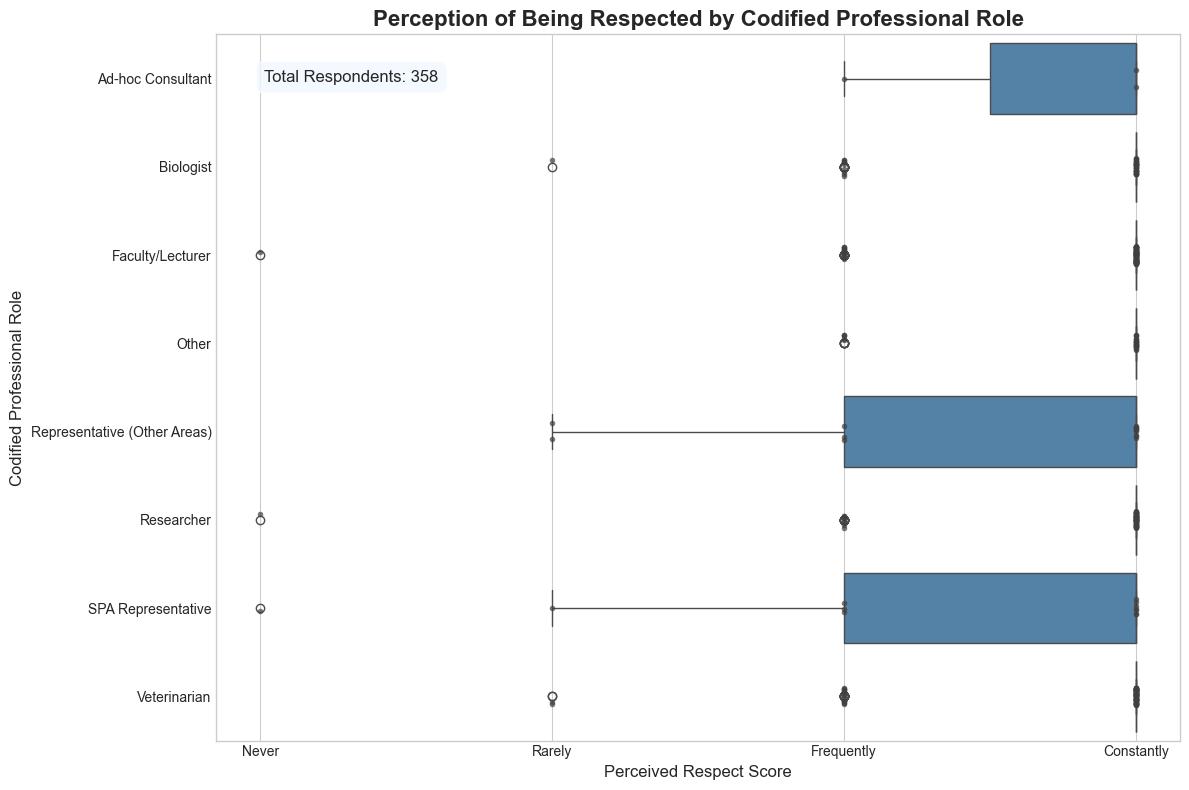

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import textwrap
import scikit_posthocs as sp

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def get_analysis_data(db_name):
    """
    Queries the database, joining SurveyAnswers with the PapelCEUALookup table
    to get the standardized, human-readable professional roles directly.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        # This improved query performs the join directly in the database, which is more efficient and robust.
        query = """
        SELECT
          p_lookup.name AS Role_Name,
          s."55. Suas_colocacoes_sao_respeitadas"
        FROM
          SurveyAnswers AS s
        JOIN
          Respondents AS r ON s.RespondentID = r."Cod."
        LEFT JOIN
          PapelCEUALookup AS p_lookup ON s."Papel_na_CEUA_codificado(28)" = p_lookup.id
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded and joined data for analysis using a plain SQL query.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def main():
    """
    Main function for the analysis of the relationship between the codified professional role
    and the perception of being respected in CEUA meetings.
    """
    df = get_analysis_data(DATABASE_NAME)
    
    if df is None or df.empty:
        print("Could not proceed with analysis due to data loading issues.")
        return
        
    df.rename(columns={
        'Role_Name': 'Role_Raw',
        '55. Suas_colocacoes_sao_respeitadas': 'Perceived_Respect_Raw'
    }, inplace=True)

    # --- Data Accounting & Preparation ---
    initial_respondents = len(df)

    # Step 1: Translate the codified roles from the lookup table to English
    role_translation_map = {
        'Biólogo (a)': 'Biologist',
        'Consultor Ad-hoc': 'Ad-hoc Consultant',
        'Docente': 'Faculty/Lecturer',
        'Incerto': 'Other',
        'Médico(a) Veterinário (a)': 'Veterinarian',
        'Representantes de outras áreas': 'Representative (Other Areas)',
        'Pesquisador(a)': 'Researcher',
        'Representante da Sociedade Protetora de Animais': 'SPA Representative'
    }
    df['Role'] = df['Role_Raw'].str.strip().map(role_translation_map)

    # Step 2: Clean and numerically encode the ordinal respect scale
    respect_map = {'Nunca': 0, 'Raramente': 1, 'Frequentemente': 2, 'Constantemente': 3}
    df['Perceived_Respect_Score'] = df['Perceived_Respect_Raw'].str.strip().map(respect_map)
    
    # Count how many rows will be dropped for the summary table
    initial_valid_roles = df['Role'].notna().sum()
    dont_know_count = (df['Perceived_Respect_Raw'].str.strip() == 'Não sei dizer').sum()

    # Step 3: Drop rows with missing data in EITHER key column
    df.dropna(subset=['Role', 'Perceived_Respect_Score'], inplace=True)
    final_analysis_count = len(df)

    # --- Data Preparation Summary Table ---
    print("\n--- Data Preparation Summary ---")
    summary_data = {
        "Initial respondents loaded": initial_respondents,
        "Respondents with a valid, codified role": initial_valid_roles,
        "...of whom answered 'Não sei dizer' for perceived respect": f"(-{dont_know_count})",
        "Final respondents in analysis (with complete data)": final_analysis_count
    }
    for key, value in summary_data.items():
        print(f"{key:<60} {value}")
    print("-" * 70)
    print("Final Role Frequencies for Analysis:")
    print(df['Role'].value_counts())
    print("-" * 70)

    # --- Kruskal-Wallis H-Test Report ---
    print("\n" + "="*70)
    print("### KRUSKAL-WALLIS H-TEST: DETAILED ANALYTICAL REPORT ###")
    print("="*70)

    intro_text = (
        "This analysis investigates whether the perception of being respected differs based on a member's "
        "pre-codified professional role. The roles were retrieved by joining the survey data with the "
        "'PapelCEUALookup' table for maximum accuracy. The ordinal 'Perceived Respect' scale was numerically "
        "encoded (0=Never to 3=Constantly). The Kruskal-Wallis H-test is the appropriate method for this "
        "comparison of an ordinal variable across multiple nominal groups."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)

    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀: The distributions of perceived respect scores are IDENTICAL for all professional roles.")
    print("H₁: The distribution of scores is DIFFERENT for at least one professional role.")
    print("-" * 70)

    median_scores = df.groupby('Role')['Perceived_Respect_Score'].median().sort_values()
    print("\n[2] Descriptive Statistics")
    print("-" * 70)
    print("Median Perceived Respect Score by Codified Role:")
    print(median_scores)
    print("-" * 70)

    groups_data = [group['Perceived_Respect_Score'].values for name, group in df.groupby('Role')]
    h_stat, p_value = stats.kruskal(*groups_data)
    epsilon_squared = h_stat / (final_analysis_count - 1) if final_analysis_count > 1 else 0

    print("\n[3] Inferential Statistics (Omnibus Test)")
    print("-" * 70)
    print(f"  Kruskal-Wallis H-statistic: {h_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print("-" * 70)

    print("\n[4] Effect Size")
    print("-" * 70)
    print(f"  Epsilon-squared (ε²): {epsilon_squared:.4f}")
    print(textwrap.fill("Interpretation: ε² estimates the proportion of variance in the ranks of the scores explained by group membership.", 70))
    print("-" * 70)
    
    print("\n[5] Analytical Conclusion")
    print("-" * 70)
    if p_value < ALPHA:
        print(textwrap.fill(f"The p-value ({p_value:.4f}) is less than {ALPHA}. We REJECT the Null Hypothesis. There is statistically significant evidence that the perception of being respected differs across the codified professional roles.", 70))
        
        print("\nPerforming Dunn's Post-Hoc Test...")
        posthoc_results = sp.posthoc_dunn(df, val_col='Perceived_Respect_Score', group_col='Role', p_adjust='bonferroni')
        print("Pairwise p-values (Bonferroni corrected):")
        print(posthoc_results.round(4))
        
        # Find and print significant pairs cleanly
        significant_pairs = posthoc_results < ALPHA
        indices = np.where(np.triu(significant_pairs.values, k=1))
        
        if len(indices[0]) > 0:
            print("\nSignificant differences were found between the following groups:")
            for i, j in zip(indices[0], indices[1]):
                group1 = significant_pairs.index[i]
                group2 = significant_pairs.columns[j]
                p_val_sig = posthoc_results.iloc[i, j]
                print(f"  - {group1} and {group2} (p={p_val_sig:.4f})")
        else:
            print("\nNo single pair of groups showed a statistically significant difference after Bonferroni correction.")

    else:
        print(textwrap.fill(f"The p-value ({p_value:.4f}) is greater than {ALPHA}. We FAIL TO REJECT the Null Hypothesis. There is insufficient evidence to conclude a difference in perception exists across the groups.", 70))
    print("="*70)

    # --- VISUALIZATION ---
    print("\n--- Generating Visualization ---")
    
    plot_order = median_scores.index.tolist()
    
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    ax = sns.boxplot(data=df, y='Role', x='Perceived_Respect_Score', order=plot_order, color='steelblue')
    sns.stripplot(data=df, y='Role', x='Perceived_Respect_Score', order=plot_order, color=".25", size=4, alpha=0.7)

    plt.title('Perception of Being Respected by Codified Professional Role', fontsize=16, fontweight='bold')
    plt.xlabel('Perceived Respect Score', fontsize=12)
    plt.ylabel('Codified Professional Role', fontsize=12)
    
    english_labels = ['Never', 'Rarely', 'Frequently', 'Constantly']
    ax.set_xticks(range(len(english_labels)))
    ax.set_xticklabels(english_labels)

    ax.text(0.05, 0.95, f'Total Respondents: {final_analysis_count}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



Success: Loaded raw data for analysis using a plain SQL query.

--- Data Preparation Summary ---
Initial respondents loaded                                   369
...of whom answered 'Não sei dizer' for refused licenses     (-135)
Final respondents in analysis (with complete data)           234
----------------------------------------------------------------------

--- Final Group Composition for Analysis ---
RejectionStatus
One or More Rejections    153
Zero Rejections            81
Name: count, dtype: int64
----------------------------------------------------------------------

### MANN-WHITNEY U TEST: DETAILED ANALYTICAL REPORT ###
This analysis investigates if there is a difference in CEUA experience
(in years) between members who have never had a proposal rejected and
those who have had one or more rejected. The complex 'Refused
Licenses' data was parsed and binned into two groups ('Zero
Rejections', 'One or More Rejections'). The Mann-Whitney U test is the
appropriate non-parametr

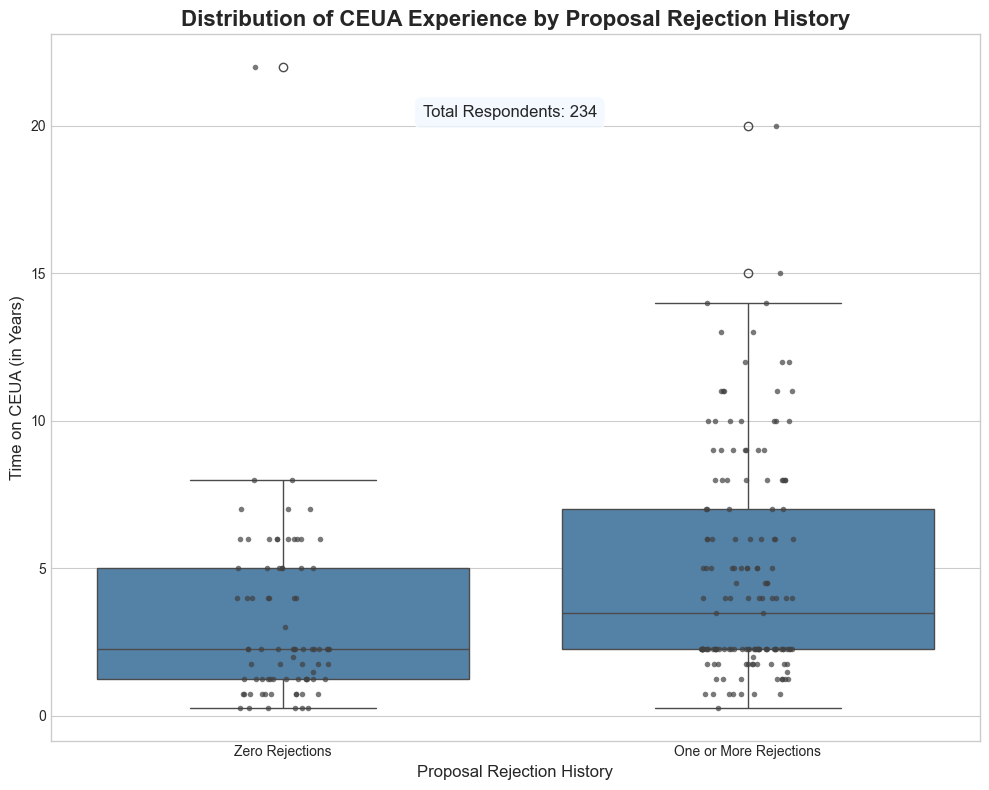

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def get_analysis_data(db_name):
    """
    Queries the database to get the necessary columns for the analysis.
    Uses a plain, static SQL query for clarity and testability.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."17. No_licencas_recusadas",
          s."tempo_de_CEUA_em_anos_avg(33,34)"
        FROM
          SurveyAnswers AS s
        JOIN
          Respondents AS r ON s.RespondentID = r."Cod."
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        print("Success: Loaded raw data for analysis using a plain SQL query.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def parse_refused_licenses(value):
    """
    A custom, robust parser for the 'No_licencas_recusadas' column,
    reused for methodological consistency.
    """
    if pd.isna(value):
        return np.nan
    
    s_value = str(value).strip().lower()

    if s_value in ['não sei dizer', 'nao sei dizer']:
        return np.nan
    
    if s_value.isdigit():
        return int(s_value)
    
    if 'entre' in s_value:
        numbers = [int(s) for s in s_value.split() if s.isdigit()]
        if len(numbers) == 2:
            return np.mean(numbers)
    
    if 'ou mais' in s_value:
        numbers = [int(s) for s in s_value.split() if s.isdigit()]
        if len(numbers) == 1:
            return numbers[0]
            
    return np.nan

def main():
    """
    Main function for the analysis of the relationship between CEUA experience
    and the history of having a proposal rejected.
    """
    df = get_analysis_data(DATABASE_NAME)
    
    if df is None or df.empty:
        print("Could not proceed with analysis due to data loading issues.")
        return
        
    df.rename(columns={
        '17. No_licencas_recusadas': 'Refused_Licenses_Raw',
        'tempo_de_CEUA_em_anos_avg(33,34)': 'Time_on_CEUA_Raw'
    }, inplace=True)

    # --- Data Accounting & Preparation ---
    initial_respondents = len(df)

    # Step 1: Parse the complex 'Refused_Licenses_Raw' column
    df['Refused_Licenses_Parsed'] = df['Refused_Licenses_Raw'].apply(parse_refused_licenses)

    # Step 2: Create the binary grouping variable 'RejectionStatus'
    def assign_status(value):
        if pd.isna(value):
            return np.nan
        elif value == 0:
            return 'Zero Rejections'
        else: # value > 0
            return 'One or More Rejections'
    df['RejectionStatus'] = df['Refused_Licenses_Parsed'].apply(assign_status)

    # Step 3: Clean the 'Time_on_CEUA_Raw' column
    df['Time_on_CEUA'] = pd.to_numeric(df['Time_on_CEUA_Raw'], errors='coerce')

    # Count how many rows will be dropped for the summary table
    dont_know_count = df['Refused_Licenses_Parsed'].isna().sum()

    # Step 4: Drop rows with missing data in EITHER key column
    df.dropna(subset=['RejectionStatus', 'Time_on_CEUA'], inplace=True)
    final_analysis_count = len(df)

    # --- Data Preparation Summary Table ---
    print("\n--- Data Preparation Summary ---")
    summary_data = {
        "Initial respondents loaded": initial_respondents,
        "...of whom answered 'Não sei dizer' for refused licenses": f"(-{dont_know_count})",
        "Final respondents in analysis (with complete data)": final_analysis_count
    }
    for key, value in summary_data.items():
        print(f"{key:<60} {value}")
    print("-" * 70)

    # --- ADDED: Final Group Composition Summary ---
    print("\n--- Final Group Composition for Analysis ---")
    print(df['RejectionStatus'].value_counts())
    print("-" * 70)

    # --- Mann-Whitney U Test Report ---
    print("\n" + "="*70)
    print("### MANN-WHITNEY U TEST: DETAILED ANALYTICAL REPORT ###")
    print("="*70)

    intro_text = (
        "This analysis investigates if there is a difference in CEUA experience (in years) between members "
        "who have never had a proposal rejected and those who have had one or more rejected. The complex "
        "'Refused Licenses' data was parsed and binned into two groups ('Zero Rejections', 'One or More Rejections'). "
        "The Mann-Whitney U test is the appropriate non-parametric method to compare the distributions of a "
        "continuous variable between two independent groups, as it does not assume normality."
    )
    print(textwrap.fill(intro_text, 70))
    print("-" * 70)

    print("\n[1] Stating the Hypotheses")
    print("-" * 70)
    print("H₀: The distributions of experience time are IDENTICAL for both groups.")
    print("H₁: The distributions of experience time are DIFFERENT for the two groups.")
    print("-" * 70)

    group_zero = df[df['RejectionStatus'] == 'Zero Rejections']['Time_on_CEUA']
    group_one_or_more = df[df['RejectionStatus'] == 'One or More Rejections']['Time_on_CEUA']

    print("\n[2] Descriptive Statistics")
    print("-" * 70)
    print("Median is a robust measure of central tendency for potentially skewed data:")
    print(f"  Median Time on CEUA (Zero Rejections): {group_zero.median():.2f} years")
    print(f"  Median Time on CEUA (One or More Rejections): {group_one_or_more.median():.2f} years")
    print("-" * 70)

    u_stat, p_value = stats.mannwhitneyu(group_zero, group_one_or_more, alternative='two-sided')
    n1, n2 = len(group_zero), len(group_one_or_more)
    effect_size_r = 1 - (2 * u_stat) / (n1 * n2)

    print("\n[3] Inferential Statistics")
    print("-" * 70)
    print(f"  Mann-Whitney U statistic: {u_stat:.1f}")
    print(f"  Calculated p-value: {p_value:.4f}")
    print("-" * 70)

    print("\n[4] Effect Size")
    print("-" * 70)
    print(f"  Rank-Biserial Correlation (r): {effect_size_r:.4f}")
    print(textwrap.fill("Interpretation: |r| measures the effect size, with ~0.1 (small), ~0.3 (medium), ~0.5 (large).", 70))
    print("-" * 70)
    
    print("\n[5] Analytical Conclusion")
    print("-" * 70)
    if p_value < ALPHA:
        print(textwrap.fill(f"The p-value ({p_value:.4f}) is less than {ALPHA}. We REJECT the Null Hypothesis. There is statistically significant evidence that a difference exists in the distribution of experience time between the two groups.", 70))
    else:
        print(textwrap.fill(f"The p-value ({p_value:.4f}) is greater than {ALPHA}. We FAIL TO REJECT the Null Hypothesis. There is insufficient evidence to conclude a difference in experience time exists between the groups based on this data.", 70))
    print("="*70)

    # --- VISUALIZATION ---
    print("\n--- Generating Visualization ---")
    
    plt.figure(figsize=(10, 8))
    sns.set_style("whitegrid")

    ax = sns.boxplot(
        data=df,
        x='RejectionStatus',
        y='Time_on_CEUA',
        order=['Zero Rejections', 'One or More Rejections'],
        color='steelblue'
    )
    sns.stripplot(
        data=df,
        x='RejectionStatus',
        y='Time_on_CEUA',
        order=['Zero Rejections', 'One or More Rejections'],
        color=".25",
        size=4,
        alpha=0.7
    )

    plt.title('Distribution of CEUA Experience by Proposal Rejection History', fontsize=16, fontweight='bold')
    plt.xlabel('Proposal Rejection History', fontsize=12)
    plt.ylabel('Time on CEUA (in Years)', fontsize=12)
    
    ax.text(0.40, 0.90, f'Total Respondents: {final_analysis_count}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



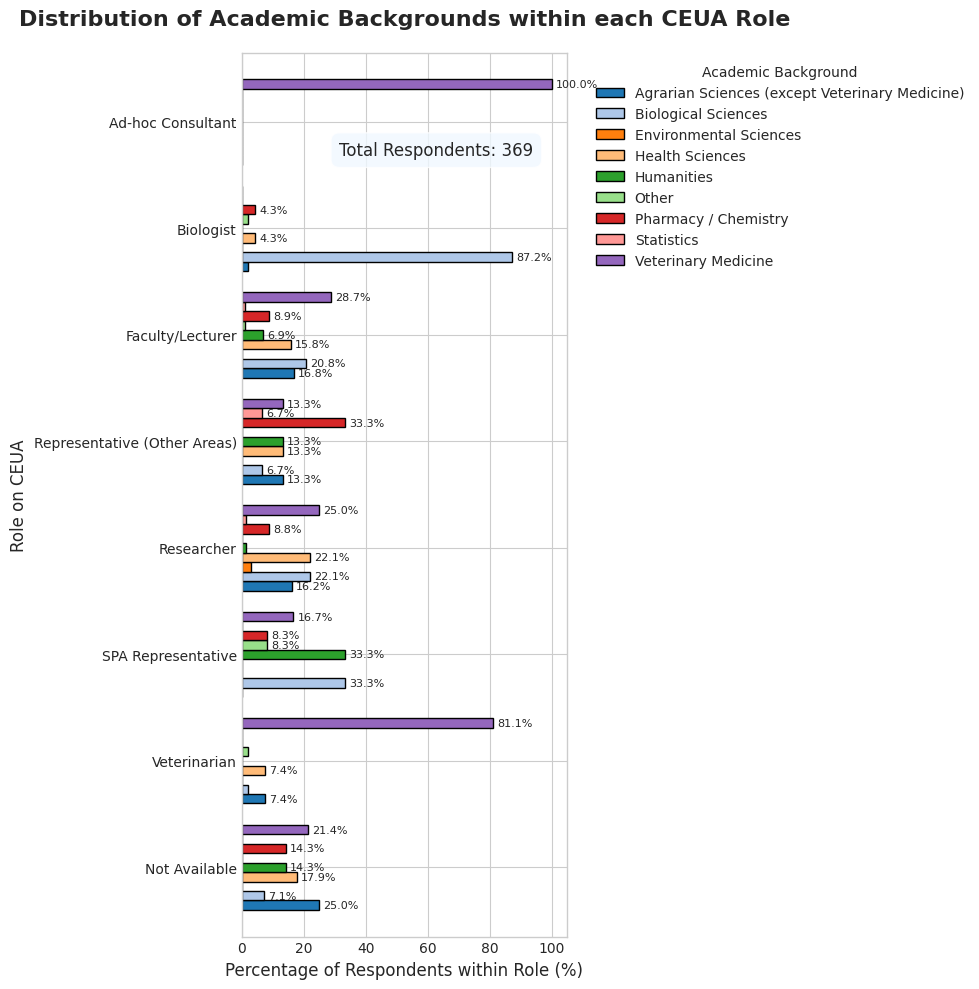

In [65]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import textwrap

# --- Configuration ---
DATABASE_NAME = 'ceua_analysis_v3.db'
ALPHA = 0.05 # Significance level

def get_analysis_data(db_name):
    """
    Queries the database, joining SurveyAnswers with the PapelCEUALookup table
    to get both the academic background and the standardized role name.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_name)
        query = """
        SELECT
          s."Area_formacao_academica_unificado(29)" AS Academic_Background,
          p_lookup.name AS Role_Name
        FROM
          SurveyAnswers AS s
        JOIN
          Respondents AS r ON s.RespondentID = r."Cod."
        LEFT JOIN
          PapelCEUALookup AS p_lookup ON s."Papel_na_CEUA_codificado(28)" = p_lookup.id
        WHERE
          r."Ativo" = 1;
        """
        df = pd.read_sql_query(query, conn)
        # Suppressing success message for cleaner output
        # print("Success: Loaded and joined data for analysis using a plain SQL query.")
        return df
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return None
    finally:
        if conn:
            conn.close()

def classify_academic_background(area_text: str) -> str:
    """
    Cleans and standardizes free-text academic area entries into major fields,
    consolidating low-frequency entries into an 'Other' category.
    """
    if pd.isna(area_text) or not isinstance(area_text, str) or area_text.strip() == '':
        return 'Other'
    
    area_upper = area_text.upper().strip()

    if 'VETERIN' in area_upper or 'ANIMAIS SELVAGENS' in area_upper: return 'Veterinary Medicine'
    if 'BIOLOG' in area_upper or 'CIÊNCIAS BIOLÓGICAS' in area_upper or 'ZOOLOGIA' in area_upper or 'OCEANOGRAFIA' in area_upper or 'ECOLOGIA' in area_upper: return 'Biological Sciences'
    if 'ZOOTEC' in area_upper or 'PRODUÇÃO ANIMAL' in area_upper or 'PESCA' in area_upper or 'AGRONOMIA' in area_upper or 'AGRÁRIAS' in area_upper: return 'Agrarian Sciences (except Veterinary Medicine)'
    if 'FARMÁCIA' in area_upper or 'FARMACEUT' in area_upper or 'QUÍMICA' in area_upper: return 'Pharmacy / Chemistry'
    if 'FILOSOFIA' in area_upper or 'HUMANIDADES' in area_upper or 'DIREITO' in area_upper or 'JURÍDICAS' in area_upper or 'GESTÃO' in area_upper or 'NEGÓCIOS' in area_upper or 'EDUCAÇÃO' in area_upper or 'COMUNICAÇÃO SOCIAL' in area_upper: return 'Humanities'
    if 'MEDICINA' in area_upper and 'VETERIN' not in area_upper or 'SAÚDE' in area_upper or 'CIRURGIA' in area_upper or 'PATOLOGIA' in area_upper or 'FISIOLOGIA' in area_upper or 'IMUNOLOGIA' in area_upper or 'GENÉTICA' in area_upper or 'RADIOLOGIA' in area_upper or 'FISIOTERAPIA' in area_upper or 'PSICOLOGIA' in area_upper or 'ENFERMAGEM' in area_upper or 'NUTRIÇÃO' in area_upper or 'ODONTOLOGIA' in area_upper or 'BIOMEDICINA' in area_upper: return 'Health Sciences'
    if 'AMBIENTAIS' in area_upper: return 'Environmental Sciences'
    if 'ESTATÍSTICA' in area_upper: return 'Statistics'
    
    # Methodologically critical fallback for all other low-frequency entries.
    return 'Other'

def main():
    """
    Main function for the Chi-Squared analysis of the relationship between 
    academic background and role on the CEUA.
    """
    df = get_analysis_data(DATABASE_NAME)
    
    if df is None or df.empty:
        # print("Could not proceed with analysis due to data loading issues.")
        return
        
    df.rename(columns={'Role_Name': 'Role_Raw'}, inplace=True)

    # --- Data Accounting & Preparation ---
    initial_respondents = len(df)

    # Step 1: Apply the classification function to consolidate academic backgrounds
    df['Academic_Group'] = df['Academic_Background'].apply(classify_academic_background)

    # Step 2: Translate the codified roles to English
    role_translation_map = {
        'Biólogo (a)': 'Biologist', 'Consultor Ad-hoc': 'Ad-hoc Consultant',
        'Docente': 'Faculty/Lecturer', 'Incerto': 'Not Available',
        'Médico(a) Veterinário (a)': 'Veterinarian',
        'Representantes de outras áreas': 'Representative (Other Areas)',
        'Pesquisador(a)': 'Researcher',
        'Representante da Sociedade Protetora de Animais': 'SPA Representative'
    }
    df['Role'] = df['Role_Raw'].str.strip().map(role_translation_map)
    
    # Step 3: Drop rows with missing data in EITHER key column
    df.dropna(subset=['Role', 'Academic_Group'], inplace=True)
    final_analysis_count = len(df)

    # --- Contingency Table ---
    contingency_table = pd.crosstab(df['Role'], df['Academic_Group'])
    
    # --- Chi-Squared Test of Independence (Calculations only) ---
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if n > 0 and min_dim > 0 else 0

    # --- MODIFICATION: All print statements for the report are commented out ---
    # print("\n" + "="*70)
    # print("### CHI-SQUARED TEST OF INDEPENDENCE: ANALYTICAL REPORT ###")
    # print("="*70)
    # intro_text = (
    #     "This analysis investigates whether an association exists between a member's academic background and the "
    #     "role they occupy on the CEUA. The 90+ unique academic backgrounds were consolidated into a smaller set of "
    #     "justifiable super-categories. Since both variables are categorical (nominal), the Chi-Squared (χ²) test of "
    #     "independence is the correct method to determine if the observed distribution of academic backgrounds across "
    #     "roles differs from what would be expected by chance."
    # )
    # print(textwrap.fill(intro_text, 70))
    # print("\n[1] Stating the Hypotheses")
    # print("-" * 70)
    # print("H₀ (Null Hypothesis): There is NO association between academic background and CEUA role.")
    # print("H₁ (Alternative Hypothesis): There IS an association between academic background and CEUA role.")
    # print("-" * 70)
    # print("\n[2] Statistical Results")
    # print("-" * 70)
    # print(f"  Chi-Squared Statistic (χ²): {chi2:.4f}")
    # print(f"  P-value: {p_value:.4f}")
    # print(f"  Degrees of Freedom: {dof}")
    # print("-" * 70)
    # print("\n[3] Effect Size")
    # print("-" * 70)
    # print(f"  Cramér's V: {cramers_v:.4f}")
    # print(textwrap.fill("Interpretation: Cramér's V measures the strength of association (0=none, 1=perfect). A common guide for this table size is: ~0.1 (small), ~0.2 (medium), ~0.4 (large effect).", 70))
    # print("-" * 70)
    # print("\n[4] Analytical Conclusion")
    # print("-" * 70)
    # if p_value < ALPHA:
    #     print(textwrap.fill(f"The p-value ({p_value:.4f}) is less than {ALPHA}. We REJECT the Null Hypothesis. There is a statistically significant association between a member's academic background and the role they hold on the CEUA.", 70))
    # else:
    #     print(textwrap.fill(f"The p-value ({p_value:.4f}) is greater than {ALPHA}. We FAIL TO REJECT the Null Hypothesis. There is insufficient evidence to conclude an association exists between the variables.", 70))
    # print("="*70)

    # --- REVISED VISUALIZATION: Horizontal Grouped Bar Chart ---
    # print("\n--- Generating Visualization ---")
    
    proportions_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    # Create a custom alphabetical order for the plot's y-axis (roles)
    main_roles = proportions_table.index.tolist()
    not_available_category = None
    if 'Not Available' in main_roles:
        main_roles.remove('Not Available')
        not_available_category = 'Not Available'
    
    main_roles.sort()
    
    final_visual_order = main_roles
    if not_available_category:
        final_visual_order.append(not_available_category)
        
    plotting_order = final_visual_order[::-1]
    
    proportions_table = proportions_table.reindex(plotting_order)

    # Use a high-contrast qualitative color palette
    num_categories = len(proportions_table.columns)
    color_palette = sns.color_palette("tab20", n_colors=num_categories)
    
    ax = proportions_table.plot(
        kind='barh', 
        figsize=(12, 10), 
        color=color_palette,
        edgecolor='black',
        width=0.8
    )

    plt.title('Distribution of Academic Backgrounds within each CEUA Role', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Percentage of Respondents within Role (%)', fontsize=12)
    plt.ylabel('Role on CEUA', fontsize=12)
    plt.yticks(rotation=0)
    plt.xlim(0, 105)

    plt.legend(title='Academic Background', bbox_to_anchor=(1.05, 1), loc='upper left')

    for container in ax.containers:
        labels = [f'{v:.1f}%' if v > 3 else '' for v in container.datavalues] 
        ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontsize=8)

    ax.text(0.30, 0.90, f'Total Respondents: {final_analysis_count}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

if __name__ == '__main__':
    main()

